In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,"..")

In [3]:
# print(sys.path)

In [4]:
from optimus import Optimus

In [5]:
# op = Optimus(engine="dask",verbose=True)
op = Optimus("dask", n_workers=1, threads_per_worker=8, processes=False, memory_limit="3G")

C:\Users\argenisleon\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\argenisleon\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\argenisleon\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [6]:
# df = op.load.file("data/Meteorite_Landings.csv")
# df = op.load.file("https://bumblebee.nyc3.digitaloceanspaces.com/luisaguirre/edad-32291509-7a3f-4d48-a3a5-a224e088dde7.csv")
df = op.load.file("data/crime.csv").cache()
# df = op.load.file("data/crime.csv")
# df= df.to_optimus_pandas()

# op.load.csv("data/airline-safety_csv.csv", sep=",", error_bad_lines=False, header=True, null_value="null",infer_schema="true").ext.cache()

In [7]:
df.head()

INCIDENT_NUMBER OFFENSE_CODE               OFFENSE_CODE_GROUP  \
0      I182070945        00619                          Larceny   
1      I182070943        01402                        Vandalism   
2      I182070941        03410                            Towed   
3      I182070940        03114             Investigate Property   
4      I182070938        03114             Investigate Property   
5      I182070936        03820  Motor Vehicle Accident Response   
6      I182070933        00724                       Auto Theft   
7      I182070932        03301                  Verbal Disputes   
8      I182070931        00301                          Robbery   
9      I182070929        03301                  Verbal Disputes   

                          OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA  \
0                          LARCENY ALL OTHERS      D14            808   
1                                   VANDALISM      C11            347   
2                         TOWED MOTOR VEHICLE       D4            151   
3                        INVESTIGATE PROPERTY       D4            272   
4                        INVESTIGATE PROPERTY       B3            421   
5  M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY      C11            398   
6                                  AUTO THEFT       B2            330   
7                              VERBAL DISPUTE       B2            584   
8                            ROBBERY - STREET       C6            177   
9                              VERBAL DISPUTE      C11            364   

  SHOOTING     OCCURRED_ON_DATE  YEAR MONTH DAY_OF_WEEK HOUR    UCR_PART  \
0           2018-09-02 13:00:00  2018     9      Sunday   13    Part One   
1           2018-08-21 00:00:00  2018     8     Tuesday    0    Part Two   
2           2018-09-03 19:27:00  2018     9      Monday   19  Part Three   
3           2018-09-03 21:16:00  2018     9      Monday   21  Part Three   
4           2018-09-03 21:05:00  2018     9      Monday   21  Part Three   
5           2018-09-03 21:09:00  2018     9      Monday   21  Part Three   
6           2018-09-03 21:25:00  2018     9      Monday   21    Part One   
7           2018-09-03 20:39:37  2018     9      Monday   20  Part Three   
8           2018-09-03 20:48:00  2018     9      Monday   20    Part One   
9           2018-09-03 20:38:00  2018     9      Monday   20  Part Three   

              STREET          Lat          Long                     Location  
0         LINCOLN ST  42.35779134  -71.13937053  (42.35779134, -71.13937053)  
1           HECLA ST  42.30682138  -71.06030035  (42.30682138, -71.06030035)  
2        CAZENOVE ST  42.34658879  -71.07242943  (42.34658879, -71.07242943)  
3         NEWCOMB ST  42.33418175  -71.07866441  (42.33418175, -71.07866441)  
4           DELHI ST  42.27536542  -71.09036101  (42.27536542, -71.09036101)  
5         TALBOT AVE  42.29019621  -71.07159012  (42.29019621, -71.07159012)  
6        NORMANDY ST  42.30607218  -71.08273260  (42.30607218, -71.08273260)  
7            LAWN ST  42.32701648  -71.10555088  (42.32701648, -71.10555088)  
8  MASSACHUSETTS AVE  42.33152148  -71.07085307  (42.33152148, -71.07085307)  
9          LESLIE ST  42.29514664  -71.05860832  (42.29514664, -71.05860832)

In [8]:
df1 = df.cols.lower("INCIDENT_NUMBER")

In [9]:
df1.meta

{'file_name': 'data/crime.csv',
 'name': 'crime.csv',
 'transformations': {'actions': [{'lower': ['INCIDENT_NUMBER']}]}}

In [10]:
df[0]

<class 'optimus.engines.dask.dataframe.DaskDataFrame'>

In [11]:
import dask
from dask.dataframe import from_delayed


def oset(col_name, expr, where):
    
    where = (where.data[where.cols.names(0)[0]]).to_delayed()
    ddf = df.to_delayed()
    
    def func(_df, _col_name, _mask):
        
        _df.loc[_mask,[_col_name]]=expr(_df)
        return _df

    for _part,_mask in zip(ddf, where):
        delayed_parts = dask.delayed(func)(_part, col_name, _mask)

    return from_delayed(delayed_parts)

col_name="INCIDENT_NUMBER"
where= ((df[col_name]=="I182070945") | (df["DISTRICT"]=="I182070945"))
F = df.functions

def expr(series):
    return F.lower(series["OFFENSE_CODE_GROUP"])


oset(col_name, expr, where).compute()

INCIDENT_NUMBER OFFENSE_CODE    OFFENSE_CODE_GROUP  \
0              larceny        00619               Larceny   
1           I182070943        01402             Vandalism   
2           I182070941        03410                 Towed   
3           I182070940        03114  Investigate Property   
4           I182070938        03114  Investigate Property   
...                ...          ...                   ...   
319068   I050310906-00        03125       Warrant Arrests   
319069   I030217815-08        00111              Homicide   
319070   I030217815-08        03125       Warrant Arrests   
319071   I010370257-00        03125       Warrant Arrests   
319072       142052550        03125       Warrant Arrests   

                        OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
0                        LARCENY ALL OTHERS      D14            808            
1                                 VANDALISM      C11            347            
2                       TOWED MOTOR VEHICLE       D4            151            
3                      INVESTIGATE PROPERTY       D4            272            
4                      INVESTIGATE PROPERTY       B3            421            
...                                     ...      ...            ...      ...   
319068                       WARRANT ARREST       D4            285            
319069  MURDER, NON-NEGLIGIENT MANSLAUGHTER      E18            520            
319070                       WARRANT ARREST      E18            520            
319071                       WARRANT ARREST      E13            569            
319072                       WARRANT ARREST       D4            903            

           OCCURRED_ON_DATE  YEAR MONTH DAY_OF_WEEK HOUR    UCR_PART  \
0       2018-09-02 13:00:00  2018     9      Sunday   13    Part One   
1       2018-08-21 00:00:00  2018     8     Tuesday    0    Part Two   
2       2018-09-03 19:27:00  2018     9      Monday   19  Part Three   
3       2018-09-03 21:16:00  2018     9      Monday   21  Part Three   
4       2018-09-03 21:05:00  2018     9      Monday   21  Part Three   
...                     ...   ...   ...         ...  ...         ...   
319068  2016-06-05 17:25:00  2016     6      Sunday   17  Part Three   
319069  2015-07-09 13:38:00  2015     7    Thursday   13    Part One   
319070  2015-07-09 13:38:00  2015     7    Thursday   13  Part Three   
319071  2016-05-31 19:35:00  2016     5     Tuesday   19  Part Three   
319072  2015-06-22 00:12:00  2015     6      Monday    0  Part Three   

                   STREET          Lat          Long  \
0              LINCOLN ST  42.35779134  -71.13937053   
1                HECLA ST  42.30682138  -71.06030035   
2             CAZENOVE ST  42.34658879  -71.07242943   
3              NEWCOMB ST  42.33418175  -71.07866441   
4                DELHI ST  42.27536542  -71.09036101   
...                   ...          ...           ...   
319068        COVENTRY ST  42.33695098  -71.08574813   
319069           RIVER ST  42.25592648  -71.12317207   
319070           RIVER ST  42.25592648  -71.12317207   
319071  NEW WASHINGTON ST  42.30233307  -71.11156487   
319072      WASHINGTON ST  42.33383935  -71.08029038   

                           Location  
0       (42.35779134, -71.13937053)  
1       (42.30682138, -71.06030035)  
2       (42.34658879, -71.07242943)  
3       (42.33418175, -71.07866441)  
4       (42.27536542, -71.09036101)  
...                             ...  
319068  (42.33695098, -71.08574813)  
319069  (42.25592648, -71.12317207)  
319070  (42.25592648, -71.12317207)  
319071  (42.30233307, -71.11156487)  
319072  (42.33383935, -71.08029038)  

[319073 rows x 17 columns]

In [12]:
df.head()

INCIDENT_NUMBER OFFENSE_CODE               OFFENSE_CODE_GROUP  \
0         larceny        00619                          Larceny   
1      I182070943        01402                        Vandalism   
2      I182070941        03410                            Towed   
3      I182070940        03114             Investigate Property   
4      I182070938        03114             Investigate Property   
5      I182070936        03820  Motor Vehicle Accident Response   
6      I182070933        00724                       Auto Theft   
7      I182070932        03301                  Verbal Disputes   
8      I182070931        00301                          Robbery   
9      I182070929        03301                  Verbal Disputes   

                          OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA  \
0                          LARCENY ALL OTHERS      D14            808   
1                                   VANDALISM      C11            347   
2                         TOWED MOTOR VEHICLE       D4            151   
3                        INVESTIGATE PROPERTY       D4            272   
4                        INVESTIGATE PROPERTY       B3            421   
5  M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY      C11            398   
6                                  AUTO THEFT       B2            330   
7                              VERBAL DISPUTE       B2            584   
8                            ROBBERY - STREET       C6            177   
9                              VERBAL DISPUTE      C11            364   

  SHOOTING     OCCURRED_ON_DATE  YEAR MONTH DAY_OF_WEEK HOUR    UCR_PART  \
0           2018-09-02 13:00:00  2018     9      Sunday   13    Part One   
1           2018-08-21 00:00:00  2018     8     Tuesday    0    Part Two   
2           2018-09-03 19:27:00  2018     9      Monday   19  Part Three   
3           2018-09-03 21:16:00  2018     9      Monday   21  Part Three   
4           2018-09-03 21:05:00  2018     9      Monday   21  Part Three   
5           2018-09-03 21:09:00  2018     9      Monday   21  Part Three   
6           2018-09-03 21:25:00  2018     9      Monday   21    Part One   
7           2018-09-03 20:39:37  2018     9      Monday   20  Part Three   
8           2018-09-03 20:48:00  2018     9      Monday   20    Part One   
9           2018-09-03 20:38:00  2018     9      Monday   20  Part Three   

              STREET          Lat          Long                     Location  
0         LINCOLN ST  42.35779134  -71.13937053  (42.35779134, -71.13937053)  
1           HECLA ST  42.30682138  -71.06030035  (42.30682138, -71.06030035)  
2        CAZENOVE ST  42.34658879  -71.07242943  (42.34658879, -71.07242943)  
3         NEWCOMB ST  42.33418175  -71.07866441  (42.33418175, -71.07866441)  
4           DELHI ST  42.27536542  -71.09036101  (42.27536542, -71.09036101)  
5         TALBOT AVE  42.29019621  -71.07159012  (42.29019621, -71.07159012)  
6        NORMANDY ST  42.30607218  -71.08273260  (42.30607218, -71.08273260)  
7            LAWN ST  42.32701648  -71.10555088  (42.32701648, -71.10555088)  
8  MASSACHUSETTS AVE  42.33152148  -71.07085307  (42.33152148, -71.07085307)  
9          LESLIE ST  42.29514664  -71.05860832  (42.29514664, -71.05860832)

In [41]:
df["INCIDENT_NUMBER"].cols.names(0)

['INCIDENT_NUMBER']

In [10]:
((df["INCIDENT_NUMBER"].data["INCIDENT_NUMBER"]=="i182070945") | (df["DISTRICT"].data["DISTRICT"]=="I182070945")).compute()

0         False
1         False
2         False
3         False
4         False
          ...  
319068    False
319069    False
319070    False
319071    False
319072    False
Length: 319073, dtype: bool

In [7]:
df.cols.names()

['INCIDENT_NUMBER',
 'OFFENSE_CODE',
 'OFFENSE_CODE_GROUP',
 'OFFENSE_DESCRIPTION',
 'DISTRICT',
 'REPORTING_AREA',
 'SHOOTING',
 'OCCURRED_ON_DATE',
 'YEAR',
 'MONTH',
 'DAY_OF_WEEK',
 'HOUR',
 'UCR_PART',
 'STREET',
 'Lat',
 'Long',
 'Location']

In [12]:
df.set_buffer()

In [35]:
%%time
df.profile("INCIDENT_NUMBER")

Wall time: 1.67 s


{'columns': {'INCIDENT_NUMBER': {'profiler_dtype': {'dtype': 'string'},
   'stats': {'match': 319073,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'string'},
    'frequency': [{'value': 'I162030584', 'count': 13},
     {'value': 'I152080623', 'count': 11},
     {'value': 'I172013170', 'count': 10},
     {'value': 'I182065208', 'count': 10},
     {'value': 'I172096394', 'count': 10},
     {'value': 'I162071327', 'count': 9},
     {'value': 'I162001871', 'count': 9},
     {'value': 'I172056883', 'count': 9},
     {'value': 'I172054429', 'count': 9},
     {'value': 'I162098170', 'count': 9},
     {'value': 'I172022524', 'count': 9},
     {'value': 'I152076465', 'count': 8},
     {'value': 'I172053616', 'count': 8},
     {'value': 'I152105431', 'count': 8},
     {'value': 'I162082917', 'count': 8},
     {'value': 'I162064331', 'count': 8},
     {'value': 'I162056703', 'count': 8},
     {'value': 'I130041200-00', 'count': 8},
     {'value': 'I162087224', 'count': 8},

In [36]:
df.meta

{'profile': {'columns': {'INCIDENT_NUMBER': {'profiler_dtype': {'dtype': 'string'},
    'stats': {'match': 319073,
     'missing': 0,
     'mismatch': 0,
     'profiler_dtype': {'dtype': 'string'},
     'frequency': [{'value': 'I162030584', 'count': 13},
      {'value': 'I152080623', 'count': 11},
      {'value': 'I172013170', 'count': 10},
      {'value': 'I182065208', 'count': 10},
      {'value': 'I172096394', 'count': 10},
      {'value': 'I162071327', 'count': 9},
      {'value': 'I162001871', 'count': 9},
      {'value': 'I172056883', 'count': 9},
      {'value': 'I172054429', 'count': 9},
      {'value': 'I162098170', 'count': 9},
      {'value': 'I172022524', 'count': 9},
      {'value': 'I152076465', 'count': 8},
      {'value': 'I172053616', 'count': 8},
      {'value': 'I152105431', 'count': 8},
      {'value': 'I162082917', 'count': 8},
      {'value': 'I162064331', 'count': 8},
      {'value': 'I162056703', 'count': 8},
      {'value': 'I130041200-00', 'count': 8},
      {

In [16]:
df  = df.cols.cast("OFFENSE_CODE", "int").cache()

In [17]:
df.display()

In [18]:
(df["OFFENSE_CODE"] - df["OFFENSE_CODE"]).head()

OFFENSE_CODE
0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0

In [19]:
(df["INCIDENT_NUMBER"] == df["INCIDENT_NUMBER"]).compute()

INCIDENT_NUMBER
0                  True
1                  True
2                  True
3                  True
4                  True
...                 ...
319068             True
319069             True
319070             True
319071             True
319072             True

[319073 rows x 1 columns]

In [20]:
df.cols.names()

['INCIDENT_NUMBER',
 'OFFENSE_CODE',
 'OFFENSE_CODE_GROUP',
 'OFFENSE_DESCRIPTION',
 'DISTRICT',
 'REPORTING_AREA',
 'SHOOTING',
 'OCCURRED_ON_DATE',
 'YEAR',
 'MONTH',
 'DAY_OF_WEEK',
 'HOUR',
 'UCR_PART',
 'STREET',
 'Lat',
 'Long',
 'Location']

In [21]:
df.cols.to_float("*").data.head()

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  OFFENSE_DESCRIPTION  \
0              NaN         619.0                 NaN                  NaN   
1              NaN        1402.0                 NaN                  NaN   
2              NaN        3410.0                 NaN                  NaN   
3              NaN        3114.0                 NaN                  NaN   
4              NaN        3114.0                 NaN                  NaN   

   DISTRICT  REPORTING_AREA  SHOOTING  OCCURRED_ON_DATE    YEAR  MONTH  \
0       NaN           808.0       NaN               NaN  2018.0    9.0   
1       NaN           347.0       NaN               NaN  2018.0    8.0   
2       NaN           151.0       NaN               NaN  2018.0    9.0   
3       NaN           272.0       NaN               NaN  2018.0    9.0   
4       NaN           421.0       NaN               NaN  2018.0    9.0   

   DAY_OF_WEEK  HOUR  UCR_PART  STREET        Lat       Long  Location  
0          NaN  13.0       NaN     NaN  42.357791 -71.139371       NaN  
1          NaN   0.0       NaN     NaN  42.306821 -71.060300       NaN  
2          NaN  19.0       NaN     NaN  42.346589 -71.072429       NaN  
3          NaN  21.0       NaN     NaN  42.334182 -71.078664       NaN  
4          NaN  21.0       NaN     NaN  42.275365 -71.090361       NaN

In [22]:
%%time
df.profile()

Wall time: 17.8 s


{'columns': {'INCIDENT_NUMBER': {'stats': {'match': 319073,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'string'},
    'frequency': [{'value': 'I162030584', 'count': 13},
     {'value': 'I152080623', 'count': 11},
     {'value': 'I172013170', 'count': 10},
     {'value': 'I182065208', 'count': 10},
     {'value': 'I172096394', 'count': 10},
     {'value': 'I162071327', 'count': 9},
     {'value': 'I162001871', 'count': 9},
     {'value': 'I172056883', 'count': 9},
     {'value': 'I172054429', 'count': 9},
     {'value': 'I162098170', 'count': 9},
     {'value': 'I172022524', 'count': 9},
     {'value': 'I152076465', 'count': 8},
     {'value': 'I172053616', 'count': 8},
     {'value': 'I152105431', 'count': 8},
     {'value': 'I162082917', 'count': 8},
     {'value': 'I162064331', 'count': 8},
     {'value': 'I162056703', 'count': 8},
     {'value': 'I130041200-00', 'count': 8},
     {'value': 'I162087224', 'count': 8},
     {'value': 'I162022140', 'count': 8},

In [23]:
df.cols.lower("INCIDENT_NUMBER").data.head()

INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION  \
0      i182070945           619               Larceny    LARCENY ALL OTHERS   
1      i182070943          1402             Vandalism             VANDALISM   
2      i182070941          3410                 Towed   TOWED MOTOR VEHICLE   
3      i182070940          3114  Investigate Property  INVESTIGATE PROPERTY   
4      i182070938          3114  Investigate Property  INVESTIGATE PROPERTY   

  DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE  YEAR MONTH  \
0      D14            808           2018-09-02 13:00:00  2018     9   
1      C11            347           2018-08-21 00:00:00  2018     8   
2       D4            151           2018-09-03 19:27:00  2018     9   
3       D4            272           2018-09-03 21:16:00  2018     9   
4       B3            421           2018-09-03 21:05:00  2018     9   

  DAY_OF_WEEK HOUR    UCR_PART       STREET          Lat          Long  \
0      Sunday   13    Part One   LINCOLN ST  42.35779134  -71.13937053   
1     Tuesday    0    Part Two     HECLA ST  42.30682138  -71.06030035   
2      Monday   19  Part Three  CAZENOVE ST  42.34658879  -71.07242943   
3      Monday   21  Part Three   NEWCOMB ST  42.33418175  -71.07866441   
4      Monday   21  Part Three     DELHI ST  42.27536542  -71.09036101   

                      Location  
0  (42.35779134, -71.13937053)  
1  (42.30682138, -71.06030035)  
2  (42.34658879, -71.07242943)  
3  (42.33418175, -71.07866441)  
4  (42.27536542, -71.09036101)

In [24]:
# import pandas as pd
# df = pd.DataFrame([[1, 2], [4, 5], [7, 8]],
#      index=['cobra', 'viper', 'sidewinder'],
#      columns=['max_speed', 'shield'])


In [25]:
df.data.head()

INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION  \
0      I182070945           619               Larceny    LARCENY ALL OTHERS   
1      I182070943          1402             Vandalism             VANDALISM   
2      I182070941          3410                 Towed   TOWED MOTOR VEHICLE   
3      I182070940          3114  Investigate Property  INVESTIGATE PROPERTY   
4      I182070938          3114  Investigate Property  INVESTIGATE PROPERTY   

  DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE  YEAR MONTH  \
0      D14            808           2018-09-02 13:00:00  2018     9   
1      C11            347           2018-08-21 00:00:00  2018     8   
2       D4            151           2018-09-03 19:27:00  2018     9   
3       D4            272           2018-09-03 21:16:00  2018     9   
4       B3            421           2018-09-03 21:05:00  2018     9   

  DAY_OF_WEEK HOUR    UCR_PART       STREET          Lat          Long  \
0      Sunday   13    Part One   LINCOLN ST  42.35779134  -71.13937053   
1     Tuesday    0    Part Two     HECLA ST  42.30682138  -71.06030035   
2      Monday   19  Part Three  CAZENOVE ST  42.34658879  -71.07242943   
3      Monday   21  Part Three   NEWCOMB ST  42.33418175  -71.07866441   
4      Monday   21  Part Three     DELHI ST  42.27536542  -71.09036101   

                      Location  
0  (42.35779134, -71.13937053)  
1  (42.30682138, -71.06030035)  
2  (42.34658879, -71.07242943)  
3  (42.33418175, -71.07866441)  
4  (42.27536542, -71.09036101)

In [26]:
df.rows.is_profiler_dtype("INCIDENT_NUMBER", "int").head()

AttributeError: 'Rows' object has no attribute 'is_profiler_dtype'

In [ ]:
df.cols.match("INCIDENT_NUMBER","I").head()

In [27]:
df.cols.names()

['INCIDENT_NUMBER',
 'OFFENSE_CODE',
 'OFFENSE_CODE_GROUP',
 'OFFENSE_DESCRIPTION',
 'DISTRICT',
 'REPORTING_AREA',
 'SHOOTING',
 'OCCURRED_ON_DATE',
 'YEAR',
 'MONTH',
 'DAY_OF_WEEK',
 'HOUR',
 'UCR_PART',
 'STREET',
 'Lat',
 'Long',
 'Location']

In [28]:
list(("INCIDENT_NUMBER",))

['INCIDENT_NUMBER']

In [29]:
# df.cols.select(("INCIDENT_NUMBER",))
df.cols.select("INCIDENT_NUMBER")

In [30]:
df.head()

INCIDENT_NUMBER  OFFENSE_CODE               OFFENSE_CODE_GROUP  \
0      I182070945           619                          Larceny   
1      I182070943          1402                        Vandalism   
2      I182070941          3410                            Towed   
3      I182070940          3114             Investigate Property   
4      I182070938          3114             Investigate Property   
5      I182070936          3820  Motor Vehicle Accident Response   
6      I182070933           724                       Auto Theft   
7      I182070932          3301                  Verbal Disputes   
8      I182070931           301                          Robbery   
9      I182070929          3301                  Verbal Disputes   

                          OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA  \
0                          LARCENY ALL OTHERS      D14            808   
1                                   VANDALISM      C11            347   
2                         TOWED MOTOR VEHICLE       D4            151   
3                        INVESTIGATE PROPERTY       D4            272   
4                        INVESTIGATE PROPERTY       B3            421   
5  M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY      C11            398   
6                                  AUTO THEFT       B2            330   
7                              VERBAL DISPUTE       B2            584   
8                            ROBBERY - STREET       C6            177   
9                              VERBAL DISPUTE      C11            364   

  SHOOTING     OCCURRED_ON_DATE  YEAR MONTH DAY_OF_WEEK HOUR    UCR_PART  \
0           2018-09-02 13:00:00  2018     9      Sunday   13    Part One   
1           2018-08-21 00:00:00  2018     8     Tuesday    0    Part Two   
2           2018-09-03 19:27:00  2018     9      Monday   19  Part Three   
3           2018-09-03 21:16:00  2018     9      Monday   21  Part Three   
4           2018-09-03 21:05:00  2018     9      Monday   21  Part Three   
5           2018-09-03 21:09:00  2018     9      Monday   21  Part Three   
6           2018-09-03 21:25:00  2018     9      Monday   21    Part One   
7           2018-09-03 20:39:37  2018     9      Monday   20  Part Three   
8           2018-09-03 20:48:00  2018     9      Monday   20    Part One   
9           2018-09-03 20:38:00  2018     9      Monday   20  Part Three   

              STREET          Lat          Long                     Location  
0         LINCOLN ST  42.35779134  -71.13937053  (42.35779134, -71.13937053)  
1           HECLA ST  42.30682138  -71.06030035  (42.30682138, -71.06030035)  
2        CAZENOVE ST  42.34658879  -71.07242943  (42.34658879, -71.07242943)  
3         NEWCOMB ST  42.33418175  -71.07866441  (42.33418175, -71.07866441)  
4           DELHI ST  42.27536542  -71.09036101  (42.27536542, -71.09036101)  
5         TALBOT AVE  42.29019621  -71.07159012  (42.29019621, -71.07159012)  
6        NORMANDY ST  42.30607218  -71.08273260  (42.30607218, -71.08273260)  
7            LAWN ST  42.32701648  -71.10555088  (42.32701648, -71.10555088)  
8  MASSACHUSETTS AVE  42.33152148  -71.07085307  (42.33152148, -71.07085307)  
9          LESLIE ST  42.29514664  -71.05860832  (42.29514664, -71.05860832)

In [50]:
df["INCIDENT_NUMBER"].mask.equal("INCIDENT_NUMBER","I182070945").display()

In [27]:
df.mask.match("INCIDENT_NUMBER","int")

In [ ]:

import dask
from dask.dataframe import from_delayed


def oset(col_name, expr, where):
    
    where = (where.data[where.cols.names(0)[0]]).to_delayed()
    ddf = df.to_delayed()
    
    def func(_df, _col_name, _mask):
        
#         _df.loc[_mask,[_col_name]]=expr(_df)
        return _df

    for _part,_mask in zip(ddf, where):
        delayed_parts = dask.delayed(func)(_part, col_name, _mask)

    return from_delayed(delayed_parts)

col_name="INCIDENT_NUMBER"
where= ((df[col_name]=="i182070945") | (df["DISTRICT"]=="I182070945"))

F = df.functions

def expr(series):
    return F.lower(series["OFFENSE_CODE_GROUP"])


oset(col_name, expr, where).compute()

In [33]:
# col_name = "INCIDENT_NUMBER"
def func(pdf):
    mask = pdf["INCIDENT_NUMBER"]=="I182070945"
    pdf.loc[mask,["INCIDENT_NUMBER"]]=pdf["INCIDENT_NUMBER"].str.lower()
    return pdf

df.data.map_partitions(func).head()

INCIDENT_NUMBER OFFENSE_CODE    OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION  \
0      i182070945        00619               Larceny    LARCENY ALL OTHERS   
1      I182070943        01402             Vandalism             VANDALISM   
2      I182070941        03410                 Towed   TOWED MOTOR VEHICLE   
3      I182070940        03114  Investigate Property  INVESTIGATE PROPERTY   
4      I182070938        03114  Investigate Property  INVESTIGATE PROPERTY   

  DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE  YEAR MONTH  \
0      D14            808           2018-09-02 13:00:00  2018     9   
1      C11            347           2018-08-21 00:00:00  2018     8   
2       D4            151           2018-09-03 19:27:00  2018     9   
3       D4            272           2018-09-03 21:16:00  2018     9   
4       B3            421           2018-09-03 21:05:00  2018     9   

  DAY_OF_WEEK HOUR    UCR_PART       STREET          Lat          Long  \
0      Sunday   13    Part One   LINCOLN ST  42.35779134  -71.13937053   
1     Tuesday    0    Part Two     HECLA ST  42.30682138  -71.06030035   
2      Monday   19  Part Three  CAZENOVE ST  42.34658879  -71.07242943   
3      Monday   21  Part Three   NEWCOMB ST  42.33418175  -71.07866441   
4      Monday   21  Part Three     DELHI ST  42.27536542  -71.09036101   

                      Location  
0  (42.35779134, -71.13937053)  
1  (42.30682138, -71.06030035)  
2  (42.34658879, -71.07242943)  
3  (42.33418175, -71.07866441)  
4  (42.27536542, -71.09036101)

In [16]:
df.data.head()

INCIDENT_NUMBER OFFENSE_CODE    OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION  \
0      i182070945        00619               Larceny    LARCENY ALL OTHERS   
1      I182070943        01402             Vandalism             VANDALISM   
2      I182070941        03410                 Towed   TOWED MOTOR VEHICLE   
3      I182070940        03114  Investigate Property  INVESTIGATE PROPERTY   
4      I182070938        03114  Investigate Property  INVESTIGATE PROPERTY   

  DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE  YEAR MONTH  \
0      D14            808           2018-09-02 13:00:00  2018     9   
1      C11            347           2018-08-21 00:00:00  2018     8   
2       D4            151           2018-09-03 19:27:00  2018     9   
3       D4            272           2018-09-03 21:16:00  2018     9   
4       B3            421           2018-09-03 21:05:00  2018     9   

  DAY_OF_WEEK HOUR    UCR_PART       STREET          Lat          Long  \
0      Sunday   13    Part One   LINCOLN ST  42.35779134  -71.13937053   
1     Tuesday    0    Part Two     HECLA ST  42.30682138  -71.06030035   
2      Monday   19  Part Three  CAZENOVE ST  42.34658879  -71.07242943   
3      Monday   21  Part Three   NEWCOMB ST  42.33418175  -71.07866441   
4      Monday   21  Part Three     DELHI ST  42.27536542  -71.09036101   

                      Location  
0  (42.35779134, -71.13937053)  
1  (42.30682138, -71.06030035)  
2  (42.34658879, -71.07242943)  
3  (42.33418175, -71.07866441)  
4  (42.27536542, -71.09036101)

In [14]:
op.client

<module 'pandas' from 'C:\\Users\\argenisleon\\Anaconda3\\lib\\site-packages\\pandas\\__init__.py'>

In [10]:
%%time
df.profile()

Wall time: 6.96 s


{'columns': {'INCIDENT_NUMBER': {'stats': {'match': 319073,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'string'},
    'frequency': [{'value': 'I162030584', 'count': 13},
     {'value': 'I152080623', 'count': 11},
     {'value': 'I172013170', 'count': 10},
     {'value': 'I172096394', 'count': 10},
     {'value': 'I182065208', 'count': 10},
     {'value': 'I172056883', 'count': 9},
     {'value': 'I172022524', 'count': 9},
     {'value': 'I172054429', 'count': 9},
     {'value': 'I162001871', 'count': 9},
     {'value': 'I162098170', 'count': 9},
     {'value': 'I162071327', 'count': 9},
     {'value': 'I130041200-00', 'count': 8},
     {'value': 'I152076465', 'count': 8},
     {'value': 'I162022140', 'count': 8},
     {'value': 'I162082917', 'count': 8},
     {'value': 'I172069723', 'count': 8},
     {'value': 'I162056703', 'count': 8},
     {'value': 'I162074826', 'count': 8},
     {'value': 'I172053616', 'count': 8},
     {'value': 'I162090278', 'count': 8},

In [8]:
df

<class 'optimus.new_optimus.DaskDataFrame'>

In [9]:
df.cols.min("*")

{'cedula': 17484892.0, 'edad': 20.0, 'apellido': nan}

In [10]:
df.profile(flush = False)

{'columns': {'cedula': {'stats': {'match': 5,
    'missing': 0,
    'mismatch': 1,
    'profiler_dtype': {'dtype': 'int'},
    'frequency': [{'value': 'aaa', 'count': 1},
     {'value': '28479393', 'count': 1},
     {'value': '23760628', 'count': 1},
     {'value': '21857839', 'count': 1},
     {'value': '19748383', 'count': 1},
     {'value': '17484892', 'count': 1}],
    'count_uniques': 6},
   'dtype': 'object',
   'profiler_dtype': {'dtype': 'int'}},
  'edad': {'stats': {'match': 6,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'int'},
    'hist': [{'lower': 20.0, 'upper': 20.25, 'count': 1},
     {'lower': 20.25, 'upper': 20.5, 'count': 0},
     {'lower': 20.5, 'upper': 20.75, 'count': 0},
     {'lower': 20.75, 'upper': 21.0, 'count': 0},
     {'lower': 21.0, 'upper': 21.25, 'count': 0},
     {'lower': 21.25, 'upper': 21.5, 'count': 0},
     {'lower': 21.5, 'upper': 21.75, 'count': 0},
     {'lower': 21.75, 'upper': 22.0, 'count': 0},
     {'lower': 22.0, 'u

In [14]:
df.cols.to_integer("edad")

<class 'optimus.new_optimus.DaskDataFrame'>

In [11]:
df.cols.min("*")

{'cedula': 17484892.0, 'edad': 20.0, 'apellido': nan}

In [25]:
# df["edad"].data = df["edad"].astype("int")
df = df.cols.cast("edad", "int")

In [12]:
df.sample()

<class 'optimus.new_optimus.DaskDataFrame'>

tornado.application - ERROR - Uncaught exception GET /individual-workers/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/individual-workers/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "C:\Users\argenisleon\Anaconda3\lib\site-packages\tornado\websocket.py", line 956, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "C:\Users\argenisleon\Anaconda3\lib\site-packages\bokeh\server\views\ws.py", line 135, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


In [22]:
_df= df.data

In [23]:
_df.head()

cedula  edad   apellido
0  28479393    20       null
1  17484892    28   martinez
2  23760628    24  contreras
3  21857839    26       null
4  19748383    27       null

In [31]:
_df[_df["edad"]>20].head()

cedula  edad   apellido
1  17484892    28   martinez
2  23760628    24  contreras
3  21857839    26       null
4  19748383    27       null
5       aaa    28       null

In [32]:
_df.head(10)

C:\Users\argenisleon\Anaconda3\lib\site-packages\dask\dataframe\core.py:6181: UserWarning: Insufficient elements for `head`. 10 elements requested, only 6 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


cedula  edad   apellido
0  28479393    20       null
1  17484892    28   martinez
2  23760628    24  contreras
3  21857839    26       null
4  19748383    27       null
5       aaa    28       null

In [33]:
df[col_name].astype("str").str.match(Infer.ProfilerDataTypesFunctions["int"]).head()

NameError: name 'col_name' is not defined

[{'cedula': '28479393', 'edad': 20, 'apellido': 'null'},
 {'cedula': '17484892', 'edad': 28, 'apellido': 'martinez'},
 {'cedula': '23760628', 'edad': 24, 'apellido': 'contreras'},
 {'cedula': '21857839', 'edad': 26, 'apellido': 'null'},
 {'cedula': '19748383', 'edad': 27, 'apellido': 'null'},
 {'cedula': 'aaa', 'edad': 28, 'apellido': 'null'}]

In [89]:
# df.rows.match("cedula","int").ext.display()
df.rows.mismatch("cedula","int").ext.display()
# df.data.head(10)

In [38]:
from optimus.infer import is_dict, Infer

cols_and_inferred_dtype = df.cols.infer_profiler_dtypes("*")

col_dtypes = {}
for col_name,j in cols_and_inferred_dtype.items():
    dtype = list(j.values())[0]
    col_dtypes[col_name] = Infer.ProfilerDataTypesFunctions[dtype]

    mask = _df[col_name].astype("str").str.match(Infer.ProfilerDataTypesFunctions[dtype])
    print(df.data[mask].head(10))
    

# print(col_dtypes)
#     df.cols.match("*", ProfilerDataTypesFunctions[dtype]).cols.frequency()

     cedula  edad   apellido
0  28479393    20       null
1  17484892    28   martinez
2  23760628    24  contreras
3  21857839    26       null
4  19748383    27       null
     cedula  edad   apellido
0  28479393    20       null
1  17484892    28   martinez
2  23760628    24  contreras
3  21857839    26       null
4  19748383    27       null
5       aaa    28       null
     cedula  edad   apellido
0  28479393    20       null
1  17484892    28   martinez
2  23760628    24  contreras
3  21857839    26       null
4  19748383    27       null
5       aaa    28       null


C:\Users\argenisleon\Anaconda3\lib\site-packages\dask\dataframe\core.py:6181: UserWarning: Insufficient elements for `head`. 10 elements requested, only 5 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))
C:\Users\argenisleon\Anaconda3\lib\site-packages\dask\dataframe\core.py:6181: UserWarning: Insufficient elements for `head`. 10 elements requested, only 6 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))
C:\Users\argenisleon\Anaconda3\lib\site-packages\dask\dataframe\core.py:6181: UserWarning: Insufficient elements for `head`. 10 elements requested, only 6 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [157]:
# df.rows.greater_than("edad",20)
# df.rows.greater_than_equal("edad",20)

# df.rows.less_than("edad",24)
# df.rows.less_than_equal("edad",24)

# df.rows.between("edad",20, 25)

# df.rows.equal("edad",24)
# df.rows.not_equal("edad",24)

df.rows.mismatch()

AttributeError: 'Rows' object has no attribute 'mismatch'

In [136]:
df.rows.select(df["edad"]>20)

<class 'optimus.new_optimus.DaskDataFrame'>

In [81]:
a= df.data

In [41]:
# df.rows.is_in("apellido",["contreras","2"], output_cols="new")
# df.rows.is_in("apellido",["contreras","2"], output_cols="new")
df.rows.greater_than("cedula",2)
# df.greather_than_equal
# df.less_than
# df.less_than_equal
# df.between


df.rows.is_in("apellido",["contreras","2"], output_cols="new")
# a.rows.select(a['new']==True)

# is_greater
# is_betweent
# is_match

# is_null
# endswith



AttributeError: 'Rows' object has no attribute 'greater_than'

In [195]:
df

<class 'optimus.new_optimus.DaskDataFrame'>

In [13]:
a = df.cols.select("apellido").cols.pattern()

NameError: name 'df' is not defined

In [112]:
df.data["apellido"]=="lllllllll"

Dask Series Structure:
npartitions=1
    bool
     ...
Name: apellido, dtype: bool
Dask Name: eq, 3 tasks

In [63]:
df.ext.display(10)

In [105]:
df.cols.pattern("").rows.select(a=="llllllll")
# a= df.cols.select("apellido").cols.pattern().data["apellido"]
# # a.head()
# (df.data[a=="llllllll"]).head()

# a.cols.match(a["apellido"]=="llllllll").head()

<class 'optimus.new_optimus.DaskDataFrame'>

In [154]:
df.ext.buffer_window("*", 0, 5)["apellido"].cols.pattern("apellido","__output__").rows.find('df["__output__"]=="lllllllll"')

<class 'optimus.new_optimus.PandasDataFrame'>

In [170]:
df

<class 'optimus.new_optimus.DaskDataFrame'>

In [173]:
df

<class 'optimus.new_optimus.DaskDataFrame'>

In [ ]:
apellido, pattern, match

In [128]:
df.ext.buffer_window("*", 0, 5).rows.find('df.cols.select("apellido").cols.pattern().data["apellido"]=="lllllllll"')

AttributeError: 'DataFrame' object has no attribute 'cols'

In [6]:
df.cols.select("*").rows.limit(10)

<class 'optimus.new_optimus.DaskDataFrame'>

In [7]:
df

<class 'optimus.new_optimus.SparkDataFrame'>

In [8]:
df.ext.display()

In [10]:
df.rows.to_list("apellido")

[['null'], ['martinez'], ['null'], ['null'], ['contreras']]

In [11]:
df = op.load.file("data/edad.csv").ext.cache()
df = df.ext.repartition(8).ext.cache()

assert(df.cols.names()==['cedula', 'edad', 'apellido'])

res = df.ext.buffer_window("*", 0, 5).ext.to_json("*")

res


{'sample': {'columns': [{'title': 'cedula'},
   {'title': 'edad'},
   {'title': 'apellido'}],
  'value': [[28479393, 20, 'null'],
   [17484892, 28, 'martinez'],
   [19748383, 27, 'null'],
   [21857839, 26, 'null'],
   [23760628, 24, 'contreras']]}}

In [14]:
# df = op.load.file("https://bumblebee.nyc3.digitaloceanspaces.com/luisaguirre/edad-32291509-7a3f-4d48-a3a5-a224e088dde7.csv").ext.cache()
df = op.load.file("https://bumblebee.nyc3.digitaloceanspaces.com/luisaguirre/edad-32291509-7a3f-4d48-a3a5-a224e088dde7.csv").ext.cache()
df = df.ext.repartition(8).ext.cache()

assert(df.cols.names()==['cedula', 'edad', 'apellido'])

res = df.ext.buffer_window("*", 0, 5).ext.to_json("*")

res

# expected_res = res

# diff = DeepDiff(expected_res, res)
# pprint( diff, indent=2 )
# assert(diff == {})


Py4JJavaError: An error occurred while calling o211.csv.
: java.io.IOException: No FileSystem for scheme: https
	at org.apache.hadoop.fs.FileSystem.getFileSystemClass(FileSystem.java:2660)
	at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:2667)
	at org.apache.hadoop.fs.FileSystem.access$200(FileSystem.java:94)
	at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:2703)
	at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:2685)
	at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:373)
	at org.apache.hadoop.fs.Path.getFileSystem(Path.java:295)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$org$apache$spark$sql$execution$datasources$DataSource$$checkAndGlobPathIfNecessary$1.apply(DataSource.scala:561)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$org$apache$spark$sql$execution$datasources$DataSource$$checkAndGlobPathIfNecessary$1.apply(DataSource.scala:559)
	at scala.collection.TraversableLike$$anonfun$flatMap$1.apply(TraversableLike.scala:241)
	at scala.collection.TraversableLike$$anonfun$flatMap$1.apply(TraversableLike.scala:241)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at scala.collection.TraversableLike$class.flatMap(TraversableLike.scala:241)
	at scala.collection.immutable.List.flatMap(List.scala:355)
	at org.apache.spark.sql.execution.datasources.DataSource.org$apache$spark$sql$execution$datasources$DataSource$$checkAndGlobPathIfNecessary(DataSource.scala:559)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:373)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:242)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:230)
	at org.apache.spark.sql.DataFrameReader.csv(DataFrameReader.scala:638)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [19]:
df.ext.profile("*")

{'columns': {'cedula': {'stats': {'match': 5,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'int'},
    'frequency': [{'value': '28479393', 'count': 1},
     {'value': '23760628', 'count': 1},
     {'value': '21857839', 'count': 1},
     {'value': '19748383', 'count': 1},
     {'value': '17484892', 'count': 1}],
    'count_uniques': 5},
   'dtype': 'object',
   'profiler_dtype': {'dtype': 'int'}},
  'edad': {'stats': {'match': 5,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'int'},
    'frequency': [{'value': '28', 'count': 1},
     {'value': '27', 'count': 1},
     {'value': '26', 'count': 1},
     {'value': '24', 'count': 1},
     {'value': '20', 'count': 1}],
    'count_uniques': 5},
   'dtype': 'object',
   'profiler_dtype': {'dtype': 'int'}},
  'apellido': {'stats': {'match': 5,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'string'},
    'frequency': [{'value': 'null', 'count': 3},
     {'value': 'martinez', 'c

In [20]:
df.rows.to_list("*")

[['28479393', '20', 'null'],
 ['17484892', '28', 'martinez'],
 ['23760628', '24', 'contreras'],
 ['21857839', '26', 'null'],
 ['19748383', '27', 'null']]

In [12]:
df.ext.buffer_window("*", 0, 5).ext.to_json("*")

AttributeError: 'NoneType' object has no attribute 'values'

In [13]:
df

<class 'optimus.new_optimus.DaskDataFrame'>

In [15]:
df["name"].ext.to_pandas().values.tolist()

[['Aachen'],
 ['Aarhus'],
 ['Abee'],
 ['Acapulco'],
 ['Achiras'],
 ['Adhi Kot'],
 ['Adzhi-Bogdo (stone)'],
 ['Agen'],
 ['Aguada'],
 ['Aguila Blanca'],
 ['Aioun el Atrouss'],
 ['Aïr'],
 ['Aire-sur-la-Lys'],
 ['Akaba'],
 ['Akbarpur'],
 ['Akwanga'],
 ['Akyumak'],
 ['Al Rais'],
 ['Al Zarnkh'],
 ['Alais'],
 ['Albareto'],
 ['Alberta'],
 ['Alby sur Chéran'],
 ['Aldsworth'],
 ['Aleppo'],
 ['Alessandria'],
 ['Alexandrovsky'],
 ['Alfianello'],
 ['Allegan'],
 ['Allende'],
 ['Almahata Sitta'],
 ["Alta'ameem"],
 ['Ambapur Nagla'],
 ['Andhara'],
 ['Andover'],
 ['Andreevka'],
 ['Andura'],
 ['Northwest Africa 5815'],
 ['Angers'],
 ['Angra dos Reis (stone)'],
 ['Ankober'],
 ['Anlong'],
 ['Aomori'],
 ['Appley Bridge'],
 ['Apt'],
 ['Arbol Solo'],
 ['Archie'],
 ['Arroyo Aguiar'],
 ['Asco'],
 ['Ash Creek'],
 ['Ashdon'],
 ['Assisi'],
 ['Atarra'],
 ['Atemajac'],
 ['Athens'],
 ['Atoka'],
 ['Aubres'],
 ['Aumale'],
 ['Aumieres'],
 ['Ausson'],
 ['Avanhandava'],
 ['Avce'],
 ['Avilez'],
 ['Awere'],
 ['Aztec'],
 ['

In [7]:
df.cols.names()

['name',
 'id',
 'nametype',
 'recclass',
 'mass (g)',
 'fall',
 'year',
 'reclat',
 'reclong',
 'GeoLocation']

In [8]:
df.rows.to_list("name")

[['Aachen'],
 ['Aarhus'],
 ['Abee'],
 ['Acapulco'],
 ['Achiras'],
 ['Adhi Kot'],
 ['Adzhi-Bogdo (stone)'],
 ['Agen'],
 ['Aguada'],
 ['Aguila Blanca'],
 ['Aioun el Atrouss'],
 ['Aïr'],
 ['Aire-sur-la-Lys'],
 ['Akaba'],
 ['Akbarpur'],
 ['Akwanga'],
 ['Akyumak'],
 ['Al Rais'],
 ['Al Zarnkh'],
 ['Alais'],
 ['Albareto'],
 ['Alberta'],
 ['Alby sur Chéran'],
 ['Aldsworth'],
 ['Aleppo'],
 ['Alessandria'],
 ['Alexandrovsky'],
 ['Alfianello'],
 ['Allegan'],
 ['Allende'],
 ['Almahata Sitta'],
 ["Alta'ameem"],
 ['Ambapur Nagla'],
 ['Andhara'],
 ['Andover'],
 ['Andreevka'],
 ['Andura'],
 ['Northwest Africa 5815'],
 ['Angers'],
 ['Angra dos Reis (stone)'],
 ['Ankober'],
 ['Anlong'],
 ['Aomori'],
 ['Appley Bridge'],
 ['Apt'],
 ['Arbol Solo'],
 ['Archie'],
 ['Arroyo Aguiar'],
 ['Asco'],
 ['Ash Creek'],
 ['Ashdon'],
 ['Assisi'],
 ['Atarra'],
 ['Atemajac'],
 ['Athens'],
 ['Atoka'],
 ['Aubres'],
 ['Aumale'],
 ['Aumieres'],
 ['Ausson'],
 ['Avanhandava'],
 ['Avce'],
 ['Avilez'],
 ['Awere'],
 ['Aztec'],
 ['

In [33]:
# df.cols.hist()
df.cols.frequency()

{'frequency': {'name': {'values': [{'value': 'Święcany', 'count': 1},
    {'value': 'Hammadah al Hamra 012', 'count': 1},
    {'value': 'Hammadah al Hamra 045', 'count': 1},
    {'value': 'Hammadah al Hamra 046', 'count': 1},
    {'value': 'Hammadah al Hamra 047', 'count': 1},
    {'value': 'Hammadah al Hamra 048', 'count': 1},
    {'value': 'Hammadah al Hamra 049', 'count': 1},
    {'value': 'Hammadah al Hamra 050', 'count': 1},
    {'value': 'Hammadah al Hamra 051', 'count': 1},
    {'value': 'Hammadah al Hamra 043', 'count': 1},
    {'value': 'Hammadah al Hamra 032', 'count': 1},
    {'value': 'Hammadah al Hamra 031', 'count': 1},
    {'value': 'Hammadah al Hamra 030', 'count': 1},
    {'value': 'Hammadah al Hamra 009', 'count': 1},
    {'value': 'Hammadah al Hamra 010', 'count': 1},
    {'value': 'Hammadah al Hamra 011', 'count': 1},
    {'value': 'Hammadah al Hamra 013', 'count': 1},
    {'value': 'Hammadah al Hamra 007', 'count': 1},
    {'value': 'Hammadah al Hamra 014', 'count'

In [9]:
df.ext.to_pandas()

name     id nametype              recclass mass (g)   fall  \
0          Aachen      1    Valid                    L5       21   Fell   
1          Aarhus      2    Valid                    H6      720   Fell   
2            Abee      6    Valid                   EH4   107000   Fell   
3        Acapulco     10    Valid           Acapulcoite     1914   Fell   
4         Achiras    370    Valid                    L6      780   Fell   
...           ...    ...      ...                   ...      ...    ...   
45711  Zillah 002  31356    Valid               Eucrite      172  Found   
45712      Zinder  30409    Valid  Pallasite, ungrouped       46  Found   
45713        Zlin  30410    Valid                    H4      3.3  Found   
45714   Zubkovsky  31357    Valid                    L6     2167  Found   
45715  Zulu Queen  30414    Valid                  L3.7      200  Found   

                         year      reclat      reclong  \
0      01/01/1880 12:00:00 AM   50.775000     6.083330   
1      01/01/1951 12:00:00 AM   56.183330    10.233330   
2      01/01/1952 12:00:00 AM   54.216670  -113.000000   
3      01/01/1976 12:00:00 AM   16.883330   -99.900000   
4      01/01/1902 12:00:00 AM  -33.166670   -64.950000   
...                       ...         ...          ...   
45711  01/01/1990 12:00:00 AM   29.037000    17.018500   
45712  01/01/1999 12:00:00 AM   13.783330     8.966670   
45713  01/01/1939 12:00:00 AM   49.250000    17.666670   
45714  01/01/2003 12:00:00 AM   49.789170    41.504600   
45715  01/01/1976 12:00:00 AM   33.983330  -115.683330   

                    GeoLocation  
0         (50.775000, 6.083330)  
1        (56.183330, 10.233330)  
2      (54.216670, -113.000000)  
3       (16.883330, -99.900000)  
4      (-33.166670, -64.950000)  
...                         ...  
45711    (29.037000, 17.018500)  
45712     (13.783330, 8.966670)  
45713    (49.250000, 17.666670)  
45714    (49.789170, 41.504600)  
45715  (33.983330, -115.683330)  

[45716 rows x 10 columns]

In [48]:
df.ext.set_buffer()

In [51]:
df.ext.buffer_window("*",0,10)

name   id nametype     recclass  mass (g)  fall  \
0               Aachen    1    Valid           L5      21.0  Fell   
1               Aarhus    2    Valid           H6     720.0  Fell   
2                 Abee    6    Valid          EH4  107000.0  Fell   
3             Acapulco   10    Valid  Acapulcoite    1914.0  Fell   
4              Achiras  370    Valid           L6     780.0  Fell   
5             Adhi Kot  379    Valid          EH4    4239.0  Fell   
6  Adzhi-Bogdo (stone)  390    Valid        LL3-6     910.0  Fell   
7                 Agen  392    Valid           H5   30000.0  Fell   
8               Aguada  398    Valid           L6    1620.0  Fell   
9        Aguila Blanca  417    Valid            L    1440.0  Fell   

                     year    reclat    reclong               GeoLocation  
0  01/01/1880 12:00:00 AM  50.77500    6.08333     (50.775000, 6.083330)  
1  01/01/1951 12:00:00 AM  56.18333   10.23333    (56.183330, 10.233330)  
2  01/01/1952 12:00:00 AM  54.21667 -113.00000  (54.216670, -113.000000)  
3  01/01/1976 12:00:00 AM  16.88333  -99.90000   (16.883330, -99.900000)  
4  01/01/1902 12:00:00 AM -33.16667  -64.95000  (-33.166670, -64.950000)  
5  01/01/1919 12:00:00 AM  32.10000   71.80000    (32.100000, 71.800000)  
6  01/01/1949 12:00:00 AM  44.83333   95.16667    (44.833330, 95.166670)  
7  01/01/1814 12:00:00 AM  44.21667    0.61667     (44.216670, 0.616670)  
8  01/01/1930 12:00:00 AM -31.60000  -65.23333  (-31.600000, -65.233330)  
9  01/01/1920 12:00:00 AM -30.86667  -64.55000  (-30.866670, -64.550000)

In [41]:
df.ext.profile()

INFO:optimus:Using 'column_exp' to process column 'id' with function to_string
INFO:optimus:Using 'column_exp' to process column 'id' with function _match
INFO:optimus:Using 'column_exp' to process column 'id' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function to_string
INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function _match
INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'year' with function to_string
INFO:optimus:Using 'column_exp' to process column 'year' with function _match
INFO:optimus:Using 'column_exp' to process column 'year' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'reclat' with function to_string
INFO:optimus:Using 'column_exp' to process column 'reclat' with function _match
INFO:optimus:Using 'column_exp' to process column 'reclat' with function _cast_to
INFO:optimus:Using 'column_exp' 

{'columns': {'name': {'stats': {'match': 45716,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'string'},
    'frequency': [{'value': 'Achiras', 'count': 1},
     {'value': 'Adhi Kot', 'count': 1},
     {'value': 'Aguada', 'count': 1},
     {'value': 'Aguila Blanca', 'count': 1},
     {'value': 'Aïr', 'count': 1},
     {'value': 'Akaba', 'count': 1},
     {'value': 'Akwanga', 'count': 1},
     {'value': 'Alais', 'count': 1},
     {'value': 'Alberta', 'count': 1},
     {'value': 'Alby sur Chéran', 'count': 1},
     {'value': 'Aleppo', 'count': 1},
     {'value': 'Alessandria', 'count': 1},
     {'value': 'Allegan', 'count': 1},
     {'value': 'Allende', 'count': 1},
     {'value': 'Almahata Sitta', 'count': 1},
     {'value': "Alta'ameem", 'count': 1},
     {'value': 'Andhara', 'count': 1},
     {'value': 'Andover', 'count': 1},
     {'value': 'Andreevka', 'count': 1},
     {'value': 'Andura', 'count': 1},
     {'value': 'Anlong', 'count': 1},
     {'value': 'Apple

In [20]:
df.ext.display()

In [22]:
df.cols.select("id").cols.to_string().ext.display()
# df.ext.profile("id")

func_return_type1 string


INFO:optimus:Using 'column_exp' to process column 'id' with function to_string


In [ ]:
df.cols.remove_accents("name").data.show()

In [14]:
df

<class 'optimus.new_optimus.SparkDataFrame'>

In [15]:
df.ext.head()

[Row(name='Aachen', id=1, nametype='Valid', recclass='L5', mass (g)=21.0, fall='Fell', year='01/01/1880 12:00:00 AM', reclat=50.775, reclong=6.08333, GeoLocation='(50.775000, 6.083330)'),
 Row(name='Aarhus', id=2, nametype='Valid', recclass='H6', mass (g)=720.0, fall='Fell', year='01/01/1951 12:00:00 AM', reclat=56.18333, reclong=10.23333, GeoLocation='(56.183330, 10.233330)'),
 Row(name='Abee', id=6, nametype='Valid', recclass='EH4', mass (g)=107000.0, fall='Fell', year='01/01/1952 12:00:00 AM', reclat=54.21667, reclong=-113.0, GeoLocation='(54.216670, -113.000000)'),
 Row(name='Acapulco', id=10, nametype='Valid', recclass='Acapulcoite', mass (g)=1914.0, fall='Fell', year='01/01/1976 12:00:00 AM', reclat=16.88333, reclong=-99.9, GeoLocation='(16.883330, -99.900000)'),
 Row(name='Achiras', id=370, nametype='Valid', recclass='L6', mass (g)=780.0, fall='Fell', year='01/01/1902 12:00:00 AM', reclat=-33.16667, reclong=-64.95, GeoLocation='(-33.166670, -64.950000)'),
 Row(name='Adhi Kot', i

In [29]:
df.ext.set_buffer()
df.ext.get_buffer()

{'name': ['Aachen',
  'Aarhus',
  'Abee',
  'Acapulco',
  'Achiras',
  'Adhi Kot',
  'Adzhi-Bogdo (stone)',
  'Agen',
  'Aguada',
  'Aguila Blanca',
  'Aioun el Atrouss',
  'Aïr',
  'Aire-sur-la-Lys',
  'Akaba',
  'Akbarpur',
  'Akwanga',
  'Akyumak',
  'Al Rais',
  'Al Zarnkh',
  'Alais',
  'Albareto',
  'Alberta',
  'Alby sur Chéran',
  'Aldsworth',
  'Aleppo',
  'Alessandria',
  'Alexandrovsky',
  'Alfianello',
  'Allegan',
  'Allende',
  'Almahata Sitta',
  "Alta'ameem",
  'Ambapur Nagla',
  'Andhara',
  'Andover',
  'Andreevka',
  'Andura',
  'Northwest Africa 5815',
  'Angers',
  'Angra dos Reis (stone)',
  'Ankober',
  'Anlong',
  'Aomori',
  'Appley Bridge',
  'Apt',
  'Arbol Solo',
  'Archie',
  'Arroyo Aguiar',
  'Asco',
  'Ash Creek',
  'Ashdon',
  'Assisi',
  'Atarra',
  'Atemajac',
  'Athens',
  'Atoka',
  'Aubres',
  'Aumale',
  'Aumieres',
  'Ausson',
  'Avanhandava',
  'Avce',
  'Avilez',
  'Awere',
  'Aztec',
  'Bachmut',
  'Bahjoi',
  'Bald Mountain',
  'Baldwyn',
  '

In [34]:
df.cols.frequency("id", n=10, count_uniques=True, compute=True)

INFO:optimus:Using 'column_exp' to process column 'id' with function _cast_to


45716


{'frequency': {'id': {'values': [{'value': '2', 'count': 1},
    {'value': '6', 'count': 1},
    {'value': '379', 'count': 1},
    {'value': '392', 'count': 1},
    {'value': '398', 'count': 1},
    {'value': '423', 'count': 1},
    {'value': '424', 'count': 1},
    {'value': '425', 'count': 1},
    {'value': '427', 'count': 1},
    {'value': '432', 'count': 1}],
   'count_uniques': 'N/A'}}}

In [31]:
(df.data.select("*").rdd
    .flatMap(lambda x: x.asDict().items())
    .map(lambda x: (x, 1))
    .reduceByKey(lambda a, b: a + b)
    .groupBy(lambda x: x[0][0])
    ).collect()

[('year', <pyspark.resultiterable.ResultIterable at 0x18cc1604588>),
 ('reclat', <pyspark.resultiterable.ResultIterable at 0x18cc1626188>),
 ('reclong', <pyspark.resultiterable.ResultIterable at 0x18cc1a5b7c8>),
 ('GeoLocation', <pyspark.resultiterable.ResultIterable at 0x18cc1609b08>),
 ('recclass', <pyspark.resultiterable.ResultIterable at 0x18cc1604708>),
 ('name', <pyspark.resultiterable.ResultIterable at 0x18cc2013608>),
 ('fall', <pyspark.resultiterable.ResultIterable at 0x18cc26fbec8>),
 ('id', <pyspark.resultiterable.ResultIterable at 0x18cc202b4c8>),
 ('mass (g)', <pyspark.resultiterable.ResultIterable at 0x18cc20136c8>),
 ('nametype', <pyspark.resultiterable.ResultIterable at 0x18cc3181308>)]

In [17]:
df.cols.count()

10

In [65]:
df.cols.remove_accents("*")

func_return_type0 str
func_return_type1 str
func_return_type str
pandas_udf


INFO:optimus:Using 'pandas_udf' to process column 'name' with function _remove_accents


func_return_type str
pandas_udf


INFO:optimus:Using 'pandas_udf' to process column 'id' with function _remove_accents


func_return_type str
pandas_udf


INFO:optimus:Using 'pandas_udf' to process column 'nametype' with function _remove_accents


func_return_type str
pandas_udf


INFO:optimus:Using 'pandas_udf' to process column 'recclass' with function _remove_accents


func_return_type str
pandas_udf


INFO:optimus:Using 'pandas_udf' to process column 'mass (g)' with function _remove_accents


func_return_type str
pandas_udf


INFO:optimus:Using 'pandas_udf' to process column 'fall' with function _remove_accents


func_return_type str
pandas_udf


INFO:optimus:Using 'pandas_udf' to process column 'year' with function _remove_accents


func_return_type str
pandas_udf


INFO:optimus:Using 'pandas_udf' to process column 'reclat' with function _remove_accents


func_return_type str
pandas_udf


INFO:optimus:Using 'pandas_udf' to process column 'reclong' with function _remove_accents


func_return_type str
pandas_udf


INFO:optimus:Using 'pandas_udf' to process column 'GeoLocation' with function _remove_accents


Py4JJavaError: An error occurred while calling o5009.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 192.0 failed 1 times, most recent failure: Lost task 0.0 in stage 192.0 (TID 294, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\opt\spark\spark-2.4.7-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 377, in main
  File "C:\opt\spark\spark-2.4.7-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 372, in process
  File "C:\opt\spark\spark-2.4.7-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\serializers.py", line 290, in dump_stream
    for series in iterator:
  File "<string>", line 1, in <lambda>
  File "C:\opt\spark\spark-2.4.7-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 101, in <lambda>
  File "C:\opt\spark\spark-2.4.7-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 92, in verify_result_length
  File "C:\opt\spark\spark-2.4.7-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "..\optimus\audf.py", line 78, in to_serie
    return apply_to_series(value, args)
  File "..\optimus\audf.py", line 75, in apply_to_series
    return value.apply(func, args=args)
  File "C:\Users\argenisleon\Anaconda3\lib\site-packages\pandas\core\series.py", line 4200, in apply
    mapped = lib.map_infer(values, f, convert=convert_dtype)
  File "pandas\_libs\lib.pyx", line 2401, in pandas._libs.lib.map_infer
  File "C:\Users\argenisleon\Anaconda3\lib\site-packages\pandas\core\series.py", line 4185, in f
    return func(x, *args, **kwds)
TypeError: _remove_accents() takes 1 positional argument but 2 were given

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:102)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:100)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1925)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1913)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1912)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1912)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:948)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:948)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:948)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2146)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2095)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2084)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:759)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.GeneratedMethodAccessor114.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\opt\spark\spark-2.4.7-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 377, in main
  File "C:\opt\spark\spark-2.4.7-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 372, in process
  File "C:\opt\spark\spark-2.4.7-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\serializers.py", line 290, in dump_stream
    for series in iterator:
  File "<string>", line 1, in <lambda>
  File "C:\opt\spark\spark-2.4.7-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 101, in <lambda>
  File "C:\opt\spark\spark-2.4.7-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 92, in verify_result_length
  File "C:\opt\spark\spark-2.4.7-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "..\optimus\audf.py", line 78, in to_serie
    return apply_to_series(value, args)
  File "..\optimus\audf.py", line 75, in apply_to_series
    return value.apply(func, args=args)
  File "C:\Users\argenisleon\Anaconda3\lib\site-packages\pandas\core\series.py", line 4200, in apply
    mapped = lib.map_infer(values, f, convert=convert_dtype)
  File "pandas\_libs\lib.pyx", line 2401, in pandas._libs.lib.map_infer
  File "C:\Users\argenisleon\Anaconda3\lib\site-packages\pandas\core\series.py", line 4185, in f
    return func(x, *args, **kwds)
TypeError: _remove_accents() takes 1 positional argument but 2 were given

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:102)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:100)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [36]:
df.cols.frequency("id", n=10, count_uniques=True, compute=True)

INFO:optimus:Using 'column_exp' to process column 'id' with function _cast_to


45716


{'frequency': {'id': {'count_uniques': 'N/A',
   'values': [{'value': '2', 'count': 1},
    {'value': '6', 'count': 1},
    {'value': '379', 'count': 1},
    {'value': '392', 'count': 1},
    {'value': '398', 'count': 1},
    {'value': '423', 'count': 1},
    {'value': '424', 'count': 1},
    {'value': '425', 'count': 1},
    {'value': '427', 'count': 1},
    {'value': '432', 'count': 1}]}}}

In [7]:
type(df.cols.select("*").rows.limit(10).data)

pyspark.sql.dataframe.DataFrame

In [8]:
df.data.head()

Row(name='Aachen', id=1, nametype='Valid', recclass='L5', mass (g)=21.0, fall='Fell', year='01/01/1880 12:00:00 AM', reclat=50.775, reclong=6.08333, GeoLocation='(50.775000, 6.083330)')

In [9]:
# df.ext.display()
# df.ext.display()
df.cols.select("*").rows.limit(10).ext.to_dict()

[{'name': 'Aachen',
  'id': 1,
  'nametype': 'Valid',
  'recclass': 'L5',
  'mass (g)': 21.0,
  'fall': 'Fell',
  'year': '01/01/1880 12:00:00 AM',
  'reclat': 50.775,
  'reclong': 6.08333,
  'GeoLocation': '(50.775000, 6.083330)'},
 {'name': 'Aarhus',
  'id': 2,
  'nametype': 'Valid',
  'recclass': 'H6',
  'mass (g)': 720.0,
  'fall': 'Fell',
  'year': '01/01/1951 12:00:00 AM',
  'reclat': 56.18333,
  'reclong': 10.23333,
  'GeoLocation': '(56.183330, 10.233330)'},
 {'name': 'Abee',
  'id': 6,
  'nametype': 'Valid',
  'recclass': 'EH4',
  'mass (g)': 107000.0,
  'fall': 'Fell',
  'year': '01/01/1952 12:00:00 AM',
  'reclat': 54.21667,
  'reclong': -113.0,
  'GeoLocation': '(54.216670, -113.000000)'},
 {'name': 'Acapulco',
  'id': 10,
  'nametype': 'Valid',
  'recclass': 'Acapulcoite',
  'mass (g)': 1914.0,
  'fall': 'Fell',
  'year': '01/01/1976 12:00:00 AM',
  'reclat': 16.88333,
  'reclong': -99.9,
  'GeoLocation': '(16.883330, -99.900000)'},
 {'name': 'Achiras',
  'id': 370,
  'nam

In [10]:
len(df.data.get_partition(0).sample(frac=0.1))

AttributeError: 'DataFrame' object has no attribute 'get_partition'

In [17]:
df.cols.frequency()

INFO:optimus:Using 'column_exp' to process column 'name' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'id' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'nametype' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'recclass' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'fall' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'year' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'reclat' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'reclong' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'GeoLocation' with function _cast_to


{'year': [{'value': '01/01/2003 12:00:00 AM', 'count': 3323},
  {'value': '01/01/1979 12:00:00 AM', 'count': 3046},
  {'value': '01/01/1998 12:00:00 AM', 'count': 2697},
  {'value': '01/01/2006 12:00:00 AM', 'count': 2456},
  {'value': '01/01/1988 12:00:00 AM', 'count': 2296},
  {'value': '01/01/2002 12:00:00 AM', 'count': 2078},
  {'value': '01/01/2004 12:00:00 AM', 'count': 1940},
  {'value': '01/01/2000 12:00:00 AM', 'count': 1792},
  {'value': '01/01/1997 12:00:00 AM', 'count': 1696},
  {'value': '01/01/1999 12:00:00 AM', 'count': 1691}],
 'reclat': [{'value': None, 'count': 7315},
  {'value': 0.0, 'count': 6438},
  {'value': -71.5, 'count': 4761},
  {'value': -84.0, 'count': 3040},
  {'value': -72.0, 'count': 1506},
  {'value': -79.68333, 'count': 1130},
  {'value': -76.71667, 'count': 680},
  {'value': -76.18333, 'count': 539},
  {'value': -84.21667, 'count': 263},
  {'value': -86.36667, 'count': 226}],
 'reclong': [{'value': None, 'count': 7315},
  {'value': 0.0, 'count': 6214},

In [16]:
df

<class 'optimus.new_optimus.SparkDataFrame'>

In [35]:
df.ext.profile()

func[dtype] ^\d+$ int


INFO:optimus:Using 'column_exp' to process column 'id' with function to_string
INFO:optimus:Using 'column_exp' to process column 'id' with function _match
INFO:optimus:Using 'column_exp' to process column 'id' with function _cast_to


func[dtype] ^\d+\.\d$ decimal


INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function to_string
INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function _match
INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function _cast_to


func[dtype] . date


INFO:optimus:Using 'column_exp' to process column 'year' with function to_string
INFO:optimus:Using 'column_exp' to process column 'year' with function _match
INFO:optimus:Using 'column_exp' to process column 'year' with function _cast_to


func[dtype] ^\d+\.\d$ decimal


INFO:optimus:Using 'column_exp' to process column 'reclat' with function to_string
INFO:optimus:Using 'column_exp' to process column 'reclat' with function _match
INFO:optimus:Using 'column_exp' to process column 'reclat' with function _cast_to


func[dtype] ^\d+\.\d$ decimal


INFO:optimus:Using 'column_exp' to process column 'reclong' with function to_string
INFO:optimus:Using 'column_exp' to process column 'reclong' with function _match
INFO:optimus:Using 'column_exp' to process column 'reclong' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'name' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'id' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'nametype' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'recclass' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'fall' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'year' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'reclat' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'reclong' with function _cast_to
INFO:optimus:Usin

45716


{'columns': {'name': {'stats': {'match': 45716,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'string'},
    'frequency': [{'value': 'Achiras', 'count': 1},
     {'value': 'Adhi Kot', 'count': 1},
     {'value': 'Aguada', 'count': 1},
     {'value': 'Aguila Blanca', 'count': 1},
     {'value': 'Aïr', 'count': 1},
     {'value': 'Akaba', 'count': 1},
     {'value': 'Akwanga', 'count': 1},
     {'value': 'Alais', 'count': 1},
     {'value': 'Alberta', 'count': 1},
     {'value': 'Alby sur Chéran', 'count': 1},
     {'value': 'Aleppo', 'count': 1},
     {'value': 'Alessandria', 'count': 1},
     {'value': 'Allegan', 'count': 1},
     {'value': 'Allende', 'count': 1},
     {'value': 'Almahata Sitta', 'count': 1},
     {'value': "Alta'ameem", 'count': 1},
     {'value': 'Andhara', 'count': 1},
     {'value': 'Andover', 'count': 1},
     {'value': 'Andreevka', 'count': 1},
     {'value': 'Andura', 'count': 1},
     {'value': 'Anlong', 'count': 1},
     {'value': 'Apple

In [33]:
# df.rows.limit(10)
df.ext.profile()

func[dtype] ^\d+$ int


INFO:optimus:Using 'column_exp' to process column 'id' with function to_string
INFO:optimus:Using 'column_exp' to process column 'id' with function _match
INFO:optimus:Using 'column_exp' to process column 'id' with function _cast_to


func[dtype] ^\d+\.\d$ decimal


INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function to_string
INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function _match
INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function _cast_to


func[dtype] . date


INFO:optimus:Using 'column_exp' to process column 'year' with function to_string
INFO:optimus:Using 'column_exp' to process column 'year' with function _match
INFO:optimus:Using 'column_exp' to process column 'year' with function _cast_to


func[dtype] ^\d+\.\d$ decimal


INFO:optimus:Using 'column_exp' to process column 'reclat' with function to_string
INFO:optimus:Using 'column_exp' to process column 'reclat' with function _match
INFO:optimus:Using 'column_exp' to process column 'reclat' with function _cast_to


func[dtype] ^\d+\.\d$ decimal


INFO:optimus:Using 'column_exp' to process column 'reclong' with function to_string
INFO:optimus:Using 'column_exp' to process column 'reclong' with function _match
INFO:optimus:Using 'column_exp' to process column 'reclong' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'name' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'id' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'nametype' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'recclass' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'fall' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'year' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'reclat' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'reclong' with function _cast_to
INFO:optimus:Usin

45716


{'columns': {'name': {'stats': {'match': 45716,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'string'},
    'frequency': [{'value': 'Achiras', 'count': 1},
     {'value': 'Adhi Kot', 'count': 1},
     {'value': 'Aguada', 'count': 1},
     {'value': 'Aguila Blanca', 'count': 1},
     {'value': 'Aïr', 'count': 1},
     {'value': 'Akaba', 'count': 1},
     {'value': 'Akwanga', 'count': 1},
     {'value': 'Alais', 'count': 1},
     {'value': 'Alberta', 'count': 1},
     {'value': 'Alby sur Chéran', 'count': 1},
     {'value': 'Aleppo', 'count': 1},
     {'value': 'Alessandria', 'count': 1},
     {'value': 'Allegan', 'count': 1},
     {'value': 'Allende', 'count': 1},
     {'value': 'Almahata Sitta', 'count': 1},
     {'value': "Alta'ameem", 'count': 1},
     {'value': 'Andhara', 'count': 1},
     {'value': 'Andover', 'count': 1},
     {'value': 'Andreevka', 'count': 1},
     {'value': 'Andura', 'count': 1},
     {'value': 'Anlong', 'count': 1},
     {'value': 'Apple

In [22]:
df.constants

In [36]:
df.cols.match("nametype",regex="a").data.head()

nametype
0     False
1     False
2     False
3     False
4     False

In [34]:
df.cols.names()

invalid escape sequence \d


['name',
 'id',
 'nametype',
 'recclass',
 'mass (g)',
 'fall',
 'year',
 'reclat',
 'reclong',
 'GeoLocation']

In [35]:
df.cols.names()

['name',
 'id',
 'nametype',
 'recclass',
 'mass (g)',
 'fall',
 'year',
 'reclat',
 'reclong',
 'GeoLocation']

In [43]:
df.cols.to_string("id")

INFO:optimus:Using 'column_exp' to process column 'id' with function to_string


<class 'optimus.new_optimus.SparkDataFrame'>

In [48]:
df.cols.match("id")

['Column', 'DataFrame', 'DataType', 'PandasUDFType', 'PythonEvalType', 'SparkContext', 'StringType', 'UserDefinedFunction', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_binary_mathfunctions', '_collect_list_doc', '_collect_set_doc', '_create_binary_mathfunction', '_create_column_from_literal', '_create_function', '_create_udf', '_create_window_function', '_functions', '_functions_1_4', '_functions_1_6', '_functions_2_1', '_functions_2_4', '_functions_deprecated', '_lit_doc', '_message', '_string_functions', '_test', '_to_java_column', '_to_seq', '_window_functions', '_wrap_deprecated_function', 'abs', 'acos', 'add_months', 'approxCountDistinct', 'approx_count_distinct', 'array', 'array_contains', 'array_distinct', 'array_except', 'array_intersect', 'array_join', 'array_max', 'array_min', 'array_position', 'array_remove', 'array_repeat', 'array_sort', 'array_union', 'arrays_overlap', 'arrays_zip', 'asc', 'asc_null

INFO:optimus:Using 'column_exp' to process column 'id' with function func_regex


AttributeError: module 'pyspark.sql.functions' has no attribute 'match'

In [58]:
df.cols.frequency("*")

INFO:optimus:Using 'column_exp' to process column 'name' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'id' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'nametype' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'recclass' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'fall' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'year' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'reclat' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'reclong' with function _cast_to
INFO:optimus:Using 'column_exp' to process column 'GeoLocation' with function _cast_to


{'year': [{'value': '01/01/2003 12:00:00 AM', 'count': 3323},
  {'value': '01/01/1979 12:00:00 AM', 'count': 3046},
  {'value': '01/01/1998 12:00:00 AM', 'count': 2697},
  {'value': '01/01/2006 12:00:00 AM', 'count': 2456},
  {'value': '01/01/1988 12:00:00 AM', 'count': 2296},
  {'value': '01/01/2002 12:00:00 AM', 'count': 2078},
  {'value': '01/01/2004 12:00:00 AM', 'count': 1940},
  {'value': '01/01/2000 12:00:00 AM', 'count': 1792},
  {'value': '01/01/1997 12:00:00 AM', 'count': 1696},
  {'value': '01/01/1999 12:00:00 AM', 'count': 1691}],
 'reclat': [{'value': None, 'count': 7315},
  {'value': 0.0, 'count': 6438},
  {'value': -71.5, 'count': 4761},
  {'value': -84.0, 'count': 3040},
  {'value': -72.0, 'count': 1506},
  {'value': -79.68333, 'count': 1130},
  {'value': -76.71667, 'count': 680},
  {'value': -76.18333, 'count': 539},
  {'value': -84.21667, 'count': 263},
  {'value': -86.36667, 'count': 226}],
 'reclong': [{'value': None, 'count': 7315},
  {'value': 0.0, 'count': 6214},

In [57]:
# df.ext.head()
# df.rows.limit(10)
# df.ext.profile()
# df.cols.count_na()
# df.ext.to_dict()
df.ext.profile("id")
# df.cols.schema_dtype("*")

INFO:optimus:Using 'column_exp' to process column 'id' with function to_string
INFO:optimus:Using 'column_exp' to process column 'id' with function _match


data_type str


INFO:optimus:Using 'column_exp' to process column 'id' with function _cast_to


data_type str


INFO:optimus:Using 'column_exp' to process column 'id' with function _cast_to


KeyError: 'frequency'

In [40]:
df.data.tocount()

name           45716
id             45716
nametype       45716
recclass       45716
mass (g)       45585
fall           45716
year           45428
reclat         38401
reclong        38401
GeoLocation    38401
dtype: int64

In [8]:
# import fastnumbers
# # fastnumbers.fast_float("1")
# import numpy as np
# fastnumbers.fast_float("1.2", default=np.nan)

In [9]:
# df.cols.to_float("id")
# df.cols.to_integer("id")
df.cols.to_float("id")
# df.cols.to_string("id")
# df.cols.to_integer("id")


INFO:optimus:Using 'column_exp' to process column 'id' with function to_float


<class 'optimus.new_optimus.SparkDataFrame'>

In [20]:
df.cols.max("*")

{'name': 'Święcany',
 'id': 57458,
 'nametype': 'Valid',
 'recclass': 'Winonaite',
 'mass (g)': 60000000.0,
 'fall': 'Found',
 'year': '12/28/0860 12:00:00 AM',
 'reclat': 81.16667,
 'reclong': 354.47333,
 'GeoLocation': '(9.916670, 13.983330)'}

In [35]:
df.data.limit(10).toPandas()

name   id nametype     recclass  mass (g)  fall  \
0               Aachen    1    Valid           L5      21.0  Fell   
1               Aarhus    2    Valid           H6     720.0  Fell   
2                 Abee    6    Valid          EH4  107000.0  Fell   
3             Acapulco   10    Valid  Acapulcoite    1914.0  Fell   
4              Achiras  370    Valid           L6     780.0  Fell   
5             Adhi Kot  379    Valid          EH4    4239.0  Fell   
6  Adzhi-Bogdo (stone)  390    Valid        LL3-6     910.0  Fell   
7                 Agen  392    Valid           H5   30000.0  Fell   
8               Aguada  398    Valid           L6    1620.0  Fell   
9        Aguila Blanca  417    Valid            L    1440.0  Fell   

                     year    reclat    reclong               GeoLocation  
0  01/01/1880 12:00:00 AM  50.77500    6.08333     (50.775000, 6.083330)  
1  01/01/1951 12:00:00 AM  56.18333   10.23333    (56.183330, 10.233330)  
2  01/01/1952 12:00:00 AM  54.21667 -113.00000  (54.216670, -113.000000)  
3  01/01/1976 12:00:00 AM  16.88333  -99.90000   (16.883330, -99.900000)  
4  01/01/1902 12:00:00 AM -33.16667  -64.95000  (-33.166670, -64.950000)  
5  01/01/1919 12:00:00 AM  32.10000   71.80000    (32.100000, 71.800000)  
6  01/01/1949 12:00:00 AM  44.83333   95.16667    (44.833330, 95.166670)  
7  01/01/1814 12:00:00 AM  44.21667    0.61667     (44.216670, 0.616670)  
8  01/01/1930 12:00:00 AM -31.60000  -65.23333  (-31.600000, -65.233330)  
9  01/01/1920 12:00:00 AM -30.86667  -64.55000  (-30.866670, -64.550000)

In [26]:
df.data.show(10)

+-------------------+---+--------+-----------+--------+----+--------------------+---------+---------+--------------------+
|               name| id|nametype|   recclass|mass (g)|fall|                year|   reclat|  reclong|         GeoLocation|
+-------------------+---+--------+-----------+--------+----+--------------------+---------+---------+--------------------+
|             Aachen|  1|   Valid|         L5|    21.0|Fell|01/01/1880 12:00:...|   50.775|  6.08333|(50.775000, 6.083...|
|             Aarhus|  2|   Valid|         H6|   720.0|Fell|01/01/1951 12:00:...| 56.18333| 10.23333|(56.183330, 10.23...|
|               Abee|  6|   Valid|        EH4|107000.0|Fell|01/01/1952 12:00:...| 54.21667|   -113.0|(54.216670, -113....|
|           Acapulco| 10|   Valid|Acapulcoite|  1914.0|Fell|01/01/1976 12:00:...| 16.88333|    -99.9|(16.883330, -99.9...|
|            Achiras|370|   Valid|         L6|   780.0|Fell|01/01/1902 12:00:...|-33.16667|   -64.95|(-33.166670, -64....|
|           Adhi

NoneType

In [21]:
df.rows.limit(10)

DataFrame[name: string, id: int, nametype: string, recclass: string, mass (g): double, fall: string, year: string, reclat: double, reclong: double, GeoLocation: string]

In [ ]:
%%time
df.ext.profile()

In [53]:
# df.ext.profile()
type(df.rows.limit(10).ext.to_pandas())

pandas.core.frame.DataFrame

In [14]:
df.ext.head()

[Row(name='Aachen', id=1, nametype='Valid', recclass='L5', mass (g)=21.0, fall='Fell', year='01/01/1880 12:00:00 AM', reclat=50.775, reclong=6.08333, GeoLocation='(50.775000, 6.083330)'),
 Row(name='Aarhus', id=2, nametype='Valid', recclass='H6', mass (g)=720.0, fall='Fell', year='01/01/1951 12:00:00 AM', reclat=56.18333, reclong=10.23333, GeoLocation='(56.183330, 10.233330)'),
 Row(name='Abee', id=6, nametype='Valid', recclass='EH4', mass (g)=107000.0, fall='Fell', year='01/01/1952 12:00:00 AM', reclat=54.21667, reclong=-113.0, GeoLocation='(54.216670, -113.000000)'),
 Row(name='Acapulco', id=10, nametype='Valid', recclass='Acapulcoite', mass (g)=1914.0, fall='Fell', year='01/01/1976 12:00:00 AM', reclat=16.88333, reclong=-99.9, GeoLocation='(16.883330, -99.900000)'),
 Row(name='Achiras', id=370, nametype='Valid', recclass='L6', mass (g)=780.0, fall='Fell', year='01/01/1902 12:00:00 AM', reclat=-33.16667, reclong=-64.95, GeoLocation='(-33.166670, -64.950000)'),
 Row(name='Adhi Kot', i

In [40]:
df.rows.count()
# len(df.data)

45716

In [11]:
from dask import dataframe as dd
dd.compute(df[["id"]].data.min())[0][0]
# df["id"].data.min().head()

1

In [12]:
df.cols.lower("nametype")

<class 'optimus.new_optimus.DaskDataFrame'>

In [13]:
df[["id"]].data.min().compute()

id    1
dtype: int64

In [14]:
list({"a":1}.values())[0]

1

In [18]:
%%time
df.ext.profile("*")
# df.cols.max("id")

Wall time: 6.94 s


{'columns': {'name': {'stats': {'match': 45716,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'string'},
    'frequency': [{'value': 'Święcany', 'count': 1},
     {'value': 'Hammadah al Hamra 012', 'count': 1},
     {'value': 'Hammadah al Hamra 045', 'count': 1},
     {'value': 'Hammadah al Hamra 046', 'count': 1},
     {'value': 'Hammadah al Hamra 047', 'count': 1},
     {'value': 'Hammadah al Hamra 048', 'count': 1},
     {'value': 'Hammadah al Hamra 049', 'count': 1},
     {'value': 'Hammadah al Hamra 050', 'count': 1},
     {'value': 'Hammadah al Hamra 051', 'count': 1},
     {'value': 'Hammadah al Hamra 043', 'count': 1},
     {'value': 'Hammadah al Hamra 032', 'count': 1},
     {'value': 'Hammadah al Hamra 031', 'count': 1},
     {'value': 'Hammadah al Hamra 030', 'count': 1},
     {'value': 'Hammadah al Hamra 009', 'count': 1},
     {'value': 'Hammadah al Hamra 010', 'count': 1},
     {'value': 'Hammadah al Hamra 011', 'count': 1},
     {'value': 'Hammadah

In [16]:
from optimus.engines.dask.functions import DaskFunctions
DaskFunctions().min(df["id"])

<class 'optimus.new_optimus.DaskDataFrame'>
1


nan

In [43]:
df.cols.hist()

AttributeError: 'Series' object has no attribute 'ext'

In [ ]:
# df.functions
# from pyspark.sql import functions as F
# dir(F)
df.data.replace("name","A","a").show()

In [57]:
df

<class 'optimus.new_optimus.SparkDataFrame'>

In [130]:
df.ext.head()

[Row(name='Aachen', id=1, nametype='Valid', recclass='L5', mass (g)=21.0, fall='Fell', year='01/01/1880 12:00:00 AM', reclat=50.775, reclong=6.08333, GeoLocation='(50.775000, 6.083330)'),
 Row(name='Aarhus', id=2, nametype='Valid', recclass='H6', mass (g)=720.0, fall='Fell', year='01/01/1951 12:00:00 AM', reclat=56.18333, reclong=10.23333, GeoLocation='(56.183330, 10.233330)'),
 Row(name='Abee', id=6, nametype='Valid', recclass='EH4', mass (g)=107000.0, fall='Fell', year='01/01/1952 12:00:00 AM', reclat=54.21667, reclong=-113.0, GeoLocation='(54.216670, -113.000000)'),
 Row(name='Acapulco', id=10, nametype='Valid', recclass='Acapulcoite', mass (g)=1914.0, fall='Fell', year='01/01/1976 12:00:00 AM', reclat=16.88333, reclong=-99.9, GeoLocation='(16.883330, -99.900000)'),
 Row(name='Achiras', id=370, nametype='Valid', recclass='L6', mass (g)=780.0, fall='Fell', year='01/01/1902 12:00:00 AM', reclat=-33.16667, reclong=-64.95, GeoLocation='(-33.166670, -64.950000)'),
 Row(name='Adhi Kot', i

In [129]:
%%time
df.ext.profile()
# df.cols.frequency()

AttributeError: 'list' object has no attribute 'ext'

In [128]:
df.cols.cast("nametype","int")

AttributeError: 'Ext' object has no attribute 'cast'

In [109]:
df.cols.frequency()

NameError: name 'self' is not defined

In [102]:
# df.cols.lower("name")
# from pyspark.sql import functions as F
# df.data.withColumn("name", F.col("name"))
df.cols.replace("name", ["3", 2], 10)

_search_and_replace_by {'3': '10', '2': '10'}
multiple_replace <function Cols.replace.<locals>.func_chars_words.<locals>.multiple_replace at 0x0000027178962A68>


INFO:optimus:Using 'column_exp' to process column 'name' with function multiple_replace


expression_func <function func_factory.<locals>.expression_func at 0x0000027178330A68>
inner <function func_factory.<locals>.expression_func.<locals>.inner at 0x00000271791243A8>
AAAAAAAAAAAA ({'3': '10', '2': '10'},)
func <function Cols.replace.<locals>.func_chars_words.<locals>.multiple_replace at 0x0000027178962A68>
__search_and_replace_by11111111111 {'3': '10', '2': '10'}
result11111111----- name
-----------------df_func(_func, args)(col) name
inner <function func_factory.<locals>.expression_func.<locals>.inner at 0x0000027178962288>
AAAAAAAAAAAA ({'3': '10', '2': '10'},)
func <function Cols.replace.<locals>.func_chars_words.<locals>.multiple_replace at 0x0000027178962A68>
__search_and_replace_by11111111111 {'3': '10', '2': '10'}
result11111111----- name
main_query name


AssertionError: col should be Column

In [59]:
df.data.withColumn("name","name")

AssertionError: col should be Column

In [55]:
df.cols.replace("name", "A","a")
# df.cols.lower("name")

_search_and_replace_by {'A': 'a'}
input_col, output_col name name <function Cols.apply.<locals>.expr at 0x00000271789A1AF8>


AssertionError: col should be Column

In [37]:
df.cols.to_integer()

input_col, output_col name name <function Cols.apply.<locals>.expr at 0x000002717888EEE8>


INFO:optimus:Using 'column_exp' to process column 'name' with function to_integer


input_col, output_col id id <function Cols.apply.<locals>.expr at 0x000002717888EEE8>


INFO:optimus:Using 'column_exp' to process column 'id' with function to_integer


input_col, output_col nametype nametype <function Cols.apply.<locals>.expr at 0x000002717888EEE8>


INFO:optimus:Using 'column_exp' to process column 'nametype' with function to_integer


input_col, output_col recclass recclass <function Cols.apply.<locals>.expr at 0x000002717888EEE8>


INFO:optimus:Using 'column_exp' to process column 'recclass' with function to_integer


input_col, output_col mass (g) mass (g) <function Cols.apply.<locals>.expr at 0x000002717888EEE8>


INFO:optimus:Using 'column_exp' to process column 'mass (g)' with function to_integer


input_col, output_col fall fall <function Cols.apply.<locals>.expr at 0x000002717888EEE8>


INFO:optimus:Using 'column_exp' to process column 'fall' with function to_integer


input_col, output_col year year <function Cols.apply.<locals>.expr at 0x000002717888EEE8>


INFO:optimus:Using 'column_exp' to process column 'year' with function to_integer


input_col, output_col reclat reclat <function Cols.apply.<locals>.expr at 0x000002717888EEE8>


INFO:optimus:Using 'column_exp' to process column 'reclat' with function to_integer


input_col, output_col reclong reclong <function Cols.apply.<locals>.expr at 0x000002717888EEE8>


INFO:optimus:Using 'column_exp' to process column 'reclong' with function to_integer


input_col, output_col GeoLocation GeoLocation <function Cols.apply.<locals>.expr at 0x000002717888EEE8>


INFO:optimus:Using 'column_exp' to process column 'GeoLocation' with function to_integer


<class 'optimus.new_optimus.SparkDataFrame'>

In [49]:
df.cols.replace("name","a","b")

ModuleNotFoundError: No module named 'cudf'

In [44]:
# df.cols.lower("name").cols.upper("nametype").ext.display()
df.cols.percentile("id")

TypeError: percentile() missing 1 required positional argument: 'relative_error'

In [28]:
df.ext.display()

In [24]:
df.meta.get()

{'file_name': 'data/Meteorite_Landings.csv'}

In [27]:
df.cols.select("name")

<class 'optimus.new_optimus.SparkDataFrame'>

In [29]:
df

<class 'optimus.new_optimus.SparkDataFrame'>

In [13]:
df.cols.names()

['name',
 'id',
 'nametype',
 'recclass',
 'mass (g)',
 'fall',
 'year',
 'reclat',
 'reclong',
 'GeoLocation']

In [18]:
df.cols.remove_accents("name").data.show()

INFO:optimus:Using 'pandas_udf' to process column 'name' with function _remove_accents


Py4JJavaError: An error occurred while calling o301.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 11.0 failed 1 times, most recent failure: Lost task 0.0 in stage 11.0 (TID 16, localhost, executor driver): java.lang.IllegalArgumentException
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:334)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.readMessage(MessageSerializer.java:543)
	at org.apache.arrow.vector.ipc.message.MessageChannelReader.readNext(MessageChannelReader.java:58)
	at org.apache.arrow.vector.ipc.ArrowStreamReader.readSchema(ArrowStreamReader.java:132)
	at org.apache.arrow.vector.ipc.ArrowReader.initialize(ArrowReader.java:181)
	at org.apache.arrow.vector.ipc.ArrowReader.ensureInitialized(ArrowReader.java:172)
	at org.apache.arrow.vector.ipc.ArrowReader.getVectorSchemaRoot(ArrowReader.java:65)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:162)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:102)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:100)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1925)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1913)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1912)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1912)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:948)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:948)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:948)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2146)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2095)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2084)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:759)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3389)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2764)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:334)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.readMessage(MessageSerializer.java:543)
	at org.apache.arrow.vector.ipc.message.MessageChannelReader.readNext(MessageChannelReader.java:58)
	at org.apache.arrow.vector.ipc.ArrowStreamReader.readSchema(ArrowStreamReader.java:132)
	at org.apache.arrow.vector.ipc.ArrowReader.initialize(ArrowReader.java:181)
	at org.apache.arrow.vector.ipc.ArrowReader.ensureInitialized(ArrowReader.java:172)
	at org.apache.arrow.vector.ipc.ArrowReader.getVectorSchemaRoot(ArrowReader.java:65)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:162)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:102)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:100)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [58]:
# df.cols.to_datetime("%Y/%m/%d")

In [59]:
df.data.head()

Row(name='Aachen', id=1, nametype='Valid', recclass='L5', mass (g)=21.0, fall='Fell', year='01/01/1880 12:00:00 AM', reclat=50.775, reclong=6.08333, GeoLocation='(50.775000, 6.083330)')

In [12]:
# df.cols.to_datetime("birth", "%Y/%m/%d")

In [13]:
# df.cols.lower()
# df.cols.to_datetime("birth", format= "%Y/%m/%d").cols.year("birth")
# df.cols.to_datetime("birth", format= "%Y/%m/%d")

# df.cols.year("birth", format= "%Y/%m/%d")
# df.cols.lower("firstName")

In [15]:
# df.cols.select("firstName").cols.to_string().cols.remove_accents().cols.replace(
#                 search="L", replace_by="aaa")

In [16]:
df["name"]

<class 'optimus.new_optimus.DaskDataFrame'>

In [24]:
%%time
df.cols.pattern_counts("name")

Wall time: 2.76 s


{'name': {'values': [{'value': 'Ulllll ######', 'count': 5105},
   {'value': 'Ullllllll Ulllll ####', 'count': 4064},
   {'value': 'Ullll Ullllllll Ullll #####', 'count': 3393},
   {'value': 'Ullll Ullll #####', 'count': 2682},
   {'value': 'Ullll Ullllllll ######', 'count': 2462},
   {'value': 'Ulllll #####', 'count': 2304},
   {'value': 'Ulllllll Ullllll #####', 'count': 2177},
   {'value': 'Ullll ######', 'count': 1263},
   {'value': 'UlUll Ulllllll #####', 'count': 1152},
   {'value': 'Ulllll ###', 'count': 1076}],
  'more': True,
  'updated': 1604903513.3142393}}

In [25]:
df.meta.get()

{'file_name': 'data/Meteorite_Landings.csv',
 'profile': {'columns': {'name': {'patterns': {'values': [{'value': 'Ulllll ######',
       'count': 5105},
      {'value': 'Ullllllll Ulllll ####', 'count': 4064},
      {'value': 'Ullll Ullllllll Ullll #####', 'count': 3393},
      {'value': 'Ullll Ullll #####', 'count': 2682},
      {'value': 'Ullll Ullllllll ######', 'count': 2462},
      {'value': 'Ulllll #####', 'count': 2304},
      {'value': 'Ulllllll Ullllll #####', 'count': 2177},
      {'value': 'Ullll ######', 'count': 1263},
      {'value': 'UlUll Ulllllll #####', 'count': 1152},
      {'value': 'Ulllll ###', 'count': 1076}],
     'more': True,
     'updated': 1604903513.3142393}}}}}

In [18]:

df.cols.select("name").cols.to_string().data["name"]

Dask Series Structure:
npartitions=1
    object
       ...
Name: name, dtype: object
Dask Name: getitem, 7 tasks

In [19]:
df.cols.frequency()

{'frequency': {'name': {'values': [{'value': 'Święcany', 'count': 1},
    {'value': 'Hammadah al Hamra 012', 'count': 1},
    {'value': 'Hammadah al Hamra 045', 'count': 1},
    {'value': 'Hammadah al Hamra 046', 'count': 1},
    {'value': 'Hammadah al Hamra 047', 'count': 1},
    {'value': 'Hammadah al Hamra 048', 'count': 1},
    {'value': 'Hammadah al Hamra 049', 'count': 1},
    {'value': 'Hammadah al Hamra 050', 'count': 1},
    {'value': 'Hammadah al Hamra 051', 'count': 1},
    {'value': 'Hammadah al Hamra 043', 'count': 1},
    {'value': 'Hammadah al Hamra 032', 'count': 1},
    {'value': 'Hammadah al Hamra 031', 'count': 1},
    {'value': 'Hammadah al Hamra 030', 'count': 1},
    {'value': 'Hammadah al Hamra 009', 'count': 1},
    {'value': 'Hammadah al Hamra 010', 'count': 1},
    {'value': 'Hammadah al Hamra 011', 'count': 1},
    {'value': 'Hammadah al Hamra 013', 'count': 1},
    {'value': 'Hammadah al Hamra 007', 'count': 1},
    {'value': 'Hammadah al Hamra 014', 'count'

In [20]:
df.meta.get()

{'file_name': 'data/Meteorite_Landings.csv'}

In [21]:
col_name = "name"
df.cols.select(col_name).cols.to_string().cols.match(col_name, r"^\d+\.\d$").cols.frequency()

# df.cols.select(col_name).cols.to_string().data[col_name].str.match(func[dtype]).value_counts()

{'frequency': {'name': {'values': [{'value': 'False', 'count': 45716}]}}}

In [26]:
df.ext.profile()

{'columns': {'name': {'patterns': {'values': [{'value': 'Ulllll ######',
      'count': 5105},
     {'value': 'Ullllllll Ulllll ####', 'count': 4064},
     {'value': 'Ullll Ullllllll Ullll #####', 'count': 3393},
     {'value': 'Ullll Ullll #####', 'count': 2682},
     {'value': 'Ullll Ullllllll ######', 'count': 2462},
     {'value': 'Ulllll #####', 'count': 2304},
     {'value': 'Ulllllll Ullllll #####', 'count': 2177},
     {'value': 'Ullll ######', 'count': 1263},
     {'value': 'UlUll Ulllllll #####', 'count': 1152},
     {'value': 'Ulllll ###', 'count': 1076}],
    'more': True,
    'updated': 1604903513.3142393},
   'stats': {'match': 45716,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'string'},
    'frequency': [{'value': 'Święcany', 'count': 1},
     {'value': 'Hammadah al Hamra 012', 'count': 1},
     {'value': 'Hammadah al Hamra 045', 'count': 1},
     {'value': 'Hammadah al Hamra 046', 'count': 1},
     {'value': 'Hammadah al Hamra 047', 'count': 1}

In [27]:
df.meta.get()

{'file_name': 'data/Meteorite_Landings.csv',
 'profile': {'columns': {'name': {'patterns': {'values': [{'value': 'Ulllll ######',
       'count': 5105},
      {'value': 'Ullllllll Ulllll ####', 'count': 4064},
      {'value': 'Ullll Ullllllll Ullll #####', 'count': 3393},
      {'value': 'Ullll Ullll #####', 'count': 2682},
      {'value': 'Ullll Ullllllll ######', 'count': 2462},
      {'value': 'Ulllll #####', 'count': 2304},
      {'value': 'Ulllllll Ullllll #####', 'count': 2177},
      {'value': 'Ullll ######', 'count': 1263},
      {'value': 'UlUll Ulllllll #####', 'count': 1152},
      {'value': 'Ulllll ###', 'count': 1076}],
     'more': True,
     'updated': 1604903513.3142393},
    'stats': {'match': 45716,
     'missing': 0,
     'mismatch': 0,
     'profiler_dtype': {'dtype': 'string'},
     'frequency': [{'value': 'Święcany', 'count': 1},
      {'value': 'Hammadah al Hamra 012', 'count': 1},
      {'value': 'Hammadah al Hamra 045', 'count': 1},
      {'value': 'Hammadah al

In [18]:
df.data

Dask DataFrame Structure:
                 name     id nametype recclass mass (g)    fall    year  reclat reclong GeoLocation
npartitions=1                                                                                      
               object  int64   object   object   object  object  object  object  object      object
                  ...    ...      ...      ...      ...     ...     ...     ...     ...         ...
Dask Name: read-csv, 1 tasks

In [19]:
df

<class 'optimus.new_optimus.DaskDataFrame'>

In [32]:
df.ext.head("*",10)

name   id nametype     recclass mass (g)  fall  \
0               Aachen    1    Valid           L5       21  Fell   
1               Aarhus    2    Valid           H6      720  Fell   
2                 Abee    6    Valid          EH4   107000  Fell   
3             Acapulco   10    Valid  Acapulcoite     1914  Fell   
4              Achiras  370    Valid           L6      780  Fell   
5             Adhi Kot  379    Valid          EH4     4239  Fell   
6  Adzhi-Bogdo (stone)  390    Valid        LL3-6      910  Fell   
7                 Agen  392    Valid           H5    30000  Fell   
8               Aguada  398    Valid           L6     1620  Fell   
9        Aguila Blanca  417    Valid            L     1440  Fell   

                     year      reclat      reclong               GeoLocation  
0  01/01/1880 12:00:00 AM   50.775000     6.083330     (50.775000, 6.083330)  
1  01/01/1951 12:00:00 AM   56.183330    10.233330    (56.183330, 10.233330)  
2  01/01/1952 12:00:00 AM   54.216670  -113.000000  (54.216670, -113.000000)  
3  01/01/1976 12:00:00 AM   16.883330   -99.900000   (16.883330, -99.900000)  
4  01/01/1902 12:00:00 AM  -33.166670   -64.950000  (-33.166670, -64.950000)  
5  01/01/1919 12:00:00 AM   32.100000    71.800000    (32.100000, 71.800000)  
6  01/01/1949 12:00:00 AM   44.833330    95.166670    (44.833330, 95.166670)  
7  01/01/1814 12:00:00 AM   44.216670     0.616670     (44.216670, 0.616670)  
8  01/01/1930 12:00:00 AM  -31.600000   -65.233330  (-31.600000, -65.233330)  
9  01/01/1920 12:00:00 AM  -30.866670   -64.550000  (-30.866670, -64.550000)

In [39]:
df.ext.profile()

df <class 'dask.dataframe.core.Series'> Dask Series Structure:
npartitions=1
GeoLocation    int64
year             ...
dtype: int64
Dask Name: dataframe-sum-agg, 4 tasks


ModuleNotFoundError: No module named 'cudf'

In [20]:
df.cols.year("birth", "%Y/%m/%d")

distributed.worker - WARNING -  Compute Failed
Function:  getitem
args:      (             name     id nametype              recclass mass (g)   fall  \
0          Aachen      1    Valid                    L5       21   Fell   
1          Aarhus      2    Valid                    H6      720   Fell   
2            Abee      6    Valid                   EH4   107000   Fell   
3        Acapulco     10    Valid           Acapulcoite     1914   Fell   
4         Achiras    370    Valid                    L6      780   Fell   
...           ...    ...      ...                   ...      ...    ...   
45711  Zillah 002  31356    Valid               Eucrite      172  Found   
45712      Zinder  30409    Valid  Pallasite, ungrouped       46  Found   
45713        Zlin  30410    Valid                    H4      3.3  Found   
45714   Zubkovsky  31357    Valid                    L6     2167  Found   
45715  Zulu Queen  30414    Valid                  L3.7      200  Found   

                     

KeyError: 'birth'

In [21]:
# df.cols.lower("firstName").data.head()
df.cols.lower("firstName").cols.upper("lastName").cols.lower().cols.left(input_cols="*", n=5).cols.right(input_cols="*", n=3).ext.display()

KeyError: 'firstName'

In [39]:
df

<class 'optimus.new_optimus.DaskDataFrame'>

In [38]:
df.ext.display()

In [ ]:
from optimus import OptimusDaskDataframe
odd = OptimusDaskDataframe(df)
# odd.cols.names()
print(type(odd))
odd.cols.lower("lastName").cols.upper("lastName").ext.display()
# .cols.upper("lastName").df.head()
# odd.cols.proper("product").compute()
# odd.cols.replace("product","C","c").compute()

In [15]:
odd.ext.profile()

df <class 'optimus.engines.dask.extension.ext.<locals>.Ext'> ['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_name', 'buffer_json', 'buffer_window', 'cache', 'calculate_cols_to_profile', 'cast_and_profile', 'compute', 'create_id', 'debug', 'delayed', 'df', 'display', 'export', 'get_buffer', 'get_name', 'head', 'is_cached', 'melt', 'optimize', 'partitioner', 'partitions', 'pivot', 'profile', 'query', 'repartition', 'reset', 'run', 'sample', 'send', 'set_buffer', 'set_name', 'show', 'size', 'stratified_sample', 'table', 'table_html', 'table_image', 'to_delayed', 'to_dict', 'to_json', 'to_pandas']


AttributeError: 'DataFrame' object has no attribute 'ext'

In [ ]:
odd.cols.select().rows.limit(10)

In [8]:
odd.cols.select().rows.limit(10).df

self <optimus.engines.dask.rows.rows.<locals>.Rows object at 0x000001D44B5EC6C8>


id firstName              lastName  billingId   product  price       birth  \
0   1      Luis           Alvarez$$%!        123      Cake     10  1980/07/07   
1   2     André                Ampère        423      piza      8  1950/07/08   
2   3     NiELS            Böhr//((%%        551     pizza      8  1990/07/09   
3   4      PAUL                dirac$        521     pizza      8  1954/07/10   
4   5    Albert              Einstein        634     pizza      8  1990/07/11   
5   6   Galileo               GALiLEI        672     arepa      5  1930/08/12   
6   7      CaRL              Ga%%%uss        323      taco      3  1970/07/13   
7   8     David            H$$$ilbert        624  taaaccoo      3  1950/07/14   
8   9  Johannes                KEPLER        735      taco      3  1920/04/22   
9  10     JaMES           M$$ax%%well        875      taco      3  1923/03/12   

  dummyCol  
0    never  
1    gonna  
2     give  
3      you  
4       up  
5    never  
6    gonna  
7      let  
8      you  
9     down

In [152]:
import pandas as pd
df = pd.read_csv("data/foo.csv")

In [159]:

# df = "dataframe"
a = A(df)
# a.cols.replace().cols.replace()
# a.cols.get_meta()
# a.meta.get()
# a.cols.split().cols.replace()
# a.cols.split("firstName","i").df
a.cols.lower("firstName").cols.upper("firstName")
# a.cols.mix("firstName")
a.meta.set_value(1)
a.meta.set_value(2)
a.meta.set_value(3)
b = a
print(b.meta.get_value())
print(b.data)

Cols init
Cols init
[1, 2, 3]
    id             firstName              lastName  billingId     product  \
0    1                  LUIS           Alvarez$$%!        123        Cake   
1    2                 ANDRÉ                Ampère        423        piza   
2    3                 NIELS            Böhr//((%%        551       pizza   
3    4                  PAUL                dirac$        521       pizza   
4    5                ALBERT              Einstein        634       pizza   
5    6               GALILEO               GALiLEI        672       arepa   
6    7                  CARL              Ga%%%uss        323        taco   
7    8                 DAVID            H$$$ilbert        624    taaaccoo   
8    9              JOHANNES                KEPLER        735        taco   
9   10                 JAMES           M$$ax%%well        875        taco   
10  11                 ISAAC                Newton        992       pasta   
11  12                EMMY%%              Nöet

In [ ]:
op = Optimus("dask", n_workers=1, threads_per_worker=8, silence_logs=30, memory_limit="1G", comm=True)

In [ ]:
# df1 = op.load.file("data/github_stargazers.json").ext.cache()
df = op.load.file("data/Meteorite_Landings.csv").ext.cache()

df = df.ext.repartition(8).ext.cache()

In [ ]:
# import pandas as pd
# import numpy as np
# df = pd.DataFrame(np.random.randn(5, 3), index=['a', 'c', 'e', 'f', 'h'], columns=['one', 'two', 'three'])
# df.loc[1,2] =""
# df.astype(str)

In [14]:
df.cols.frequency("mass (g)")

{'frequency': {'mass (g)': {'values': [{'value': '1.3', 'count': 171},
    {'value': '1.2', 'count': 140},
    {'value': '1.4', 'count': 138},
    {'value': '', 'count': 131},
    {'value': '2.1', 'count': 130},
    {'value': '2.4', 'count': 126},
    {'value': '1.6', 'count': 120},
    {'value': '0.5', 'count': 119},
    {'value': '1.1', 'count': 116},
    {'value': '3.8', 'count': 114},
    {'value': '0.7', 'count': 111},
    {'value': '1.5', 'count': 111},
    {'value': '3.2', 'count': 109},
    {'value': '3.1', 'count': 109},
    {'value': '1.7', 'count': 109},
    {'value': '3', 'count': 108},
    {'value': '0.9', 'count': 108},
    {'value': '0.6', 'count': 108},
    {'value': '0.8', 'count': 107},
    {'value': '1.8', 'count': 104},
    {'value': '2.5', 'count': 103},
    {'value': '2.7', 'count': 102},
    {'value': '3.6', 'count': 96},
    {'value': '2', 'count': 96},
    {'value': '1', 'count': 96},
    {'value': '4.2', 'count': 95},
    {'value': '2.8', 'count': 93},
    {'v

In [11]:
# requests.get(f"https://api.github.com/users/argenisleon").json()
print(result)

NameError: name 'result' is not defined

In [38]:
count=0

In [87]:
#!pip install PyGithub

import time
import requests


from github import Github
g = Github("argenisleon", "Uz7J4O9wmCM4")
result =[]

def _request(cell):
    time.sleep(0.1)
    result.append({"login":g.get_user(cell).login,"bio":g.get_user(cell).bio})
    print(len(result))
    
    
df1.cols.select("login").compute()["login"].apply(_request)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Error: [('SSL routines', 'ssl3_read_bytes', 'sslv3 alert bad record mac')]

In [137]:
import json
import pandas as pd
from io import StringIO


j =json.dumps(result)
pd.read_json(StringIO(j)).to_csv("github_profile.csv")
pdf = pd.read_json(StringIO(j))

In [140]:
pdf.dropna()

login                                                bio
1          hugounavez  Electrical Engineer. MSc in Biomedical Enginee...
2        juliomonagas  UX/UI Designer, Frontend Developer, Graphic De...
3       MarcoPortillo            I like to code, that's all. Venezuelan.
4            Bonsanto  I studied Electrical and Computer Engineering....
6               vinta                          I failed the Turing Test.
...               ...                                                ...
1009      ikedaosushi                               I love 🍣,  ♨️and ✈️.
1010  shenxiangzhuang  Life isn’t about waiting for the storm to pass...
1011       devendraap                                    Avid programmer
1013          rsohlot                                    Big data  + ML 
1015           kitoki  i want to start my adventure, new kind challen...

[456 rows x 2 columns]

In [136]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
ppdf = pdf.dropna(subset=["bio"])
print_full(pdf)
# print_full(pdf["bio"].str.lower())

                       login  \
1                 hugounavez   
2               juliomonagas   
3              MarcoPortillo   
4                   Bonsanto   
6                      vinta   
7               pythonjokeun   
9                   belgacea   
11                   emptyr1   
12                bigdatavik   
13              FavioVazquez   
14                  tspannhw   
16                 papagunit   
18                   dustyny   
19                  Diego999   
21                  mutabazi   
27             MiguelPeralvo   
31              ChrisCompton   
33                   leoluyi   
36                   razeone   
37                       iht   
38                   anooptp   
39                 zaratsian   
42           silverstone1903   
43                  MrPowers   
45                 manuzhang   
46                 donelianc   
49                  talegari   
51               daniel-sali   
53                   mdagost   
54                    esafak   
56      

In [104]:
words = pdf['bio'].str.replace(".","").str.replace(",","").str.lower().str.split()
word_counts = pd.value_counts(words.apply(pd.Series).stack())
print_full(word_counts)

data                                                                          194
and                                                                           150
engineer                                                                       94
in                                                                             87
scientist                                                                      76
learning                                                                       73
|                                                                              68
a                                                                              63
i                                                                              53
of                                                                             53
machine                                                                        52
science                                                                        49
developer       

In [27]:
print(result)

[<Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>]


In [32]:
# df1.cols.pattern_counts("firstName", n=5, mode=0)
df1.cols.pad("firstName",10, "both","0").compute()


id             firstName              lastName billingId     product  \
0    1            000Luis000           Alvarez$$%!       123        Cake   
1    2            00André000                Ampère       423        piza   
2    3            00NiELS000            Böhr//((%%       551       pizza   
3    4            000PAUL000                dirac$       521       pizza   
4    5            00Albert00              Einstein       634       pizza   
5    6            0Galileo00               GALiLEI       672       arepa   
6    7            000CaRL000              Ga%%%uss       323        taco   
7    8            00David000            H$$$ilbert       624    taaaccoo   
8    9            0Johannes0                KEPLER       735        taco   
9   10            00JaMES000           M$$ax%%well       875        taco   
10  11            00Isaac000                Newton       992       pasta   
11  12            00Emmy%%00              Nöether$       234       pasta   
12  13            00Max!!!00             Planck!!!       111  hamburguer   
13  14            000Fred000              Hoy&&&le       553      pizzza   
14  15  (((   Heinrich )))))                 Hertz       116       pizza   
15  16            0William00            Gilbert###       886        BEER   
16  17            00Marie000                 CURIE       912        Rice   
17  18            00Arthur00            COM%%%pton       812      110790   
18  19            00JAMES000              Chadwick       467         NaN   

   price       birth dummyCol  
0     10  1980/07/07    never  
1      8  1950/07/08    gonna  
2      8  1990/07/09     give  
3      8  1954/07/10      you  
4      8  1990/07/11       up  
5      5  1930/08/12    never  
6      3  1970/07/13    gonna  
7      3  1950/07/14      let  
8      3  1920/04/22      you  
9      3  1923/03/12     down  
10     9  1999/02/15   never   
11     9  1993/12/08    gonna  
12     4  1994/01/04     run   
13     8  1997/06/27   around  
14     8  1956/11/30      and  
15     2  1958/03/26   desert  
16     1  2000/03/22      you  
17     5  1899/01/01        #  
18    10  1921/05/03        #

In [4]:
# import sys,os,os.path
# os.environ

In [5]:
# import string_grouper
# string_grouper.__file__

In [6]:
from optimus import Optimus
op = Optimus("dask", n_workers=1, threads_per_worker=8, processes=False, memory_limit="3G", comm=True)

In [7]:
df = op.load.file("data/crime.csv").ext.cache()
df = df.ext.repartition(8).ext.cache()

In [8]:
df.ext.display()

In [10]:
# df.cols.remove()

In [11]:
# df.cols.replace_regex("OFFENSE_CODE_GROUP", "L").head()

In [73]:
df.cols.pad("OFFENSE_DESCRIPTION",15,side="both",fillchar="0").head()

INCIDENT_NUMBER OFFENSE_CODE    OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION  \
0      I182070945        00619               Larceny    LARCENY ALL OTHERS   
1      I182070943        01402             Vandalism       000VANDALISM000   
2      I182070941        03410                 Towed   TOWED MOTOR VEHICLE   
3      I182070940        03114  Investigate Property  INVESTIGATE PROPERTY   
4      I182070938        03114  Investigate Property  INVESTIGATE PROPERTY   

  DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE  YEAR MONTH  \
0      D14            808      NaN  2018-09-02 13:00:00  2018     9   
1      C11            347      NaN  2018-08-21 00:00:00  2018     8   
2       D4            151      NaN  2018-09-03 19:27:00  2018     9   
3       D4            272      NaN  2018-09-03 21:16:00  2018     9   
4       B3            421      NaN  2018-09-03 21:05:00  2018     9   

  DAY_OF_WEEK HOUR    UCR_PART       STREET          Lat          Long  \
0      Sunday   13    Part One   LINCOLN ST  42.35779134  -71.13937053   
1     Tuesday    0    Part Two     HECLA ST  42.30682138  -71.06030035   
2      Monday   19  Part Three  CAZENOVE ST  42.34658879  -71.07242943   
3      Monday   21  Part Three   NEWCOMB ST  42.33418175  -71.07866441   
4      Monday   21  Part Three     DELHI ST  42.27536542  -71.09036101   

                      Location  
0  (42.35779134, -71.13937053)  
1  (42.30682138, -71.06030035)  
2  (42.34658879, -71.07242943)  
3  (42.33418175, -71.07866441)  
4  (42.27536542, -71.09036101)

In [47]:
df["OFFENSE_CODE_GROUP"].str[1:5].head()

0    arce
1    anda
2    owed
3    nves
4    nves
Name: OFFENSE_CODE_GROUP, dtype: object

In [41]:
# df["OFFENSE_CODE_GROUP"].str.extract("(L)").compute()

df.cols.extract("OFFENSE_CODE_GROUP", "(L)").compute()

output_ordered_columns ['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING', 'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART', 'STREET', 'Lat', 'Long', 'Location']


0 INCIDENT_NUMBER OFFENSE_CODE    OFFENSE_CODE_GROUP  \
0        L      I182070945        00619               Larceny   
1      NaN      I182070943        01402             Vandalism   
2      NaN      I182070941        03410                 Towed   
3      NaN      I182070940        03114  Investigate Property   
4      NaN      I182070938        03114  Investigate Property   
...    ...             ...          ...                   ...   
39880  NaN   I050310906-00        03125       Warrant Arrests   
39881  NaN   I030217815-08        00111              Homicide   
39882  NaN   I030217815-08        03125       Warrant Arrests   
39883  NaN   I010370257-00        03125       Warrant Arrests   
39884  NaN       142052550        03125       Warrant Arrests   

                       OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
0                       LARCENY ALL OTHERS      D14            808      NaN   
1                                VANDALISM      C11            347      NaN   
2                      TOWED MOTOR VEHICLE       D4            151      NaN   
3                     INVESTIGATE PROPERTY       D4            272      NaN   
4                     INVESTIGATE PROPERTY       B3            421      NaN   
...                                    ...      ...            ...      ...   
39880                       WARRANT ARREST       D4            285      NaN   
39881  MURDER, NON-NEGLIGIENT MANSLAUGHTER      E18            520      NaN   
39882                       WARRANT ARREST      E18            520      NaN   
39883                       WARRANT ARREST      E13            569      NaN   
39884                       WARRANT ARREST       D4            903      NaN   

          OCCURRED_ON_DATE  YEAR MONTH DAY_OF_WEEK HOUR    UCR_PART  \
0      2018-09-02 13:00:00  2018     9      Sunday   13    Part One   
1      2018-08-21 00:00:00  2018     8     Tuesday    0    Part Two   
2      2018-09-03 19:27:00  2018     9      Monday   19  Part Three   
3      2018-09-03 21:16:00  2018     9      Monday   21  Part Three   
4      2018-09-03 21:05:00  2018     9      Monday   21  Part Three   
...                    ...   ...   ...         ...  ...         ...   
39880  2016-06-05 17:25:00  2016     6      Sunday   17  Part Three   
39881  2015-07-09 13:38:00  2015     7    Thursday   13    Part One   
39882  2015-07-09 13:38:00  2015     7    Thursday   13  Part Three   
39883  2016-05-31 19:35:00  2016     5     Tuesday   19  Part Three   
39884  2015-06-22 00:12:00  2015     6      Monday    0  Part Three   

                  STREET          Lat          Long  \
0             LINCOLN ST  42.35779134  -71.13937053   
1               HECLA ST  42.30682138  -71.06030035   
2            CAZENOVE ST  42.34658879  -71.07242943   
3             NEWCOMB ST  42.33418175  -71.07866441   
4               DELHI ST  42.27536542  -71.09036101   
...                  ...          ...           ...   
39880        COVENTRY ST  42.33695098  -71.08574813   
39881           RIVER ST  42.25592648  -71.12317207   
39882           RIVER ST  42.25592648  -71.12317207   
39883  NEW WASHINGTON ST  42.30233307  -71.11156487   
39884      WASHINGTON ST  42.33383935  -71.08029038   

                          Location  
0      (42.35779134, -71.13937053)  
1      (42.30682138, -71.06030035)  
2      (42.34658879, -71.07242943)  
3      (42.33418175, -71.07866441)  
4      (42.27536542, -71.09036101)  
...                            ...  
39880  (42.33695098, -71.08574813)  
39881  (42.25592648, -71.12317207)  
39882  (42.25592648, -71.12317207)  
39883  (42.30233307, -71.11156487)  
39884  (42.33383935, -71.08029038)  

[319073 rows x 18 columns]

In [43]:
df.cols.append(r).compute()

NameError: name 'r' is not defined

In [8]:
df.cols.names()

['id',
 'firstName',
 'lastName',
 'billingId',
 'product',
 'price',
 'birth',
 'dummyCol']

In [11]:
%%time
df.cols.pattern_counts("firstName", 2)

Wall time: 997 µs


{'firstName': {'values': [{'value': 'Ullll', 'count': 4},
   {'value': 'Ullllll', 'count': 2}],
  'more': True,
  'updated': 1603206510.6664248}}

In [ ]:
import pandas as pd
df= pd.DataFrame(data={'col1': ["http://www.google.com:8080?param1=param_name"],"col2":["argenisleon@gmail.com"]})

In [165]:
# df.cols.port("col1")
# df.cols.domain_scheme("col1")
# df.cols.host("col1")

# df.cols.domain_params("col1")
# df.cols.host("col1")

#Email funcions
print(df.cols.email_user("col2"))
print(df.cols.email_domain("col2"))
print(df.cols.email_extension("col2"))



                                           col1         col2
0  http://www.google.com:8080?param1=param_name  argenisleon
                                           col1       col2
0  http://www.google.com:8080?param1=param_name  gmail.com
                                           col1   col2
0  http://www.google.com:8080?param1=param_name  gmail


In [70]:
df.cols.select("meta_key__wp_s2member_custom").cols.

SyntaxError: invalid syntax (<ipython-input-70-5fb6324d4692>, line 1)

In [53]:
%%time
for col_name in df.cols.names():
    df[col_name].astype(str).compute()

Wall time: 5.91 s


In [63]:
from urllib.parse import urlparse
# from urlparse import urlparse  # Python 2
parsed_uri = urlparse('http://sub.stackoverflow.com:8080/questions/1234567/blah-blah-blah-blah?123=123&234=234' )
result = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
print(parsed_uri)


ParseResult(scheme='http', netloc='sub.stackoverflow.com:8080', path='/questions/1234567/blah-blah-blah-blah', params='', query='123=123&234=234', fragment='')


In [50]:
%%time
df.ext.profile("*", 5, flush=True)

Wall time: 41.8 s


{'columns': {'ID': {'patterns': {'values': [{'value': '#####', 'count': 2738},
     {'value': '####', 'count': 1657},
     {'value': '######', 'count': 1647},
     {'value': '###', 'count': 159}],
    'updated': 1603073291.0049632},
   'stats': {'match': 6213,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'int'},
    'frequency': [{'value': '9997', 'count': 1},
     {'value': '125928', 'count': 1},
     {'value': '125905', 'count': 1},
     {'value': '125906', 'count': 1},
     {'value': '125907', 'count': 1}],
    'count_uniques': 6213},
   'dtype': 'object',
   'profiler_dtype': {'dtype': 'int'}},
  'user_login': {'patterns': {'values': [{'value': 'lllllllll', 'count': 316},
     {'value': 'llllllll', 'count': 313},
     {'value': 'lllllll', 'count': 311},
     {'value': 'llllllllll', 'count': 280},
     {'value': 'lllllllllll', 'count': 261}],
    'more': True,
    'updated': 1603073294.3630424},
   'stats': {'match': 6213,
    'missing': 0,
    'mismatch': 0,

In [48]:
df.astype("str")

Dask DataFrame Structure:
                   ID user_login user_nicename user_email user_url user_registered user_activation_key user_status display_name    role   ccaps meta_key__first_name meta_key__last_name meta_key__nickname meta_key__description meta_key__rich_editing meta_key__comment_shortcuts meta_key__admin_color meta_key__use_ssl meta_key__show_admin_bar_front meta_key__wp_capabilities meta_key__wp_user_level meta_key__dismissed_wp_pointers meta_key__wp_dashboard_quick_press_last_post_id meta_key__wp_user-settings meta_key__wp_user-settings-time meta_key__AtD_options meta_key__AtD_check_when meta_key__AtD_guess_lang meta_key__AtD_ignored_phrases meta_key__aim meta_key__yim meta_key__jabber meta_key__nav_menu_recently_edited meta_key__managenav-menuscolumnshidden meta_key__metaboxhidden_nav-menus meta_key__closedpostboxes_post meta_key__metaboxhidden_post meta_key__pmpro_logins meta_key__pmpro_visits meta_key__pmpro_views meta_key__wp_s2member_last_login_time meta_key__wp_s2member_registration_ip meta_key__wp_s2member_login_counter meta_key__wp_s2member_paid_registration_times meta_key__default_password_nag meta_key__wp_s2member_subscr_gateway meta_key__wp_s2member_subscr_id meta_key__wp_s2member_custom meta_key__wp_s2member_ipn_signup_vars meta_key__wp_s2member_first_payment_txn_id meta_key__wp_s2member_last_payment_time meta_key__meta-box-order_dashboard meta_key__screen_layout_dashboard meta_key__wp_s2member_notes meta_key__wp_s2member_auto_eot_time meta_key___yoast_wpseo_profile_updated meta_key__wpseo_title meta_key__wpseo_metadesc meta_key__wpseo_metakey meta_key__googleplus meta_key__twitter meta_key__facebook meta_key__meta-box-order_post meta_key__screen_layout_post meta_key__closedpostboxes_page meta_key__metaboxhidden_page meta_key__manageedit-postcolumnshidden meta_key__easycontactforms_stat_pointer meta_key__wp_s2member_capability_times meta_key__wp_s2member_subscr_baid meta_key__closedpostboxes_dashboard meta_key__metaboxhidden_dashboard meta_key__closedpostboxes_attachment meta_key__metaboxhidden_attachment meta_key__meta-box-order_attachment meta_key__screen_layout_attachment meta_key__session_tokens meta_key___edd_htaccess_missing_dismissed meta_key__wp_media_library_mode meta_key__closedpostboxes_download meta_key__metaboxhidden_download meta_key__billing_country meta_key__billing_first_name meta_key__billing_last_name meta_key__billing_company meta_key__billing_address_1 meta_key__billing_address_2 meta_key__billing_city meta_key__billing_state meta_key__billing_postcode meta_key__billing_email meta_key__billing_phone meta_key__shipping_country meta_key__shipping_first_name meta_key__shipping_last_name meta_key__shipping_company meta_key__shipping_address_1 meta_key__shipping_address_2 meta_key__shipping_city meta_key__shipping_state meta_key__shipping_postcode meta_key__user_title meta_key__linkedin meta_key__digg meta_key__flickr meta_key__stumbleupon meta_key__youtube meta_key__yelp meta_key__reddit meta_key__delicious meta_key__closedpostboxes_spucpt meta_key__metaboxhidden_spucpt meta_key__default_category_id_for_user meta_key___edd_nginx_redirect_dismissed meta_key__meta-box-order_download meta_key__screen_layout_download meta_key___edd_pending_verification meta_key__ecae_premium_ignore_count_notice meta_key__ecae_premium_ignore_notice meta_key__ecae_premium_ignore_count_notice_total meta_key__wpseo_ignore_tour meta_key__wpseo_noindex_author meta_key__wpseo_seen_about_version meta_key__meta-box-order_page meta_key__screen_layout_page meta_key__amt_twitter_author_username meta_key__amt_facebook_author_profile_url meta_key__amt_googleplus_author_profile_url meta_key__locale meta_key__wp_s2member_access_cap_times meta_key__wp_s2member_last_auto_eot_time meta_key__manageedit-shop_ordercolumnshidden meta_key__wp_s2member_subscr_cid meta_key___woocommerce_persistent_cart meta_key__last_update meta_key__wp_s2member_coupon_codes meta_key__wp_s2member_reminders_enable meta_key__as3cfpro-dismiss-licenc

In [8]:
op.client.dashboard_link

Skipping line 852: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 996: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 2196: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 2711: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 4785: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead


'http://192.168.86.250:43766/status'

In [9]:
preview_df = op.load.file("https://bumblebee.nyc3.digitaloceanspaces.com/argenisleon/users-data%20%281%29%20%281%29-535c306e-d5fe-4b09-bd6a-0693e6db26e8.csv", n_rows=35).ext.cache() 
_output = {**preview_df.ext.to_json("*"), "meta": preview_df.meta.get() if (preview_df.meta and preview_df.meta.get) else {} } 
_output = preview_df.ext.profile(columns="*", output="json")

Skipping line 46: unexpected end of data
Skipping line 852: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 996: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 2196: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 2711: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 4785: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead


In [11]:
import dask
dask.__version__

'2.27.0'

In [10]:
print(_output)

{"columns": {"ID": {"stats": {"match": 35, "missing": 0, "mismatch": 0, "profiler_dtype": {"dtype": "int"}, "frequency": [{"value": "98", "count": 1}, {"value": "261", "count": 1}, {"value": "276", "count": 1}, {"value": "288", "count": 1}, {"value": "31", "count": 1}, {"value": "32", "count": 1}, {"value": "271", "count": 1}, {"value": "33", "count": 1}, {"value": "44", "count": 1}, {"value": "45", "count": 1}, {"value": "48", "count": 1}, {"value": "61", "count": 1}, {"value": "66", "count": 1}, {"value": "71", "count": 1}, {"value": "42", "count": 1}, {"value": "75", "count": 1}, {"value": "251", "count": 1}, {"value": "208", "count": 1}, {"value": "131", "count": 1}, {"value": "132", "count": 1}, {"value": "139", "count": 1}, {"value": "152", "count": 1}, {"value": "155", "count": 1}, {"value": "166", "count": 1}, {"value": "254", "count": 1}, {"value": "187", "count": 1}, {"value": "211", "count": 1}, {"value": "233", "count": 1}, {"value": "235", "count": 1}, {"value": "236", "co

In [89]:
!pip install dask==2.27.0

  Attempting uninstall: dask
    Found existing installation: dask 2.25.0
    Uninstalling dask-2.25.0:
      Successfully uninstalled dask-2.25.0


ERROR: datashader 0.8.0 requires datashape>=0.5.1, which is not installed.
ERROR: datashader 0.8.0 requires scikit-image, which is not installed.


In [86]:
import dask
dask.__version__

'2.25.0'

In [85]:
print(_output)

{"columns": {"ID": {"stats": {"match": 35, "missing": 0, "mismatch": 0, "profiler_dtype": {"dtype": "int"}, "frequency": [{"value": "98", "count": 1}, {"value": "261", "count": 1}, {"value": "276", "count": 1}, {"value": "288", "count": 1}, {"value": "31", "count": 1}, {"value": "32", "count": 1}, {"value": "271", "count": 1}, {"value": "33", "count": 1}, {"value": "44", "count": 1}, {"value": "45", "count": 1}, {"value": "48", "count": 1}, {"value": "61", "count": 1}, {"value": "66", "count": 1}, {"value": "71", "count": 1}, {"value": "42", "count": 1}, {"value": "75", "count": 1}, {"value": "251", "count": 1}, {"value": "208", "count": 1}, {"value": "131", "count": 1}, {"value": "132", "count": 1}, {"value": "139", "count": 1}, {"value": "152", "count": 1}, {"value": "155", "count": 1}, {"value": "166", "count": 1}, {"value": "254", "count": 1}, {"value": "187", "count": 1}, {"value": "211", "count": 1}, {"value": "233", "count": 1}, {"value": "235", "count": 1}, {"value": "236", "co

In [80]:
_output = df.ext.buffer_window("*", 4, 34).ext.to_json("*")
print(_output)

{'sample': {'columns': [{'title': 'ID'}, {'title': 'user_login'}, {'title': 'user_nicename'}, {'title': 'user_email'}, {'title': 'user_url'}, {'title': 'user_registered'}, {'title': 'user_activation_key'}, {'title': 'user_status'}, {'title': 'display_name'}, {'title': 'role'}, {'title': 'ccaps'}, {'title': 'meta_key__first_name'}, {'title': 'meta_key__last_name'}, {'title': 'meta_key__nickname'}, {'title': 'meta_key__description'}, {'title': 'meta_key__rich_editing'}, {'title': 'meta_key__comment_shortcuts'}, {'title': 'meta_key__admin_color'}, {'title': 'meta_key__use_ssl'}, {'title': 'meta_key__show_admin_bar_front'}, {'title': 'meta_key__wp_capabilities'}, {'title': 'meta_key__wp_user_level'}, {'title': 'meta_key__dismissed_wp_pointers'}, {'title': 'meta_key__wp_dashboard_quick_press_last_post_id'}, {'title': 'meta_key__wp_user-settings'}, {'title': 'meta_key__wp_user-settings-time'}, {'title': 'meta_key__AtD_options'}, {'title': 'meta_key__AtD_check_when'}, {'title': 'meta_key__AtD

C:\Users\argenisleon\Anaconda3\lib\site-packages\dask\dataframe\core.py:6167: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 6213 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [76]:
df.ext.profile("*")

{'columns': {'ID': {'stats': {'match': 6213,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'int'},
    'frequency': [{'value': '9997', 'count': 1},
     {'value': '125921', 'count': 1},
     {'value': '125885', 'count': 1},
     {'value': '125884', 'count': 1},
     {'value': '125883', 'count': 1},
     {'value': '125882', 'count': 1},
     {'value': '125881', 'count': 1},
     {'value': '125890', 'count': 1},
     {'value': '125902', 'count': 1},
     {'value': '125903', 'count': 1},
     {'value': '125904', 'count': 1},
     {'value': '125926', 'count': 1},
     {'value': '125925', 'count': 1},
     {'value': '125924', 'count': 1},
     {'value': '125923', 'count': 1},
     {'value': '125922', 'count': 1},
     {'value': '125920', 'count': 1},
     {'value': '125928', 'count': 1},
     {'value': '125919', 'count': 1},
     {'value': '125917', 'count': 1},
     {'value': '125916', 'count': 1},
     {'value': '125915', 'count': 1},
     {'value': '125914', 'count

In [73]:
df.ext.display()

In [9]:
_output = df.ext.profile(columns="*", output="json")

In [10]:
_output = df.ext.set_buffer("*")

C:\Users\argenisleon\Anaconda3\lib\site-packages\dask\dataframe\core.py:6167: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 45716 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [14]:
df.ext.buffer_window("*").cols.date_format("year", "%d/%m/%Y %I:%M:%S %p", "%d-%m-%Y", output_cols="new year").ext.profile(["new year"])


C:\Users\argenisleon\Anaconda3\lib\site-packages\dask\dataframe\core.py:6167: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 45716 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


{'columns': {'new year': {'stats': {'match': 45716,
    'missing': 312,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'date', 'format': '%d-%m-%Y'},
    'frequency': [{'value': '01-01-2003', 'count': 3323},
     {'value': '01-01-1979', 'count': 3046},
     {'value': '01-01-1998', 'count': 2697},
     {'value': '01-01-2006', 'count': 2456},
     {'value': '01-01-1988', 'count': 2296},
     {'value': '01-01-2002', 'count': 2078},
     {'value': '01-01-2004', 'count': 1940},
     {'value': '01-01-2000', 'count': 1792},
     {'value': '01-01-1997', 'count': 1696},
     {'value': '01-01-1999', 'count': 1691},
     {'value': '01-01-2001', 'count': 1650},
     {'value': '01-01-1990', 'count': 1518},
     {'value': '01-01-2009', 'count': 1497},
     {'value': '01-01-1986', 'count': 1375},
     {'value': '01-01-2007', 'count': 1189},
     {'value': '01-01-2010', 'count': 1005},
     {'value': '01-01-1993', 'count': 979},
     {'value': '01-01-2008', 'count': 957},
     {'value': '01-01-198

In [6]:
op.client.dashboard_link

'http://192.168.86.250:23223/status'

In [7]:
df = op.load.file("data/foo.csv").ext.cache()
df.meta.get()

data/foo.csv


{'file_name': 'data/foo.csv',
 'mime_info': [{'mime': 'text/plain',
   'encoding': 'utf-8',
   'file_ext': 'csv',
   'file_type': 'csv',
   'properties': {'delimiter': ',',
    'doublequote': False,
    'escapechar': None,
    'line_terminator': '\r\n',
    'quotechar': '"',
    'quoting': 0,
    'skipinitialspace': False}}]}

In [8]:
df= df.cols.sqrt("id")

In [9]:
df.meta.get()

{'file_name': 'data/foo.csv',
 'mime_info': [{'mime': 'text/plain',
   'encoding': 'utf-8',
   'file_ext': 'csv',
   'file_type': 'csv',
   'properties': {'delimiter': ',',
    'doublequote': False,
    'escapechar': None,
    'line_terminator': '\r\n',
    'quotechar': '"',
    'quoting': 0,
    'skipinitialspace': False}}],
 'last_action_time': 1602444573,
 'transformations': {'actions': [{'math': 'id'}]}}

In [16]:
df.ext.buffer_window()

C:\Users\argenisleon\Anaconda3\lib\site-packages\dask\dataframe\core.py:6167: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 19 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


id             firstName              lastName billingId  \
0   1.000000                  Luis           Alvarez$$%!       123   
1   1.414214                 André                Ampère       423   
2   1.732051                 NiELS            Böhr//((%%       551   
3   2.000000                  PAUL                dirac$       521   
4   2.236068                Albert              Einstein       634   
5   2.449490               Galileo               GALiLEI       672   
6   2.645751                  CaRL              Ga%%%uss       323   
7   2.828427                 David            H$$$ilbert       624   
8   3.000000              Johannes                KEPLER       735   
9   3.162278                 JaMES           M$$ax%%well       875   
10  3.316625                 Isaac                Newton       992   
11  3.464102                Emmy%%              Nöether$       234   
12  3.605551                Max!!!             Planck!!!       111   
13  3.741657                  Fred              Hoy&&&le       553   
14  3.872983  (((   Heinrich )))))                 Hertz       116   
15  4.000000               William            Gilbert###       886   
16  4.123106                 Marie                 CURIE       912   
17  4.242641                Arthur            COM%%%pton       812   
18  4.358899                 JAMES              Chadwick       467   

       product price       birth dummyCol  
0         Cake    10  1980/07/07    never  
1         piza     8  1950/07/08    gonna  
2        pizza     8  1990/07/09     give  
3        pizza     8  1954/07/10      you  
4        pizza     8  1990/07/11       up  
5        arepa     5  1930/08/12    never  
6         taco     3  1970/07/13    gonna  
7     taaaccoo     3  1950/07/14      let  
8         taco     3  1920/04/22      you  
9         taco     3  1923/03/12     down  
10       pasta     9  1999/02/15   never   
11       pasta     9  1993/12/08    gonna  
12  hamburguer     4  1994/01/04     run   
13      pizzza     8  1997/06/27   around  
14       pizza     8  1956/11/30      and  
15        BEER     2  1958/03/26   desert  
16        Rice     1  2000/03/22      you  
17      110790     5  1899/01/01        #  
18         NaN    10  1921/05/03        #

In [27]:
df.ext.set_buffer()

C:\Users\argenisleon\Anaconda3\lib\site-packages\dask\dataframe\core.py:6167: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 19 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [29]:
df.meta.get()

{'file_name': 'data/foo.csv',
 'mime_info': [{'mime': 'text/plain',
   'encoding': 'utf-8',
   'file_ext': 'csv',
   'file_type': 'csv',
   'properties': {'delimiter': ',',
    'doublequote': False,
    'escapechar': None,
    'line_terminator': '\r\n',
    'quotechar': '"',
    'quoting': 0,
    'skipinitialspace': False}}],
 'last_action_time': 1602444021,
 'transformations': {'actions': [{'math': 'id'}]},
 'buffer_time': 1602444194}

In [33]:
df.meta.get("buffer_time") > df.meta.get("last_action_time")

True

In [8]:
df.cols.names()

['id',
 'firstName',
 'lastName',
 'billingId',
 'product',
 'price',
 'birth',
 'dummyCol']

In [12]:
df.ext.profile(columns="*")

Dask DataFrame Structure:
                   id firstName lastName billingId product   price   birth dummyCol
npartitions=1                                                                      
               object    object   object    object  object  object  object   object
                  ...       ...      ...       ...     ...     ...     ...      ...
Dask Name: read-csv, 1 tasks *


C:\Users\argenisleon\Anaconda3\lib\site-packages\dask\dataframe\core.py:6167: UserWarning: Insufficient elements for `head`. 30 elements requested, only 19 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


{'columns': {'id': {'stats': {'match': 19,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'int'},
    'frequency': [{'value': '9', 'count': 1},
     {'value': '17', 'count': 1},
     {'value': '10', 'count': 1},
     {'value': '11', 'count': 1},
     {'value': '12', 'count': 1},
     {'value': '13', 'count': 1},
     {'value': '14', 'count': 1},
     {'value': '15', 'count': 1},
     {'value': '16', 'count': 1},
     {'value': '18', 'count': 1},
     {'value': '8', 'count': 1},
     {'value': '19', 'count': 1},
     {'value': '2', 'count': 1},
     {'value': '3', 'count': 1},
     {'value': '4', 'count': 1},
     {'value': '5', 'count': 1},
     {'value': '6', 'count': 1},
     {'value': '7', 'count': 1},
     {'value': '1', 'count': 1}],
    'count_uniques': 19},
   'dtype': 'object',
   'profiler_dtype': {'dtype': 'int'}},
  'firstName': {'stats': {'match': 19,
    'missing': 0,
    'mismatch': 0,
    'profiler_dtype': {'dtype': 'string'},
    'frequency': [{'va

In [7]:
df1 = op.load.file("data/crime.csv").ext.cache()
df1.meta.get()

data/crime.csv


{'file_name': 'data/crime.csv',
 'mime_info': [{'mime': 'text/plain',
   'encoding': 'iso-8859-1',
   'file_ext': 'csv',
   'file_type': 'csv',
   'properties': {'delimiter': ',',
    'doublequote': False,
    'escapechar': None,
    'line_terminator': '\r\n',
    'quotechar': '"',
    'quoting': 0,
    'skipinitialspace': False}}]}

In [9]:
df1.meta.get()

{'file_name': 'data/foo.csv',
 'mime_info': [{'mime': 'text/plain',
   'encoding': 'utf-8',
   'file_ext': 'csv',
   'file_type': 'csv',
   'properties': {'delimiter': ',',
    'doublequote': False,
    'escapechar': None,
    'line_terminator': '\r\n',
    'quotechar': '"',
    'quoting': 0,
    'skipinitialspace': False}}]}

In [10]:
df.compute()

id             firstName              lastName billingId     product  \
0    1                  Luis           Alvarez$$%!       123        Cake   
1    2                 André                Ampère       423        piza   
2    3                 NiELS            Böhr//((%%       551       pizza   
3    4                  PAUL                dirac$       521       pizza   
4    5                Albert              Einstein       634       pizza   
5    6               Galileo               GALiLEI       672       arepa   
6    7                  CaRL              Ga%%%uss       323        taco   
7    8                 David            H$$$ilbert       624    taaaccoo   
8    9              Johannes                KEPLER       735        taco   
9   10                 JaMES           M$$ax%%well       875        taco   
10  11                 Isaac                Newton       992       pasta   
11  12                Emmy%%              Nöether$       234       pasta   
12  13                Max!!!             Planck!!!       111  hamburguer   
13  14                  Fred              Hoy&&&le       553      pizzza   
14  15  (((   Heinrich )))))                 Hertz       116       pizza   
15  16               William            Gilbert###       886        BEER   
16  17                 Marie                 CURIE       912        Rice   
17  18                Arthur            COM%%%pton       812      110790   
18  19                 JAMES              Chadwick       467         NaN   

   price       birth dummyCol  
0     10  1980/07/07    never  
1      8  1950/07/08    gonna  
2      8  1990/07/09     give  
3      8  1954/07/10      you  
4      8  1990/07/11       up  
5      5  1930/08/12    never  
6      3  1970/07/13    gonna  
7      3  1950/07/14      let  
8      3  1920/04/22      you  
9      3  1923/03/12     down  
10     9  1999/02/15   never   
11     9  1993/12/08    gonna  
12     4  1994/01/04     run   
13     8  1997/06/27   around  
14     8  1956/11/30      and  
15     2  1958/03/26   desert  
16     1  2000/03/22      you  
17     5  1899/01/01        #  
18    10  1921/05/03        #

In [13]:
df.cols.sqrt('id').compute()

id             firstName              lastName billingId  \
0   1.000000                  Luis           Alvarez$$%!       123   
1   1.414214                 André                Ampère       423   
2   1.732051                 NiELS            Böhr//((%%       551   
3   2.000000                  PAUL                dirac$       521   
4   2.236068                Albert              Einstein       634   
5   2.449490               Galileo               GALiLEI       672   
6   2.645751                  CaRL              Ga%%%uss       323   
7   2.828427                 David            H$$$ilbert       624   
8   3.000000              Johannes                KEPLER       735   
9   3.162278                 JaMES           M$$ax%%well       875   
10  3.316625                 Isaac                Newton       992   
11  3.464102                Emmy%%              Nöether$       234   
12  3.605551                Max!!!             Planck!!!       111   
13  3.741657                  Fred              Hoy&&&le       553   
14  3.872983  (((   Heinrich )))))                 Hertz       116   
15  4.000000               William            Gilbert###       886   
16  4.123106                 Marie                 CURIE       912   
17  4.242641                Arthur            COM%%%pton       812   
18  4.358899                 JAMES              Chadwick       467   

       product price       birth dummyCol  
0         Cake    10  1980/07/07    never  
1         piza     8  1950/07/08    gonna  
2        pizza     8  1990/07/09     give  
3        pizza     8  1954/07/10      you  
4        pizza     8  1990/07/11       up  
5        arepa     5  1930/08/12    never  
6         taco     3  1970/07/13    gonna  
7     taaaccoo     3  1950/07/14      let  
8         taco     3  1920/04/22      you  
9         taco     3  1923/03/12     down  
10       pasta     9  1999/02/15   never   
11       pasta     9  1993/12/08    gonna  
12  hamburguer     4  1994/01/04     run   
13      pizzza     8  1997/06/27   around  
14       pizza     8  1956/11/30      and  
15        BEER     2  1958/03/26   desert  
16        Rice     1  2000/03/22      you  
17      110790     5  1899/01/01        #  
18         NaN    10  1921/05/03        #

In [89]:
import math
math.kurtosis('1')

AttributeError: module 'math' has no attribute 'kurtosis'

In [115]:
from optimus.expressions import reserved_words, Parser
p = Parser()

df.cols.set(value=p.parse('ATANH(1.1)'), output_cols="ida").compute()

..\optimus\engines\functions.py:187: RuntimeWarning: invalid value encountered in arctanh
  


id             firstName              lastName billingId     product  \
0    1                  Luis           Alvarez$$%!       123        Cake   
1    2                 André                Ampère       423        piza   
2    3                 NiELS            Böhr//((%%       551       pizza   
3    4                  PAUL                dirac$       521       pizza   
4    5                Albert              Einstein       634       pizza   
5    6               Galileo               GALiLEI       672       arepa   
6    7                  CaRL              Ga%%%uss       323        taco   
7    8                 David            H$$$ilbert       624    taaaccoo   
8    9              Johannes                KEPLER       735        taco   
9   10                 JaMES           M$$ax%%well       875        taco   
10  11                 Isaac                Newton       992       pasta   
11  12                Emmy%%              Nöether$       234       pasta   
12  13                Max!!!             Planck!!!       111  hamburguer   
13  14                  Fred              Hoy&&&le       553      pizzza   
14  15  (((   Heinrich )))))                 Hertz       116       pizza   
15  16               William            Gilbert###       886        BEER   
16  17                 Marie                 CURIE       912        Rice   
17  18                Arthur            COM%%%pton       812      110790   
18  19                 JAMES              Chadwick       467         NaN   

   price       birth dummyCol  ida  
0     10  1980/07/07    never  NaN  
1      8  1950/07/08    gonna  NaN  
2      8  1990/07/09     give  NaN  
3      8  1954/07/10      you  NaN  
4      8  1990/07/11       up  NaN  
5      5  1930/08/12    never  NaN  
6      3  1970/07/13    gonna  NaN  
7      3  1950/07/14      let  NaN  
8      3  1920/04/22      you  NaN  
9      3  1923/03/12     down  NaN  
10     9  1999/02/15   never   NaN  
11     9  1993/12/08    gonna  NaN  
12     4  1994/01/04     run   NaN  
13     8  1997/06/27   around  NaN  
14     8  1956/11/30      and  NaN  
15     2  1958/03/26   desert  NaN  
16     1  2000/03/22      you  NaN  
17     5  1899/01/01        #  NaN  
18    10  1921/05/03        #  NaN

In [9]:
df.ext.buffer_window("*")

AttributeError: 'DataFrame' object has no attribute '_buffer'

In [18]:
_output = df.ext.profile(columns="*", output="json")

<optimus.engines.dask.extension.ext.<locals>.Ext object at 0x0000025054888A48>
<optimus.engines.dask.extension.ext.<locals>.Ext object at 0x0000025054888388>
<optimus.engines.dask.extension.ext.<locals>.Ext object at 0x000002505488AE48>
<optimus.engines.pandas.extension.ext.<locals>.Ext object at 0x00000250548888C8>


C:\Users\argenisleon\Anaconda3\lib\site-packages\dask\dataframe\core.py:6167: UserWarning: Insufficient elements for `head`. 30 elements requested, only 19 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


<optimus.engines.dask.extension.ext.<locals>.Ext object at 0x0000025054B42B48>
<optimus.engines.dask.extension.ext.<locals>.Ext object at 0x0000025054A8F2C8>
<optimus.engines.dask.extension.ext.<locals>.Ext object at 0x0000025054A5C788>


In [10]:
df[col_name].astype(str).str.match(func[dtype]).value_counts().ext.to_dict()
df["cedula"].astype(str).value_counts().ext.to_dict()

{'28479393': 1, '23760628': 1, '21857839': 1, '19748383': 1, '17484892': 1}

In [9]:
df.cols.names()

['cedula', 'edad', 'apellido']

In [8]:
print(_output)

{"columns": {"cedula": {"stats": {"match": 5, "missing": 0, "mismatch": 0, "profiler_dtype": {"dtype": "int"}, "frequency": [{"value": "28479393", "count": 1}, {"value": "23760628", "count": 1}, {"value": "21857839", "count": 1}, {"value": "19748383", "count": 1}, {"value": "17484892", "count": 1}], "count_uniques": 5}, "dtype": "object", "profiler_dtype": {"dtype": "int"}}, "edad": {"stats": {"match": 5, "missing": 0, "mismatch": 0, "profiler_dtype": {"dtype": "int"}, "frequency": [{"value": "28", "count": 1}, {"value": "27", "count": 1}, {"value": "26", "count": 1}, {"value": "24", "count": 1}, {"value": "20", "count": 1}], "count_uniques": 5}, "dtype": "object", "profiler_dtype": {"dtype": "int"}}, "apellido": {"stats": {"match": 2, "missing": 3, "mismatch": 3, "profiler_dtype": {"dtype": "string"}, "frequency": [{"value": "nan", "count": 3}, {"value": "martinez", "count": 1}, {"value": "contreras", "count": 1}], "count_uniques": 3}, "dtype": "object", "profiler_dtype": {"dtype": "s

In [7]:
df.ext.display()

In [8]:
df.cols.frequency("*")

{'frequency': {'A': {'values': [{'value': '{"a":1,"b":2,"c":3}', 'count': 1},
    {'value': 'true', 'count': 1},
    {'value': 'male', 'count': 1},
    {'value': 'https://hi-bumblebee.com', 'count': 1},
    {'value': 'argenis@hi-bumblebee.com', 'count': 1},
    {'value': '[1,2,3,4,5]', 'count': 1},
    {'value': 'Optimus', 'count': 1},
    {'value': '5555555555554444', 'count': 1},
    {'value': '30345', 'count': 1},
    {'value': '111.111.111.111', 'count': 1},
    {'value': '10/4/1980', 'count': 1},
    {'value': '1.1', 'count': 1},
    {'value': '1', 'count': 1}]},
  'B': {'values': [{'value': '{"d":1,"e":2,"f":3}', 'count': 1},
    {'value': 'luis@hi-bumblebee.com', 'count': 1},
    {'value': 'https://google.com', 'count': 1},
    {'value': 'female', 'count': 1},
    {'value': 'false', 'count': 1},
    {'value': '[10,20,30,40,50]', 'count': 1},
    {'value': 'Megatron', 'count': 1},
    {'value': '4111111111111111', 'count': 1},
    {'value': '29/11/2007', 'count': 1},
    {'value'

In [8]:
import fastnumbers
value = "1.1"
print(fastnumbers.isfloat(value) is True and fastnumbers.isint(value) is False)
print("---")
print(fastnumbers.isint(value))
print(fastnumbers.isfloat(value))

True
---
False
True


In [22]:
print(df.cols.count_mismatch({"A":"int"}))
print(df.cols.count_mismatch({"A":"decimal"}))
print(df.cols.count_mismatch({"A":"boolean"}))
print(df.cols.count_mismatch({"B":"date"}))
print(df.cols.count_mismatch({"A":"array"}))
print(df.cols.count_mismatch({"A":"object"}))
print(df.cols.count_mismatch({"A":"gender"}))
print(df.cols.count_mismatch({"A":"ip"}))
print(df.cols.count_mismatch({"A":"url"}))
print(df.cols.count_mismatch({"A":"email"}))
print(df.cols.count_mismatch({"A":"credit_card_number"}))
print(df.cols.count_mismatch({"A":"zip_code"}))

<function profiler_dtype_func.<locals>._int at 0x000001EAE9428438> 1
<function profiler_dtype_func.<locals>._int at 0x000001EAE9428438> 5555555555554444
<function profiler_dtype_func.<locals>._int at 0x000001EAE9428438> 30345
{'A': {'mismatch': 10, 'missing': 0, 'match': 3, 'profiler_dtype': 'int'}}
<function profiler_dtype_func.<locals>._float at 0x000001EAE88CC828> 1.1
{'A': {'mismatch': 12, 'missing': 0, 'match': 1, 'profiler_dtype': 'decimal'}}
<function str_to_boolean at 0x000001EAE918ECA8> TRUE
{'A': {'mismatch': 12, 'missing': 0, 'match': 1, 'profiler_dtype': 'boolean'}}
<function str_to_date at 0x000001EAE92DBD38> 29/11/2007
{'B': {'mismatch': 12, 'missing': 0, 'match': 1, 'profiler_dtype': 'date'}}
<function str_to_array at 0x000001EAE91CF048> 1
<function str_to_array at 0x000001EAE91CF048> 1.1
<function str_to_array at 0x000001EAE91CF048> Optimus
<function str_to_array at 0x000001EAE91CF048> TRUE
<function str_to_array at 0x000001EAE91CF048> 10/4/1980
<function str_to_array a

In [33]:
for i in df["A"]:
    print(type(i),i)

<class 'str'> 1
<class 'str'> 1.1
<class 'str'> Optimus
<class 'str'> TRUE
<class 'str'> 10/4/1980
<class 'str'> [1,2,3,4,5]
<class 'str'> {"a":1,"b":2,"c":3}
<class 'str'> Male
<class 'str'> 111.111.111.111
<class 'str'> https://hi-bumblebee.com
<class 'str'> argenis@hi-bumblebee.com
<class 'str'> 5555555555554444
<class 'str'> 30345


In [24]:
!pip list

Package                       Version            
----------------------------- -------------------
-aex-core                     0.7.2              
-illow                        7.0.0              
-umba                         0.48.0             
-umpy                         1.15.4             
-ymongo                       3.8.0              
absl-py                       0.7.0              
airtable-python-wrapper       0.11.3.post1       
alabaster                     0.7.12             
alembic                       1.4.2              
altair                        3.0.1              
amqp                          2.4.1              
anaconda-client               1.7.2              
anaconda-navigator            1.9.12             
ansiwrap                      0.8.4              
apache-airflow                1.10.9             
apiclient                     1.0.4              
apispec                       1.3.3              
aplus                         0.11.0             


In [30]:
import pendulum
pendulum.from_format("29/11/2007", 'DD/MM/YYYY')
# import ciso8601
# ciso8601.parse_datetime("11 11 1980", strict= False)

DateTime(2007, 11, 29, 0, 0, 0, tzinfo=Timezone('UTC'))

In [7]:
df = df.ext.optimize().persist()

In [8]:
df = df.ext.repartition(8).ext.cache()

In [9]:
%%time
cols_to_profile =  {'INCIDENT_NUMBER': 'string', 'OFFENSE_CODE': 'int', 'OFFENSE_CODE_GROUP': 'string', 'OFFENSE_DESCRIPTION': 'string', 'DISTRICT': 'string', 'REPORTING_AREA': 'int', 'SHOOTING': 'object', 'OCCURRED_ON_DATE': 'date', 'YEAR': 'int', 'MONTH': 'int', 'DAY_OF_WEEK': 'date', 'HOUR': 'int', 'UCR_PART': 'string', 'STREET': 'string', 'Lat': 'decimal', 'Long': 'decimal', 'Location': 'array'}
cols_and_inferred_dtype = df.cols.infer_profiler_dtypes(cols_to_profile)

Wall time: 42 ms


In [10]:
df = df.cols.cast_to_profiler_dtypes(columns=cols_and_inferred_dtype).persist()

INCIDENT_NUMBER object
OFFENSE_CODE int
OFFENSE_CODE_GROUP object
OFFENSE_DESCRIPTION object
DISTRICT object
REPORTING_AREA int
SHOOTING object
OCCURRED_ON_DATE date
YEAR int
MONTH int
DAY_OF_WEEK object
HOUR int
UCR_PART object
STREET object
Lat float
Long float
Location object


In [11]:
df.compute()

INCIDENT_NUMBER OFFENSE_CODE    OFFENSE_CODE_GROUP  \
0           I182070945          619               Larceny   
1           I182070943         1402             Vandalism   
2           I182070941         3410                 Towed   
3           I182070940         3114  Investigate Property   
4           I182070938         3114  Investigate Property   
...                ...          ...                   ...   
319068   I050310906-00         3125       Warrant Arrests   
319069   I030217815-08          111              Homicide   
319070   I030217815-08         3125       Warrant Arrests   
319071   I010370257-00         3125       Warrant Arrests   
319072       142052550         3125       Warrant Arrests   

                        OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
0                        LARCENY ALL OTHERS      D14            808      NaN   
1                                 VANDALISM      C11            347      NaN   
2                       TOWED MOTOR VEHICLE       D4            151      NaN   
3                      INVESTIGATE PROPERTY       D4            272      NaN   
4                      INVESTIGATE PROPERTY       B3            421      NaN   
...                                     ...      ...            ...      ...   
319068                       WARRANT ARREST       D4            285      NaN   
319069  MURDER, NON-NEGLIGIENT MANSLAUGHTER      E18            520      NaN   
319070                       WARRANT ARREST      E18            520      NaN   
319071                       WARRANT ARREST      E13            569      NaN   
319072                       WARRANT ARREST       D4            903      NaN   

          OCCURRED_ON_DATE  YEAR MONTH DAY_OF_WEEK HOUR    UCR_PART  \
0      2018-09-02 13:00:00  2018     9      Sunday   13    Part One   
1      2018-08-21 00:00:00  2018     8     Tuesday    0    Part Two   
2      2018-09-03 19:27:00  2018     9      Monday   19  Part Three   
3      2018-09-03 21:16:00  2018     9      Monday   21  Part Three   
4      2018-09-03 21:05:00  2018     9      Monday   21  Part Three   
...                    ...   ...   ...         ...  ...         ...   
319068 2016-06-05 17:25:00  2016     6      Sunday   17  Part Three   
319069 2015-07-09 13:38:00  2015     7    Thursday   13    Part One   
319070 2015-07-09 13:38:00  2015     7    Thursday   13  Part Three   
319071 2016-05-31 19:35:00  2016     5     Tuesday   19  Part Three   
319072 2015-06-22 00:12:00  2015     6      Monday    0  Part Three   

                   STREET      Lat     Long                     Location  
0              LINCOLN ST  42.3578 -71.1394  (42.35779134, -71.13937053)  
1                HECLA ST  42.3068 -71.0603  (42.30682138, -71.06030035)  
2             CAZENOVE ST  42.3466 -71.0724  (42.34658879, -71.07242943)  
3              NEWCOMB ST  42.3342 -71.0787  (42.33418175, -71.07866441)  
4                DELHI ST  42.2754 -71.0904  (42.27536542, -71.09036101)  
...                   ...      ...      ...                          ...  
319068        COVENTRY ST   42.337 -71.0857  (42.33695098, -71.08574813)  
319069           RIVER ST  42.2559 -71.1232  (42.25592648, -71.12317207)  
319070           RIVER ST  42.2559 -71.1232  (42.25592648, -71.12317207)  
319071  NEW WASHINGTON ST  42.3023 -71.1116  (42.30233307, -71.11156487)  
319072      WASHINGTON ST  42.3338 -71.0803  (42.33383935, -71.08029038)  

[319073 rows x 17 columns]

In [12]:
%time df.cols.count_mismatch(cols_to_profile, infer= True)

Wall time: 6.58 s


{'INCIDENT_NUMBER': {'mismatch': 0,
  'missing': 0,
  'match': 39885,
  'profiler_dtype': 'string'},
 'OFFENSE_CODE': {'mismatch': 0,
  'missing': 0,
  'match': 39885,
  'profiler_dtype': 'int'},
 'OFFENSE_CODE_GROUP': {'mismatch': 0,
  'missing': 0,
  'match': 39885,
  'profiler_dtype': 'string'},
 'OFFENSE_DESCRIPTION': {'mismatch': 0,
  'missing': 0,
  'match': 39885,
  'profiler_dtype': 'string'},
 'DISTRICT': {'mismatch': 0,
  'missing': 112,
  'match': 39773,
  'profiler_dtype': 'string'},
 'REPORTING_AREA': {'mismatch': 0,
  'missing': 1217,
  'match': 38668,
  'profiler_dtype': 'int'},
 'SHOOTING': {'mismatch': 133,
  'missing': 39752,
  'match': 0,
  'profiler_dtype': 'object'},
 'OCCURRED_ON_DATE': {'mismatch': 39885,
  'missing': 0,
  'match': 0,
  'profiler_dtype': 'date'},
 'YEAR': {'mismatch': 0,
  'missing': 0,
  'match': 39885,
  'profiler_dtype': 'int'},
 'MONTH': {'mismatch': 0,
  'missing': 0,
  'match': 39885,
  'profiler_dtype': 'int'},
 'DAY_OF_WEEK': {'mismatch':

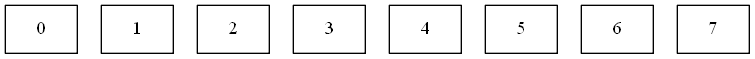

In [13]:
df.visualize()

In [34]:
%%time
# for col_name in df.cols.names():
df.ext.profile(columns=df.cols.names(), infer=True, output="json", flush=True)

Wall time: 6.39 s


'{"columns": {"INCIDENT_NUMBER": {"stats": {"mismatch": 0, "missing": 0, "match": 159537, "frequency": [{"value": "I162030584", "count": 13}, {"value": "I152080623", "count": 11}, {"value": "I172013170", "count": 10}, {"value": "I182065208", "count": 10}, {"value": "I172096394", "count": 10}, {"value": "I162071327", "count": 9}, {"value": "I162001871", "count": 9}, {"value": "I172056883", "count": 9}, {"value": "I172022524", "count": 9}, {"value": "I172054429", "count": 9}, {"value": "I162098170", "count": 9}, {"value": "I162078338", "count": 8}, {"value": "I162074826", "count": 8}, {"value": "I162090278", "count": 8}, {"value": "I172069723", "count": 8}, {"value": "I162022140", "count": 8}, {"value": "I130041200-00", "count": 8}, {"value": "I162087224", "count": 8}, {"value": "I152076465", "count": 8}, {"value": "I162056703", "count": 8}, {"value": "I162064331", "count": 8}, {"value": "I162082917", "count": 8}, {"value": "I152105431", "count": 8}, {"value": "I172053616", "count": 8}, 

In [333]:
op.client

<Client: 'inproc://192.168.86.236/2144/9' processes=1 threads=8, memory=3.00 GB>

In [11]:
columns = df.cols.names()
cols_to_profile = df.ext.calculate_cols_to_profile(df, columns)
cols_and_inferred_dtype = df.cols.infer_profiler_dtypes(cols_to_profile)              
df = df.cols.cast_to_profiler_dtypes(columns=cols_and_inferred_dtype).persist()

In [14]:
print(cols_and_inferred_dtype)

{'STREET': 'string', 'YEAR': 'int', 'Location': 'array', 'REPORTING_AREA': 'int', 'DISTRICT': 'string', 'DAY_OF_WEEK': 'int', 'OFFENSE_CODE': 'int', 'Lat': 'decimal', 'INCIDENT_NUMBER': 'string', 'Long': 'decimal', 'OFFENSE_CODE_GROUP': 'string', 'UCR_PART': 'string', 'OCCURRED_ON_DATE': 'int', 'HOUR': 'int', 'SHOOTING': 'object', 'OFFENSE_DESCRIPTION': 'string', 'MONTH': 'int'}


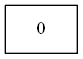

In [12]:
df.visualize()

TypeError: partitions() takes 0 positional arguments but 1 was given

In [ ]:
%%time
df.ext.profile(columns="*", infer=True, output="json", flush=True)

In [12]:
df.visualize()

AttributeError: 'DataFrame' object has no attribute 'visualize'

In [19]:
bins = 33
compute = False
if numeric_cols is not None:
    hist = df.cols.hist(numeric_cols, buckets=bins, compute=compute)
    freq_uniques = df.cols.count_uniques(numeric_cols, estimate=False, compute=compute)
freq = None
if string_cols is not None:
    freq = df.cols.frequency(string_cols, n=bins, count_uniques=True, compute=compute)

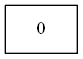

In [25]:
hist.visualize()
freq.visualize()

df.visualize()

In [11]:
df.ext.display()

In [9]:
from dateutil.parser import parse as dparse
dparse("Sunday")

datetime.datetime(2020, 5, 24, 0, 0)

In [ ]:
df.cols.cast("")

In [6]:
df = df.cols.nest(["OFFENSE_CODE_GROUP", "OFFENSE_DESCRIPTION"], separator=", ", output_col="OFFENSE_CODE_GROUP_OFFENSE_DESCRIPTION").ext.cache()
_output = df.ext.profile(columns="*", infer=True, output="json")


TypeError: unhashable type: 'list'

In [ ]:
# for i in df.columns:
#     df.cols.count_mismatch({i:"int"})

In [145]:
df.ext.profile(columns="*", infer=True, flush=True)["columns"]["birth"]

columns {'INCIDENT_NUMBER': 'string', 'OFFENSE_CODE': 'int', 'OFFENSE_CODE_GROUP': 'string', 'OFFENSE_DESCRIPTION': 'string', 'DISTRICT': 'string', 'REPORTING_AREA': 'int', 'SHOOTING': 'object', 'OCCURRED_ON_DATE': 'date', 'YEAR': 'int', 'MONTH': 'int', 'DAY_OF_WEEK': 'date', 'HOUR': 'int', 'UCR_PART': 'string', 'STREET': 'string', 'Lat': 'decimal', 'Long': 'decimal', 'Location': 'array'}
dtype--- object
dtype--- int
dtype--- object
dtype--- object
dtype--- object
dtype--- int
dtype--- object
dtype--- date
dtype--- int
dtype--- int
dtype--- date
dtype--- int
dtype--- object
dtype--- object
dtype--- float
dtype--- float
dtype--- object


KeyError: 'birth'

In [142]:

df = df.cols.nest(["OFFENSE_CODE_GROUP", "OFFENSE_DESCRIPTION"], separator=", ", output_col="OFFENSE_CODE_GROUP_OFFENSE_DESCRIPTION").ext.cache()
_output = df.ext.profile(columns="*", infer=True, output="json")


ValueError: 'missing_columns' must be 'id', 'firstName', 'lastName', 'billingId', 'product', 'price', 'birth', 'dummyCol', received '['OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION']'. 

In [134]:
df.compute()

id             firstName              lastName billingId     product  \
0    1                  Luis           Alvarez$$%!       123        Cake   
1    2                 André                Ampère       423        piza   
2    3                 NiELS            Böhr//((%%       551       pizza   
3    4                  PAUL                dirac$       521       pizza   
4    5                Albert              Einstein       634       pizza   
5    6               Galileo               GALiLEI       672       arepa   
6    7                  CaRL              Ga%%%uss       323        taco   
7    8                 David            H$$$ilbert       624    taaaccoo   
8    9              Johannes                KEPLER       735        taco   
9   10                 JaMES           M$$ax%%well       875        taco   
10  11                 Isaac                Newton       992       pasta   
11  12                Emmy%%              Nöether$       234       pasta   
12  13                Max!!!             Planck!!!       111  hamburguer   
13  14                  Fred              Hoy&&&le       553      pizzza   
14  15  (((   Heinrich )))))                 Hertz       116       pizza   
15  16               William            Gilbert###       886        BEER   
16  17                 Marie                 CURIE       912        Rice   
17  18                Arthur            COM%%%pton       812      110790   
18  19                 JAMES              Chadwick       467         NaN   

   price      birth dummyCol  
0     10 1980-07-07    never  
1      8 1950-07-08    gonna  
2      8 1990-07-09     give  
3      8 1954-07-10      you  
4      8 1990-07-11       up  
5      5 1930-08-12    never  
6      3 1970-07-13    gonna  
7      3 1950-07-14      let  
8      3 1920-04-22      you  
9      3 1923-03-12     down  
10     9 1999-02-15   never   
11     9 1993-12-08    gonna  
12     4 1994-01-04     run   
13     8 1997-06-27   around  
14     8 1956-11-30      and  
15     2 1958-03-26   desert  
16     1 2000-03-22      you  
17     5 1899-01-01        #  
18    10 1921-05-03        #

In [135]:
import pandas as pd
for i in df["birth"]:    
    print(i.year, i.month, i.day, i.hour, i.minute, i.second, i.weekday(), i.weekofyear)
dir(i)

1980 7 7 0 0 0 0 28
1950 7 8 0 0 0 5 27
1990 7 9 0 0 0 0 28
1954 7 10 0 0 0 5 27
1990 7 11 0 0 0 2 28
1930 8 12 0 0 0 1 33
1970 7 13 0 0 0 0 29
1950 7 14 0 0 0 4 28
1920 4 22 0 0 0 3 17
1923 3 12 0 0 0 0 11
1999 2 15 0 0 0 0 7
1993 12 8 0 0 0 2 49
1994 1 4 0 0 0 1 1
1997 6 27 0 0 0 4 26
1956 11 30 0 0 0 4 48
1958 3 26 0 0 0 2 13
2000 3 22 0 0 0 2 12
1899 1 1 0 0 0 6 52
1921 5 3 0 0 0 1 18


['__add__',
 '__array_priority__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rsub__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '_date_attributes',
 '_date_repr',
 '_get_date_name_field',
 '_get_start_end_field',
 '_has_time_component',
 '_repr_base',
 '_round',
 '_short_repr',
 '_time_repr',
 'asm8',
 'astimezone',
 'ceil',
 'combine',
 'ctime',
 'date',
 'day',
 'day_name',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'daysinmonth',
 'dst',
 'floor',
 'fold',
 'freq',
 'freqstr',
 'fromisoformat',
 'fromordinal',
 'fromtimestamp',
 'hour',
 'is_leap_year',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_

In [138]:
df.cols.year("birth", output_cols="new_birth").compute()

id             firstName              lastName billingId     product  \
0    1                  Luis           Alvarez$$%!       123        Cake   
1    2                 André                Ampère       423        piza   
2    3                 NiELS            Böhr//((%%       551       pizza   
3    4                  PAUL                dirac$       521       pizza   
4    5                Albert              Einstein       634       pizza   
5    6               Galileo               GALiLEI       672       arepa   
6    7                  CaRL              Ga%%%uss       323        taco   
7    8                 David            H$$$ilbert       624    taaaccoo   
8    9              Johannes                KEPLER       735        taco   
9   10                 JaMES           M$$ax%%well       875        taco   
10  11                 Isaac                Newton       992       pasta   
11  12                Emmy%%              Nöether$       234       pasta   
12  13                Max!!!             Planck!!!       111  hamburguer   
13  14                  Fred              Hoy&&&le       553      pizzza   
14  15  (((   Heinrich )))))                 Hertz       116       pizza   
15  16               William            Gilbert###       886        BEER   
16  17                 Marie                 CURIE       912        Rice   
17  18                Arthur            COM%%%pton       812      110790   
18  19                 JAMES              Chadwick       467         NaN   

   price      birth dummyCol  new_birth  
0     10 1980-07-07    never       1980  
1      8 1950-07-08    gonna       1950  
2      8 1990-07-09     give       1990  
3      8 1954-07-10      you       1954  
4      8 1990-07-11       up       1990  
5      5 1930-08-12    never       1930  
6      3 1970-07-13    gonna       1970  
7      3 1950-07-14      let       1950  
8      3 1920-04-22      you       1920  
9      3 1923-03-12     down       1923  
10     9 1999-02-15   never        1999  
11     9 1993-12-08    gonna       1993  
12     4 1994-01-04     run        1994  
13     8 1997-06-27   around       1997  
14     8 1956-11-30      and       1956  
15     2 1958-03-26   desert       1958  
16     1 2000-03-22      you       2000  
17     5 1899-01-01        #       1899  
18    10 1921-05-03        #       1921

In [117]:
df["birth"].dt

AttributeError: Can only use .dt accessor with datetimelike values

In [31]:
from dateutil.parser import parse as dparse
type(dparse("1"))

datetime.datetime

In [36]:
# for col_name in df.cols.names():
#     print(col_name)


{'stats': {'mismatch': 0,
  'missing': 0,
  'match': 19,
  'frequency': [{'value': '2000/03/22', 'count': 1},
   {'value': '1999/02/15', 'count': 1},
   {'value': '1997/06/27', 'count': 1},
   {'value': '1994/01/04', 'count': 1},
   {'value': '1993/12/08', 'count': 1},
   {'value': '1990/07/11', 'count': 1},
   {'value': '1990/07/09', 'count': 1},
   {'value': '1980/07/07', 'count': 1},
   {'value': '1970/07/13', 'count': 1},
   {'value': '1958/03/26', 'count': 1},
   {'value': '1956/11/30', 'count': 1},
   {'value': '1954/07/10', 'count': 1},
   {'value': '1950/07/14', 'count': 1},
   {'value': '1950/07/08', 'count': 1},
   {'value': '1930/08/12', 'count': 1},
   {'value': '1923/03/12', 'count': 1},
   {'value': '1921/05/03', 'count': 1},
   {'value': '1920/04/22', 'count': 1},
   {'value': '1899/01/01', 'count': 1}],
  'count_uniques': 19},
 'dtype': 'object',
 'profiler_dtype': 'date'}

In [27]:
df.compute()

id             firstName              lastName billingId     product  \
0    1                  Luis           Alvarez$$%!       123        Cake   
1    2                 André                Ampère       423        piza   
2    3                 NiELS            Böhr//((%%       551       pizza   
3    4                  PAUL                dirac$       521       pizza   
4    5                Albert              Einstein       634       pizza   
5    6               Galileo               GALiLEI       672       arepa   
6    7                  CaRL              Ga%%%uss       323        taco   
7    8                 David            H$$$ilbert       624    taaaccoo   
8    9              Johannes                KEPLER       735        taco   
9   10                 JaMES           M$$ax%%well       875        taco   
10  11                 Isaac                Newton       992       pasta   
11  12                Emmy%%              Nöether$       234       pasta   
12  13                Max!!!             Planck!!!       111  hamburguer   
13  14                  Fred              Hoy&&&le       553      pizzza   
14  15  (((   Heinrich )))))                 Hertz       116       pizza   
15  16               William            Gilbert###       886        BEER   
16  17                 Marie                 CURIE       912        Rice   
17  18                Arthur            COM%%%pton       812      110790   
18  19                 JAMES              Chadwick       467         NaN   

   price      birth dummyCol  
0     10 1980-07-07    never  
1      8 1950-07-08    gonna  
2      8 1990-07-09     give  
3      8 1954-07-10      you  
4      8 1990-07-11       up  
5      5 1930-08-12    never  
6      3 1970-07-13    gonna  
7      3 1950-07-14      let  
8      3 1920-04-22      you  
9      3 1923-03-12     down  
10     9 1999-02-15   never   
11     9 1993-12-08    gonna  
12     4 1994-01-04     run   
13     8 1997-06-27   around  
14     8 1956-11-30      and  
15     2 1958-03-26   desert  
16     1 2000-03-22      you  
17     5 1899-01-01        #  
18    10 1921-05-03        #

In [26]:
import arrow
date = 1
arrow.get(date)

<Arrow [1970-01-01T00:00:01+00:00]>

In [29]:
from dateutil.parser import parse as dparse
dparse("10")

datetime.datetime(2020, 5, 10, 0, 0)

In [6]:
df.compute()

INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_CODE_GROUP  \
0           I182070945           619               Larceny   
1           I182070943          1402             Vandalism   
2           I182070941          3410                 Towed   
3           I182070940          3114  Investigate Property   
4           I182070938          3114  Investigate Property   
...                ...           ...                   ...   
319068   I050310906-00          3125       Warrant Arrests   
319069   I030217815-08           111              Homicide   
319070   I030217815-08          3125       Warrant Arrests   
319071   I010370257-00          3125       Warrant Arrests   
319072       142052550          3125       Warrant Arrests   

                        OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
0                        LARCENY ALL OTHERS      D14            808      NaN   
1                                 VANDALISM      C11            347      NaN   
2                       TOWED MOTOR VEHICLE       D4            151      NaN   
3                      INVESTIGATE PROPERTY       D4            272      NaN   
4                      INVESTIGATE PROPERTY       B3            421      NaN   
...                                     ...      ...            ...      ...   
319068                       WARRANT ARREST       D4            285      NaN   
319069  MURDER, NON-NEGLIGIENT MANSLAUGHTER      E18            520      NaN   
319070                       WARRANT ARREST      E18            520      NaN   
319071                       WARRANT ARREST      E13            569      NaN   
319072                       WARRANT ARREST       D4            903      NaN   

           OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR    UCR_PART  \
0       2018-09-02 13:00:00  2018      9      Sunday    13    Part One   
1       2018-08-21 00:00:00  2018      8     Tuesday     0    Part Two   
2       2018-09-03 19:27:00  2018      9      Monday    19  Part Three   
3       2018-09-03 21:16:00  2018      9      Monday    21  Part Three   
4       2018-09-03 21:05:00  2018      9      Monday    21  Part Three   
...                     ...   ...    ...         ...   ...         ...   
319068  2016-06-05 17:25:00  2016      6      Sunday    17  Part Three   
319069  2015-07-09 13:38:00  2015      7    Thursday    13    Part One   
319070  2015-07-09 13:38:00  2015      7    Thursday    13  Part Three   
319071  2016-05-31 19:35:00  2016      5     Tuesday    19  Part Three   
319072  2015-06-22 00:12:00  2015      6      Monday     0  Part Three   

                   STREET          Lat          Long  \
0              LINCOLN ST  42.35779134  -71.13937053   
1                HECLA ST  42.30682138  -71.06030035   
2             CAZENOVE ST  42.34658879  -71.07242943   
3              NEWCOMB ST  42.33418175  -71.07866441   
4                DELHI ST  42.27536542  -71.09036101   
...                   ...          ...           ...   
319068        COVENTRY ST  42.33695098  -71.08574813   
319069           RIVER ST  42.25592648  -71.12317207   
319070           RIVER ST  42.25592648  -71.12317207   
319071  NEW WASHINGTON ST  42.30233307  -71.11156487   
319072      WASHINGTON ST  42.33383935  -71.08029038   

                           Location  
0       (42.35779134, -71.13937053)  
1       (42.30682138, -71.06030035)  
2       (42.34658879, -71.07242943)  
3       (42.33418175, -71.07866441)  
4       (42.27536542, -71.09036101)  
...                             ...  
319068  (42.33695098, -71.08574813)  
319069  (42.25592648, -71.12317207)  
319070  (42.25592648, -71.12317207)  
319071  (42.30233307, -71.11156487)  
319072  (42.33383935, -71.08029038)  

[319073 rows x 17 columns]

columns {'SHOOTING': 'object'}
_dtype object
cols_and_inferred_dtype {'SHOOTING': 'object'}


'{"columns": {"SHOOTING": {"stats": {"mismatch": 1019, "missing": 318054, "match": 0, "frequency": [{"value": "Y", "count": 1019}], "count_uniques": 1}, "dtype": "object", "profiler_dtype": "object"}}, "name": null, "file_name": "crime.csv", "summary": {"cols_count": 17, "rows_count": 319073, "size": "35.1 MB", "dtypes_list": ["uint16", "object", "uint8"], "total_count_dtypes": 3, "missing_count": 318054, "p_missing": 99.68}}'

In [8]:
_output = preview_df.ext.profile(columns="*", infer=True, output="json")


NameError: name 'preview_df' is not defined

In [51]:
# df = op.load.csv("http://159.65.217.17:5003/uploads/datasetFile-1589815911139.csv", sep=",", error_bad_lines=False, header=True, null_value="null", infer_schema="true", encoding="UTF-8", quoting=0, lineterminator=None, cache=True).ext.cache()
# df = op.load.csv("http://159.65.217.17:5003/uploads/datasetFile-1590006020188.csv", sep=",", error_bad_lines=False, header=True, null_value="null", infer_schema="true", encoding="UTF-8", quoting=0, lineterminator=None, cache=True).ext.cache()
# df = op.load.file("data/dataset - transactions.csv").ext.cache()
# df = op.load.file("data/crime.csv", n_rows=10).ext.cache()
df = op.load.file("data/foo.csv", n_rows=10).ext.cache()


df = df.ext.optimize()


In [56]:
df.compute()

id firstName              lastName  billingId   product  price       birth  \
0   1      Luis           Alvarez$$%!        123      Cake     10  1980/07/07   
1   2     André                Ampère        423      piza      8  1950/07/08   
2   3     NiELS            Böhr//((%%        551     pizza      8  1990/07/09   
3   4      PAUL                dirac$        521     pizza      8  1954/07/10   
4   5    Albert              Einstein        634     pizza      8  1990/07/11   
5   6   Galileo               GALiLEI        672     arepa      5  1930/08/12   
6   7      CaRL              Ga%%%uss        323      taco      3  1970/07/13   
7   8     David            H$$$ilbert        624  taaaccoo      3  1950/07/14   
8   9  Johannes                KEPLER        735      taco      3  1920/04/22   
9  10     JaMES           M$$ax%%well        875      taco      3  1923/03/12   

  dummyCol  
0    never  
1    gonna  
2     give  
3      you  
4       up  
5    never  
6    gonna  
7      let  
8      you  
9     down

In [76]:
df.ext.profile(columns="*", infer=True,)

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 30 elements requested, only 19 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


columns {'id': 'int', 'firstName': 'string', 'lastName': 'string', 'billingId': 'int', 'product': 'string', 'price': 'int', 'birth': 'date', 'dummyCol': 'string'}
dtype--- int
dtype--- object
dtype--- object
dtype--- int
dtype--- object
dtype--- int
dtype--- date
dtype--- object


{'columns': {'id': {'stats': {'mismatch': 0,
    'missing': 0,
    'match': 19,
    'hist': [{'lower': 1.0, 'upper': 1.5625, 'count': 1},
     {'lower': 1.5625, 'upper': 2.125, 'count': 1},
     {'lower': 2.125, 'upper': 2.6875, 'count': 0},
     {'lower': 2.6875, 'upper': 3.25, 'count': 1},
     {'lower': 3.25, 'upper': 3.8125, 'count': 0},
     {'lower': 3.8125, 'upper': 4.375, 'count': 1},
     {'lower': 4.375, 'upper': 4.9375, 'count': 0},
     {'lower': 4.9375, 'upper': 5.5, 'count': 1},
     {'lower': 5.5, 'upper': 6.0625, 'count': 1},
     {'lower': 6.0625, 'upper': 6.625, 'count': 0},
     {'lower': 6.625, 'upper': 7.1875, 'count': 1},
     {'lower': 7.1875, 'upper': 7.75, 'count': 0},
     {'lower': 7.75, 'upper': 8.3125, 'count': 1},
     {'lower': 8.3125, 'upper': 8.875, 'count': 0},
     {'lower': 8.875, 'upper': 9.4375, 'count': 1},
     {'lower': 9.4375, 'upper': 10.0, 'count': 0},
     {'lower': 10.0, 'upper': 10.5625, 'count': 1},
     {'lower': 10.5625, 'upper': 11.125

In [46]:
df = df.cols.nest(["firstName", "lastName"], separator=", ", output_col="firstName_lastName").ext.cache()
_output = df.ext.profile(columns="*", infer=True, output="json")

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 30 elements requested, only 10 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [47]:
print(_output)

{"columns": {"id": {"stats": {"mismatch": 0, "missing": 0, "match": 10, "hist": [{"lower": 1.0, "upper": 1.28125, "count": 1}, {"lower": 1.28125, "upper": 1.5625, "count": 0}, {"lower": 1.5625, "upper": 1.84375, "count": 0}, {"lower": 1.84375, "upper": 2.125, "count": 1}, {"lower": 2.125, "upper": 2.40625, "count": 0}, {"lower": 2.40625, "upper": 2.6875, "count": 0}, {"lower": 2.6875, "upper": 2.96875, "count": 0}, {"lower": 2.96875, "upper": 3.25, "count": 1}, {"lower": 3.25, "upper": 3.53125, "count": 0}, {"lower": 3.53125, "upper": 3.8125, "count": 0}, {"lower": 3.8125, "upper": 4.09375, "count": 1}, {"lower": 4.09375, "upper": 4.375, "count": 0}, {"lower": 4.375, "upper": 4.65625, "count": 0}, {"lower": 4.65625, "upper": 4.9375, "count": 0}, {"lower": 4.9375, "upper": 5.21875, "count": 1}, {"lower": 5.21875, "upper": 5.5, "count": 0}, {"lower": 5.5, "upper": 5.78125, "count": 0}, {"lower": 5.78125, "upper": 6.0625, "count": 1}, {"lower": 6.0625, "upper": 6.34375, "count": 0}, {"low

In [50]:
df.ext.display()

In [42]:
df = df.cols.nest(["firstName","lastName"],output_col="lastName1", separator = ",")

In [43]:
df.ext.profile(columns="*", infer=True, output="json", flush=True)

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 30 elements requested, only 10 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


'{"columns": {"id": {"stats": {"mismatch": 0, "missing": 0, "match": 10, "hist": [{"lower": 1.0, "upper": 1.28125, "count": 1}, {"lower": 1.28125, "upper": 1.5625, "count": 0}, {"lower": 1.5625, "upper": 1.84375, "count": 0}, {"lower": 1.84375, "upper": 2.125, "count": 1}, {"lower": 2.125, "upper": 2.40625, "count": 0}, {"lower": 2.40625, "upper": 2.6875, "count": 0}, {"lower": 2.6875, "upper": 2.96875, "count": 0}, {"lower": 2.96875, "upper": 3.25, "count": 1}, {"lower": 3.25, "upper": 3.53125, "count": 0}, {"lower": 3.53125, "upper": 3.8125, "count": 0}, {"lower": 3.8125, "upper": 4.09375, "count": 1}, {"lower": 4.09375, "upper": 4.375, "count": 0}, {"lower": 4.375, "upper": 4.65625, "count": 0}, {"lower": 4.65625, "upper": 4.9375, "count": 0}, {"lower": 4.9375, "upper": 5.21875, "count": 1}, {"lower": 5.21875, "upper": 5.5, "count": 0}, {"lower": 5.5, "upper": 5.78125, "count": 0}, {"lower": 5.78125, "upper": 6.0625, "count": 1}, {"lower": 6.0625, "upper": 6.34375, "count": 0}, {"lo

In [44]:
df.compute()

id firstName              lastName                     lastName1  \
0   1      Luis           Alvarez$$%!              Luis,Alvarez$$%!   
1   2     André                Ampère                  André,Ampère   
2   3     NiELS            Böhr//((%%              NiELS,Böhr//((%%   
3   4      PAUL                dirac$                   PAUL,dirac$   
4   5    Albert              Einstein               Albert,Einstein   
5   6   Galileo               GALiLEI  Galileo,             GALiLEI   
6   7      CaRL              Ga%%%uss                 CaRL,Ga%%%uss   
7   8     David            H$$$ilbert              David,H$$$ilbert   
8   9  Johannes                KEPLER               Johannes,KEPLER   
9  10     JaMES           M$$ax%%well             JaMES,M$$ax%%well   

   billingId   product  price       birth dummyCol  
0        123      Cake     10  1980/07/07    never  
1        423      piza      8  1950/07/08    gonna  
2        551     pizza      8  1990/07/09     give  
3        521     pizza      8  1954/07/10      you  
4        634     pizza      8  1990/07/11       up  
5        672     arepa      5  1930/08/12    never  
6        323      taco      3  1970/07/13    gonna  
7        624  taaaccoo      3  1950/07/14      let  
8        735      taco      3  1920/04/22      you  
9        875      taco      3  1923/03/12     down

In [35]:
df.ext.profile(columns="*", infer=True, output="json", flush=True)

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 30 elements requested, only 10 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


'{"columns": {"id": {"stats": {"mismatch": 0, "missing": 0, "match": 10, "hist": [{"lower": 1.0, "upper": 1.28125, "count": 1}, {"lower": 1.28125, "upper": 1.5625, "count": 0}, {"lower": 1.5625, "upper": 1.84375, "count": 0}, {"lower": 1.84375, "upper": 2.125, "count": 1}, {"lower": 2.125, "upper": 2.40625, "count": 0}, {"lower": 2.40625, "upper": 2.6875, "count": 0}, {"lower": 2.6875, "upper": 2.96875, "count": 0}, {"lower": 2.96875, "upper": 3.25, "count": 1}, {"lower": 3.25, "upper": 3.53125, "count": 0}, {"lower": 3.53125, "upper": 3.8125, "count": 0}, {"lower": 3.8125, "upper": 4.09375, "count": 1}, {"lower": 4.09375, "upper": 4.375, "count": 0}, {"lower": 4.375, "upper": 4.65625, "count": 0}, {"lower": 4.65625, "upper": 4.9375, "count": 0}, {"lower": 4.9375, "upper": 5.21875, "count": 1}, {"lower": 5.21875, "upper": 5.5, "count": 0}, {"lower": 5.5, "upper": 5.78125, "count": 0}, {"lower": 5.78125, "upper": 6.0625, "count": 1}, {"lower": 6.0625, "upper": 6.34375, "count": 0}, {"lo

In [36]:
df.ext.display()

In [533]:
# df[["customer_id", "product"]]

In [534]:
from dask import dataframe as dd
import pandas as pd
data = {"customer_id_x":["0f345kjh345oiuy345"], "transactoin_date":["hola"]}
pdf = pd.DataFrame(data)
print(pdf)
df_right = dd.from_pandas(pdf, npartitions=1)

        customer_id_x transactoin_date
0  0f345kjh345oiuy345             hola


In [535]:
df.ext.display()

In [536]:
df.cols.join(df_right,how="left", left_on="customer_id", right_on="customer_id_x").ext.display(100)

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 100 elements requested, only 17 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [537]:
data = {"customer_id":["0f345kjh345oiuy345"], "transactoin_date":["hola"]}
pdf = pd.DataFrame(data)
# print(pdf)
df_right = dd.from_pandas(pdf, npartitions=1)

In [538]:
df.cols.join(df_right,how="inner", left_on="customer_id", right_on="customer_id")

Dask DataFrame Structure:
              transactoin_date_left ticket_price discount product customer_id   info transactoin_date_right
npartitions=1                                                                                              
                             object       object   object  object      object  uint8                 object
                                ...          ...      ...     ...         ...    ...                    ...
Dask Name: getitem, 14 tasks

In [530]:
test_df.compute()

transactoin_date_left ticket_price discount   product         customer_id  \
0            2010/08/19        29.99      NaN  platinum  0f345kjh345oiuy345   

   info transactoin_date_right  
0     1                   hola

In [490]:
# z = test_df.cols.count()
# lz = test_df.cols.names()
lz = test_df.cols.count()

li =  df.cols.count()
lj = df_right.cols.count()
print(lz-lj)
test_df.cols.names()[:li] + ["customer_id"]+test_df.cols.names()[lz-lj:lz]


6


['transactoin_date_left',
 'ticket_price',
 'discount',
 'product',
 'info',
 'customer_id',
 'customer_id',
 'info',
 'transactoin_date_right']

['transactoin_date_left',
 'ticket_price',
 'discount',
 'product',
 'info',
 'info',
 'transactoin_date_right']

In [ ]:
'customer_id', 'transactoin_date', 'ticket_price', 'discount', 'product', 'info', 'A', 'B'

In [252]:
df.ext.display()

In [189]:
df = df.cols.replace("discount", search=["%"], replace_by="", search_by="chars", ignore_case=True, output_cols="discount").ext.cache()
df.ext.display()
# pdf = df.compute()
# print("AAAAA",df.ext.profile(columns="*", infer=True)["columns"]["discount"])

In [190]:
for i in pdf["discount"]:
    print(i, type(i))

nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
5 <class 'str'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
5 <class 'str'>
5 <class 'str'>
nan <class 'float'>
nan <class 'float'>
5 <class 'str'>
nan <class 'float'>
5 <class 'str'>
nan <class 'float'>


In [191]:
pdf.cols.profiler_dtypes("*")

{'customer_id': None,
 'transactoin_date': None,
 'ticket_price': None,
 'discount': None,
 'product': None,
 'info': None}

In [192]:
df.ext.display()

In [193]:
df.cols.count_mismatch({"discount":"int"})

BBBB {'discount': 'int'}
result {'discount': {'mismatch': 0, 'missing': 12, 'match': 5, 'profiler_dtype': 'int'}}


{'discount': {'mismatch': 0,
  'missing': 12,
  'match': 5,
  'profiler_dtype': 'int'}}

In [95]:
df.cols.frequency("first_name", count_uniques = True)

ValueError: 'missing_columns' must be 'customer_id', 'transactoin_date', 'ticket_price', 'discount', 'product', 'info', received 'first_name'. 

In [75]:
%timeit df.ext.profile("*")

3.57 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
df.cols.count_uniques("customer_id")

{'customer_id': {'count_uniques': 1}}

In [62]:
df.cols.profiler_dtypes("*")

{'customer_id': None,
 'first_name': None,
 'last_name': None,
 'current_credit_card': None,
 'address_zip': None,
 'email': None,
 'address_street_number': None,
 'address_city': None,
 'address_state': None,
 'adress_zip': None,
 'phone_number': None,
 'start_date': None,
 'end_date': None,
 'transaction_date': None,
 'ticket_price': None,
 'discount': None,
 'discounted_ticket_price': None}

In [66]:
# for col_name in df.cols.names():
#     print(col_name)
df.ext.profile("*")

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:433: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):
C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 30 elements requested, only 9 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


result {'customer_id': {'mismatch': 0, 'missing': 9, 'match': 0, 'profiler_dtype': 'object'}, 'first_name': {'mismatch': 0, 'missing': 0, 'match': 9, 'profiler_dtype': 'string'}, 'last_name': {'mismatch': 0, 'missing': 0, 'match': 9, 'profiler_dtype': 'string'}, 'current_credit_card': {'mismatch': 0, 'missing': 0, 'match': 9, 'profiler_dtype': 'string'}, 'address_zip': {'mismatch': 0, 'missing': 0, 'match': 9, 'profiler_dtype': 'string'}, 'email': {'mismatch': 0, 'missing': 0, 'match': 9, 'profiler_dtype': 'email'}, 'address_street_number': {'mismatch': 0, 'missing': 0, 'match': 9, 'profiler_dtype': 'string'}, 'address_city': {'mismatch': 0, 'missing': 0, 'match': 9, 'profiler_dtype': 'string'}, 'address_state': {'mismatch': 0, 'missing': 0, 'match': 9, 'profiler_dtype': 'string'}, 'adress_zip': {'mismatch': 0, 'missing': 0, 'match': 9, 'profiler_dtype': 'string'}, 'phone_number': {'mismatch': 0, 'missing': 0, 'match': 9, 'profiler_dtype': 'string'}, 'start_date': {'mismatch': 9, 'miss

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:433: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):


{'columns': {'customer_id': {'stats': {'mismatch': 0,
    'missing': 9,
    'match': 0,
    'hist': [{'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lower': nan, 'upper': nan, 'count': 0},
     {'lowe

In [45]:
a = ({'customer_id': 'object', 'first_name': 'string', 'last_name': 'string', 'current_credit_card': 'credit_card_number', 
      
      })
mismatch = df.cols.count_mismatch(a, infer=True)
print(mismatch)

{'customer_id': {'mismatch': 0, 'missing': 9, 'match': 0, 'profiler_dtype': 'object'}, 'first_name': {'mismatch': 0, 'missing': 0, 'match': 9, 'profiler_dtype': 'string'}, 'last_name': {'mismatch': 0, 'missing': 0, 'match': 9, 'profiler_dtype': 'string'}, 'current_credit_card': {'mismatch': 9, 'missing': 0, 'match': 0, 'profiler_dtype': 'credit_card_number'}}


In [ ]:
df.cols.cast("email", object).compute()

In [69]:
df.cols.profiler_dtypes("*")

{'customer_id': None,
 'transactoin_date': None,
 'ticket_price': None,
 'discount': None,
 'product': None}

In [70]:
df.ext.profile(columns="*", infer=True)

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 30 elements requested, only 17 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


{'columns': {'customer_id': {'stats': {'mismatch': 0,
    'missing': 0,
    'match': 17,
    'frequency': [{'value': '0fju234978rfjkhsdf', 'count': 4},
     {'value': '0f34ruiy23e78y2r', 'count': 4},
     {'value': '0fue298y2r23r23r5', 'count': 1},
     {'value': '0fue298y2r23r23r4', 'count': 1},
     {'value': '0fue298y2r23r23r3', 'count': 1},
     {'value': '0fue298y2r23r23r2', 'count': 1},
     {'value': '0f345kjh345oiuy349', 'count': 1},
     {'value': '0f345kjh345oiuy348', 'count': 1},
     {'value': '0f345kjh345oiuy347', 'count': 1},
     {'value': '0f345kjh345oiuy346', 'count': 1},
     {'value': '0f345kjh345oiuy345', 'count': 1}],
    'count_uniques': 11},
   'dtype': 'object',
   'profiler_dtype': 'string'},
  'transactoin_date': {'stats': {'mismatch': 0,
    'missing': 6,
    'match': 11,
    'frequency': [{'value': '2010/08/19', 'count': 7},
     {'value': '2015/08/09', 'count': 1},
     {'value': '2012/01/05', 'count': 1},
     {'value': '2011/08/11', 'count': 1},
     {'va

In [71]:
df.cols.profiler_dtypes("*")

{'customer_id': 'string',
 'transactoin_date': 'date',
 'ticket_price': 'decimal',
 'discount': 'string',
 'product': 'string'}

In [72]:
_output = df.ext.profile(columns="*", infer=True, output="json")
df.ext.set_buffer("*")
df = df.cols.replace("discount", search=["%"], replace_by="", search_by="chars", ignore_case=True, output_cols="discount").ext.cache()

_output = df.ext.profile(columns="*",  output="json")
df.ext.display()

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 17 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))
C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 30 elements requested, only 17 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [73]:
df.cols.profiler_dtypes("*")

{'customer_id': 'string',
 'transactoin_date': 'date',
 'ticket_price': 'decimal',
 'discount': 'int',
 'product': 'string'}

In [13]:
pdf= df.compute()
for i in pdf["discount"]:
    print(type(i))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'int'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'int'>
<class 'int'>
<class 'float'>
<class 'float'>
<class 'int'>
<class 'float'>
<class 'int'>
<class 'float'>


In [50]:

# df.ext.set_buffer("*")

# df = df.cols.set( value="0", where='df["discount"].isnull()', output_cols=["discount"] ).ext.cache()
# _output = df.ext.profile(columns="*", infer=True, output="json")

# df.ext.set_buffer("*")

df = df.cols.set(value='0', where='df["discount"].isnull()', output_cols="discount").ext.cache()
df.ext.profile(columns="*", infer=True)["columns"]["discount"]
# df.ext.set_buffer("*") # error 
# print(df.ext.buffer_window("*", 0, 17).ext.to_json("*")) # error

ASDASDF
AAA {'discount': 'int'}


C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 30 elements requested, only 17 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


{'stats': {'mismatch': 0,
  'missing': 0,
  'match': 17,
  'frequency': [{'value': 0, 'count': 12}, {'value': 5, 'count': 5}],
  'count_uniques': 2},
 'dtype': 'object',
 'profiler_dtype': 'int'}

In [65]:
df.ext.set_buffer("*")

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 17 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [66]:
profile_preview = df.ext.buffer_window("*", 0, 17).cols.set(value='mask["discount"]*mask["ticket_price"]', where='df["discount"]!=None', output_cols="new column")

In [67]:
profile_preview

customer_id transactoin_date ticket_price discount   product  \
0   0f345kjh345oiuy345       2010/08/19        29.99        0  platinum   
1   0fju234978rfjkhsdf       2012/01/05        29.99        0  platinum   
2     0f34ruiy23e78y2r       2009/08/11        29.99        0  platinum   
3    0fue298y2r23r23r2       2010/08/19        29.99        0  platinum   
4   0f345kjh345oiuy346       2010/08/19        29.99        0  platinum   
5   0fju234978rfjkhsdf       2010/08/19         9.99        5     basic   
6     0f34ruiy23e78y2r       2010/08/19         9.99        0     basic   
7    0fue298y2r23r23r3       2010/08/19         9.99        0     basic   
8   0f345kjh345oiuy347       2010/08/19         9.99        0     basic   
9   0fju234978rfjkhsdf       2011/08/11         9.99        5     basic   
10    0f34ruiy23e78y2r       2015/08/09         9.99        5     basic   
11   0fue298y2r23r23r4             None         9.91        0     basic   
12  0f345kjh345oiuy348             None         9.99        0     basic   
13  0fju234978rfjkhsdf             None        14.99        5    deluxe   
14    0f34ruiy23e78y2r             None        14.99        0    deluxe   
15   0fue298y2r23r23r5             None        14.99        5    deluxe   
16  0f345kjh345oiuy349             None        14.99        0    deluxe   

                   new column  
0                              
1                              
2                              
3                              
4                              
5        9.999.999.999.999.99  
6                              
7                              
8                              
9        9.999.999.999.999.99  
10       9.999.999.999.999.99  
11                             
12                             
13  14.9914.9914.9914.9914.99  
14                             
15  14.9914.9914.9914.9914.99  
16

In [64]:
profile_preview.ext.profile("*")["columns"]["discount"]

{'stats': {'match': 17,
  'missing': 0,
  'mismatch': 0,
  'frequency': [{'value': 0, 'count': 12}, {'value': 5, 'count': 5}],
  'count_uniques': 2},
 'dtype': 'object'}

In [58]:
df.cols.profiler_dtypes("new_discount")

ValueError: 'missing_columns' must be 'customer_id', 'transactoin_date', 'ticket_price', 'discount', 'product', received 'new_discount'. 

customer_id transactoin_date ticket_price discount   product
0   0f345kjh345oiuy345       2010/08/19        29.99        0  platinum
1   0fju234978rfjkhsdf       2012/01/05        29.99        0  platinum
2     0f34ruiy23e78y2r       2009/08/11        29.99        0  platinum
3    0fue298y2r23r23r2       2010/08/19        29.99        0  platinum
4   0f345kjh345oiuy346       2010/08/19        29.99        0  platinum
5   0fju234978rfjkhsdf       2010/08/19         9.99        5     basic
6     0f34ruiy23e78y2r       2010/08/19         9.99        0     basic
7    0fue298y2r23r23r3       2010/08/19         9.99        0     basic
8   0f345kjh345oiuy347       2010/08/19         9.99        0     basic
9   0fju234978rfjkhsdf       2011/08/11         9.99        5     basic
10    0f34ruiy23e78y2r       2015/08/09         9.99        5     basic
11   0fue298y2r23r23r4             None         9.91        0     basic
12  0f345kjh345oiuy348             None         9.99        0     basic
13  0fju234978rfjkhsdf             None        14.99        5    deluxe
14    0f34ruiy23e78y2r             None        14.99        0    deluxe
15   0fue298y2r23r23r5             None        14.99        5    deluxe
16  0f345kjh345oiuy349             None        14.99        0    deluxe

In [29]:
df.cols.profiler_dtypes("*")

{'customer_id': 'string',
 'transactoin_date': 'date',
 'ticket_price': 'decimal',
 'discount': 'int',
 'product': 'string'}

In [33]:
# df.cols.count_mismatch({"discount":"int"}, infer=True)

In [34]:
df.ext.profile(columns="*", infer=True)["columns"]["discount"]

{'stats': {'mismatch': 0,
  'missing': 12,
  'match': 5,
  'frequency': [{'value': '5', 'count': 5}],
  'count_uniques': 1},
 'dtype': 'object',
 'profiler_dtype': 'int'}

In [91]:
df = op.load.csv("http://159.65.217.17:5003/uploads/datasetFile-1589815911139.csv", sep=",", error_bad_lines=False, header=True, null_value="null", infer_schema="true", encoding="UTF-8", quoting=0, lineterminator=None, cache=True).ext.cache()
df = df.ext.optimize()
_output = df.ext.profile(columns="*", infer=True, output="json")




df = df.cols.profiler_dtype("ticket_price", "decimal").ext.cache()
_output = df.ext.set_buffer("*")

df.ext.get_buffer()
_output = df.ext.profile(columns="*", infer=True, output="json")
_output = df.ext.set_buffer("*")
df.ext.table()

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 30 elements requested, only 17 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


TypeError: 'NoneType' object does not support item assignment

In [22]:
df.ext.get_buffer()

customer_id transactoin_date ticket_price discount   product
0   0f345kjh345oiuy345       2010/08/19        29.99      NaN  platinum
1   0fju234978rfjkhsdf       2012/01/05        29.99      NaN  platinum
2     0f34ruiy23e78y2r       2009/08/11        29.99      NaN  platinum
3    0fue298y2r23r23r2       2010/08/19        29.99      NaN  platinum
4   0f345kjh345oiuy346       2010/08/19        29.99      NaN  platinum
5   0fju234978rfjkhsdf       2010/08/19         9.99       5%     basic
6     0f34ruiy23e78y2r       2010/08/19         9.99      NaN     basic
7    0fue298y2r23r23r3       2010/08/19         9.99      NaN     basic
8   0f345kjh345oiuy347       2010/08/19         9.99      NaN     basic
9   0fju234978rfjkhsdf       2011/08/11         9.99       5%     basic
10    0f34ruiy23e78y2r       2015/08/09         9.99       5%     basic
11   0fue298y2r23r23r4              NaN         9.91      NaN     basic
12  0f345kjh345oiuy348              NaN         9.99      NaN     basic
13  0fju234978rfjkhsdf              NaN        14.99       5%    deluxe
14    0f34ruiy23e78y2r              NaN        14.99      NaN    deluxe
15   0fue298y2r23r23r5              NaN        14.99       5%    deluxe
16  0f345kjh345oiuy349              NaN        14.99      NaN    deluxe

In [23]:
df.cols.dtypes()

{'customer_id': 'category',
 'transactoin_date': 'category',
 'ticket_price': 'object',
 'discount': 'category',
 'product': 'category'}

In [24]:
pdf = df.compute()
for i in pdf["ticket_price"]:
    print(type(i))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


In [25]:
# df.ext.profile("*", infer=True)

In [26]:
df.cols.profiler_dtypes("*")

{'customer_id': 'string',
 'transactoin_date': 'date',
 'ticket_price': 'decimal',
 'discount': 'string',
 'product': 'string'}

In [27]:
df = df.cols.profiler_dtype("ticket_price","int")

In [28]:
df.ext.display()

In [29]:
_output = df.ext.buffer_window("*", 0, 17).cols.set(value='mask["ticket_price"]+mask["ticket_price"]', where='df["ticket_price"]!=None', output_cols="new ticket_price").ext.to_json("*")

In [31]:
df = df.cols.set(value='mask["ticket_price"]*mask["ticket_price"]', where='df["ticket_price"]!=None', output_cols="ticket_price").ext.cache()
df.compute()

customer_id transactoin_date ticket_price discount   product
0   0f345kjh345oiuy345       2010/08/19         3364      NaN  platinum
1   0fju234978rfjkhsdf       2012/01/05         3364      NaN  platinum
2     0f34ruiy23e78y2r       2009/08/11         3364      NaN  platinum
3    0fue298y2r23r23r2       2010/08/19         3364      NaN  platinum
4   0f345kjh345oiuy346       2010/08/19         3364      NaN  platinum
5   0fju234978rfjkhsdf       2010/08/19          324       5%     basic
6     0f34ruiy23e78y2r       2010/08/19          324      NaN     basic
7    0fue298y2r23r23r3       2010/08/19          324      NaN     basic
8   0f345kjh345oiuy347       2010/08/19          324      NaN     basic
9   0fju234978rfjkhsdf       2011/08/11          324       5%     basic
10    0f34ruiy23e78y2r       2015/08/09          324       5%     basic
11   0fue298y2r23r23r4              NaN          324      NaN     basic
12  0f345kjh345oiuy348              NaN          324      NaN     basic
13  0fju234978rfjkhsdf              NaN          784       5%    deluxe
14    0f34ruiy23e78y2r              NaN          784      NaN    deluxe
15   0fue298y2r23r23r5              NaN          784       5%    deluxe
16  0f345kjh345oiuy349              NaN          784      NaN    deluxe

In [6]:
df = op.load.file("data/Meteorite_Landings.csv").ext.cache()
# df1 = op.load.file("http://159.65.217.17:5003/uploads/datasetFile-1589317752438.csv").ext.cache()
# df.ext.profile("*", output="json")

# df = df.ext.optimize()
df1 = df.ext.optimize()
df1.ext.profile("*", output="json", infer=True)
# df.ext.set_buffer("*")
df1.ext.set_buffer("*")


C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 45716 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [14]:
import fastnumbers
fastnumbers.isfloat(1)

False

In [7]:
op.client

<Client: 'inproc://192.168.86.236/8524/1' processes=4 threads=8, memory=12.00 GB>

In [15]:
df.ext.display()

In [19]:
# Try https://stackoverflow.com/questions/42742810/speed-up-millions-of-regex-replacements-in-python-3/42789508#42789508
df["nametype"].str.match("^(\d{5})([- ])?(\d{4})?$").compute()

0        False
1        False
2        False
3        False
4        False
         ...  
45711    False
45712    False
45713    False
45714    False
45715    False
Name: nametype, Length: 45716, dtype: bool

In [8]:
df1.cols.profiler_dtypes("*")

{'name': 'string',
 'id': 'int',
 'nametype': 'string',
 'recclass': 'string',
 'mass (g)': 'int',
 'fall': 'string',
 'year': 'date',
 'reclat': 'decimal',
 'reclong': 'decimal',
 'GeoLocation': 'array'}

In [9]:
df1.dtypes

name             object
id               uint16
nametype       category
recclass         object
mass (g)         object
fall           category
year             object
reclat           object
reclong          object
GeoLocation      object
dtype: object

In [10]:
type(df1)

dask.dataframe.core.DataFrame

In [11]:
df.cols.count_mismatch({"name":"int"})

{'name': {'mismatch': 45716,
  'missing': 0,
  'match': 0,
  'profiler_dtype': 'int'}}

In [12]:
df1 = df1.cols.profiler_dtype("name","string")
# df1.cols.replace("name","1","2")
# df1 =df1.cols.unnest("GeoLocation",",")

# df1.ext.profile("*",infer=True)

In [13]:
df1.ext.profile("*")

ACTION NAME profiler_dtype
modified_columns ['name']
new_columns []


{'columns': {'name': {'stats': {'mismatch': 0,
    'missing': 0,
    'match': 45716,
    'frequency': [{'value': 'Święcany', 'count': 1},
     {'value': 'Hammadah al Hamra 007', 'count': 1},
     {'value': 'Hammadah al Hamra 029', 'count': 1},
     {'value': 'Hammadah al Hamra 028', 'count': 1},
     {'value': 'Hammadah al Hamra 027', 'count': 1},
     {'value': 'Hammadah al Hamra 026', 'count': 1},
     {'value': 'Hammadah al Hamra 025', 'count': 1},
     {'value': 'Hammadah al Hamra 024', 'count': 1},
     {'value': 'Hammadah al Hamra 023', 'count': 1},
     {'value': 'Hammadah al Hamra 022', 'count': 1},
     {'value': 'Hammadah al Hamra 021', 'count': 1},
     {'value': 'Hammadah al Hamra 020', 'count': 1},
     {'value': 'Hammadah al Hamra 019', 'count': 1},
     {'value': 'Hammadah al Hamra 018', 'count': 1},
     {'value': 'Hammadah al Hamra 017', 'count': 1},
     {'value': 'Hammadah al Hamra 014', 'count': 1},
     {'value': 'Hammadah al Hamra 013', 'count': 1},
     {'value':

In [87]:
df.meta.get()["profile"]["columns"]["id"]["profiler_dtype"]
# print(df.meta.get()["transformations"]["actions"])
# print(df.meta.get()["transformations"]["columns"])

'int'

In [ ]:
df1.meta.get()

In [14]:
df.cols.set("name", df.name!= None, df.name+"a").compute()

ValueError: The truth value of a Series is ambiguous. Use a.any() or a.all().

In [26]:
df.ext.set_buffer("*")

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 45716 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [93]:
import re
_value = "50"
regex = re.compile('|'.join("5"))
[[match.start(), match.end()] for match in regex.finditer(_value)]
    
# length = [[match.start(), match.end()] for match in
#           regex.finditer(re.escape(_value), re.IGNORECASE)]


[[0, 1]]

In [42]:
df.cols.unnest("GeoLocation",",").compute()

name     id nametype              recclass mass (g)   fall  \
0          Aachen      1    Valid                    L5       21   Fell   
1          Aarhus      2    Valid                    H6      720   Fell   
2            Abee      6    Valid                   EH4   107000   Fell   
3        Acapulco     10    Valid           Acapulcoite     1914   Fell   
4         Achiras    370    Valid                    L6      780   Fell   
...           ...    ...      ...                   ...      ...    ...   
45711  Zillah 002  31356    Valid               Eucrite      172  Found   
45712      Zinder  30409    Valid  Pallasite, ungrouped       46  Found   
45713        Zlin  30410    Valid                    H4      3.3  Found   
45714   Zubkovsky  31357    Valid                    L6     2167  Found   
45715  Zulu Queen  30414    Valid                  L3.7      200  Found   

                         year      reclat      reclong  \
0      01/01/1880 12:00:00 AM   50.775000     6.083330   
1      01/01/1951 12:00:00 AM   56.183330    10.233330   
2      01/01/1952 12:00:00 AM   54.216670  -113.000000   
3      01/01/1976 12:00:00 AM   16.883330   -99.900000   
4      01/01/1902 12:00:00 AM  -33.166670   -64.950000   
...                       ...         ...          ...   
45711  01/01/1990 12:00:00 AM   29.037000    17.018500   
45712  01/01/1999 12:00:00 AM   13.783330     8.966670   
45713  01/01/1939 12:00:00 AM   49.250000    17.666670   
45714  01/01/2003 12:00:00 AM   49.789170    41.504600   
45715  01/01/1976 12:00:00 AM   33.983330  -115.683330   

                    GeoLocation GeoLocation_0  GeoLocation_1  
0         (50.775000, 6.083330)    (50.775000      6.083330)  
1        (56.183330, 10.233330)    (56.183330     10.233330)  
2      (54.216670, -113.000000)    (54.216670   -113.000000)  
3       (16.883330, -99.900000)    (16.883330    -99.900000)  
4      (-33.166670, -64.950000)   (-33.166670    -64.950000)  
...                         ...           ...            ...  
45711    (29.037000, 17.018500)    (29.037000     17.018500)  
45712     (13.783330, 8.966670)    (13.783330      8.966670)  
45713    (49.250000, 17.666670)    (49.250000     17.666670)  
45714    (49.789170, 41.504600)    (49.789170     41.504600)  
45715  (33.983330, -115.683330)    (33.983330   -115.683330)  

[45716 rows x 12 columns]

In [43]:
df.ext.display()

In [45]:
length

[[2, 3]]

In [100]:
df.ext.buffer_window("*", 0, 34).cols.replace("GeoLocation", search=["5"], replace_by="", search_by="chars", ignore_case=True, output_cols="new GeoLocation").cols.find("GeoLocation", sub=["5"], ignore_case=True)

name     id nametype       recclass mass (g)  fall  \
0                Aachen      1    Valid             L5       21  Fell   
1                Aarhus      2    Valid             H6      720  Fell   
2                  Abee      6    Valid            EH4   107000  Fell   
3              Acapulco     10    Valid    Acapulcoite     1914  Fell   
4               Achiras    370    Valid             L6      780  Fell   
5              Adhi Kot    379    Valid            EH4     4239  Fell   
6   Adzhi-Bogdo (stone)    390    Valid          LL3-6      910  Fell   
7                  Agen    392    Valid             H5    30000  Fell   
8                Aguada    398    Valid             L6     1620  Fell   
9         Aguila Blanca    417    Valid              L     1440  Fell   
10     Aioun el Atrouss    423    Valid   Diogenite-pm     1000  Fell   
11                  Aïr    424    Valid             L6    24000  Fell   
12      Aire-sur-la-Lys    425    Valid        Unknown      NaN  Fell   
13                Akaba    426    Valid             L6      779  Fell   
14             Akbarpur    427    Valid             H4     1800  Fell   
15              Akwanga    432    Valid              H     3000  Fell   
16              Akyumak    433    Valid      Iron, IVA    50000  Fell   
17              Al Rais    446    Valid         CR2-an      160  Fell   
18            Al Zarnkh    447    Valid            LL5      700  Fell   
19                Alais    448    Valid            CI1     6000  Fell   
20             Albareto    453    Valid          L/LL4     2000  Fell   
21              Alberta    454    Valid              L      625  Fell   
22      Alby sur Chéran    458    Valid  Eucrite-mmict      252  Fell   
23            Aldsworth    461    Valid            LL5      700  Fell   
24               Aleppo    462    Valid             L6     3200  Fell   
25          Alessandria    463    Valid             H5      908  Fell   
26        Alexandrovsky    465    Valid             H4     9251  Fell   
27           Alfianello    466    Valid             L6   228000  Fell   
28              Allegan   2276    Valid             H5    32000  Fell   
29              Allende   2278    Valid            CV3  2000000  Fell   
30       Almahata Sitta  48915    Valid    Ureilite-an     3950  Fell   
31           Alta'ameem   2284    Valid            LL5     6000  Fell   
32        Ambapur Nagla   2290    Valid             H5     6400  Fell   
33              Andhara   2294    Valid     Stone-uncl     2700  Fell   

                      year      reclat      reclong               GeoLocation  \
0   01/01/1880 12:00:00 AM   50.775000     6.083330     (50.775000, 6.083330)   
1   01/01/1951 12:00:00 AM   56.183330    10.233330    (56.183330, 10.233330)   
2   01/01/1952 12:00:00 AM   54.216670  -113.000000  (54.216670, -113.000000)   
3   01/01/1976 12:00:00 AM   16.883330   -99.900000   (16.883330, -99.900000)   
4   01/01/1902 12:00:00 AM  -33.166670   -64.950000  (-33.166670, -64.950000)   
5   01/01/1919 12:00:00 AM   32.100000    71.800000    (32.100000, 71.800000)   
6   01/01/1949 12:00:00 AM   44.833330    95.166670    (44.833330, 95.166670)   
7   01/01/1814 12:00:00 AM   44.216670     0.616670     (44.216670, 0.616670)   
8   01/01/1930 12:00:00 AM  -31.600000   -65.233330  (-31.600000, -65.233330)   
9   01/01/1920 12:00:00 AM  -30.866670   -64.550000  (-30.866670, -64.550000)   
10  01/01/1974 12:00:00 AM   16.398060    -9.570280    (16.398060, -9.570280)   
11  01/01/1925 12:00:00 AM   19.083330     8.383330     (19.083330, 8.383330)   
12  01/01/1769 12:00:00 AM   50.666670     2.333330     (50.666670, 2.333330)   
13  01/01/1949 12:00:00 AM   29.516670    35.050000    (29.516670, 35.050000)   
14  01/01/1838 12:00:00 AM   29.716670    77.950000    (29.716670, 77.950000)   
15  01/01/1959 12:00:00 AM    8.916670     8.433330      (8.916670, 8.433330)   
16  01/01/1981 12:00:00 AM   39.916670    42.816670    (39.916670, 42.816670)   
17  0

In [18]:
df = df.cols.replace("id","a","b")

In [23]:
df.meta.get()

{'file_name': 'tmpd9yzm44r.csv',
 'mime_info': [{'mime': 'text/plain',
   'encoding': 'utf-8',
   'file_ext': 'csv',
   'file_type': 'csv',
   'properties': {'delimiter': ',',
    'doublequote': False,
    'escapechar': None,
    'lineterminator': '\r\n',
    'quotechar': '"',
    'quoting': 0,
    'skipinitialspace': False}}],
 'transformations': {'actions': {}},
 'profile': {'columns': {'id': {'stats': {'mismatch': 0,
     'missing': 0,
     'match': 19,
     'frequency': [{'value': '9', 'count': 1},
      {'value': '8', 'count': 1},
      {'value': '7', 'count': 1},
      {'value': '6', 'count': 1},
      {'value': '5', 'count': 1},
      {'value': '4', 'count': 1},
      {'value': '3', 'count': 1},
      {'value': '2', 'count': 1},
      {'value': '19', 'count': 1},
      {'value': '18', 'count': 1},
      {'value': '17', 'count': 1},
      {'value': '16', 'count': 1},
      {'value': '15', 'count': 1},
      {'value': '14', 'count': 1},
      {'value': '13', 'count': 1},
      {'v

In [ ]:
df.

In [14]:
import pandas as pd
ser = pd.Series(["1", "2"], dtype='object')
ser.astype(int)
# ser.dtypes


0    1
1    2
dtype: int32

In [6]:
df.meta.get()

{'file_name': 'tmpd9yzm44r.csv',
 'mime_info': [{'mime': 'text/plain',
   'encoding': 'utf-8',
   'file_ext': 'csv',
   'file_type': 'csv',
   'properties': {'delimiter': ',',
    'doublequote': False,
    'escapechar': None,
    'lineterminator': '\r\n',
    'quotechar': '"',
    'quoting': 0,
    'skipinitialspace': False}}],
 'transformations': {'actions': {}},
 'profile': {'columns': {'id': {'stats': {'mismatch': 0,
     'missing': 0,
     'match': 19,
     'frequency': [{'value': '9', 'count': 1},
      {'value': '8', 'count': 1},
      {'value': '7', 'count': 1},
      {'value': '6', 'count': 1},
      {'value': '5', 'count': 1},
      {'value': '4', 'count': 1},
      {'value': '3', 'count': 1},
      {'value': '2', 'count': 1},
      {'value': '19', 'count': 1},
      {'value': '18', 'count': 1},
      {'value': '17', 'count': 1},
      {'value': '16', 'count': 1},
      {'value': '15', 'count': 1},
      {'value': '14', 'count': 1},
      {'value': '13', 'count': 1},
      {'v

In [6]:
pdf = df1.ext.buffer_window("*", 0, 19).cols.unnest("birth", separator="/", splits=2, output_cols="birth")[:1]

In [7]:
pdf.cols.dtypes("birth")

'category'

In [8]:
pdf.dtypes

id              uint8
firstName    category
lastName     category
billingId      uint16
product      category
price           uint8
birth        category
dummyCol     category
birth_0        object
birth_1        object
dtype: object

In [64]:
pdf.cols.find("birth", sub=["/"]).ext.display()

NameError: name 'pdf' is not defined

In [7]:
df = op.load.csv("https://raw.githubusercontent.com/ironmussa/Optimus/master/examples/data/foo.csv", sep=",", error_bad_lines=False, header=True, null_value="null", infer_schema="true", encoding="UTF-8", quoting=0, lineterminator=None, cache=True).ext.cache()
df = df.rows.drop( df["lastName"].isin(["KEPLER","Hoy&&&le","Hertz","H$$$ilbert","Gilbert###"]) ).ext.cache()

In [5]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

In [8]:
df = op.load.file("data/nvidia.xlsx", n_rows=10).ext.cache()
df.head()
# df= df.ext.optimize()
# df = op.load.file("data/Meteorite_Landings.csv", n_rows=100).ext.cache()

pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St Louis, MO  
1  Montreal, PQ / Chesterville, ON  
2  Montreal, PQ / Chesterville, ON  
3  Montreal, PQ / Chesterville, ON  
4  Montreal, PQ / Chesterville, ON

In [ ]:
df.ext.display()

In [135]:
df.ext.set_buffer("*")
pdf = df.ext.get_buffer()

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 100 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [136]:
df.dtypes

name             object
id                uint8
nametype       category
recclass       category
mass (g)         object
fall           category
year             object
reclat           object
reclong          object
GeoLocation      object
dtype: object

In [144]:
df["mass (g)"].compute()

0         21
1        720
2     107000
3       1914
4        780
       ...  
95     25000
96     19000
97    1770.5
98      3880
99     45000
Name: mass (g), Length: 100, dtype: object

In [200]:
fastnumbers.isreal(1, num_only=True)

True

In [169]:
import fastnumbers

In [217]:
pdf = df.compute()

In [245]:
pdf.rows.between('mass (g)',10,200)

TypeError: '>' not supported between instances of 'str' and 'int'

In [236]:
def func(value):       
#     print(value, fastnumbers.isreal(value) and value==value)
    if fastnumbers.isreal(value) is True and value==value:        
        return True
    else:
        return False
    
df['mass (g)'].apply(func, meta=bool).compute()
# pdf['mass (g)'].apply(func)

0     True
1     True
2     True
3     True
4     True
      ... 
95    True
96    True
97    True
98    True
99    True
Length: 100, dtype: bool

In [141]:
import pandas as pd
a = pd.to_numeric(df["mass (g)"])

In [148]:
df.query("'mass (g)'<=10000")

ValueError: Metadata inference failed in `query`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
TypeError("'<=' not supported between instances of 'str' and 'int'")

Traceback:
---------
  File "C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\utils.py", line 172, in raise_on_meta_error
    yield
  File "C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py", line 4941, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\utils.py", line 880, in __call__
    return getattr(obj, self.method)(*args, **kwargs)
  File "C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py", line 3231, in query
    res = self.eval(expr, **kwargs)
  File "C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py", line 3346, in eval
    return _eval(expr, inplace=inplace, **kwargs)
  File "C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\pandas\core\computation\eval.py", line 337, in eval
    ret = eng_inst.evaluate()
  File "C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\pandas\core\computation\engines.py", line 127, in evaluate
    return self.expr()
  File "C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\pandas\core\computation\expr.py", line 771, in __call__
    return self.terms(self.env)
  File "C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\pandas\core\computation\ops.py", line 396, in __call__
    return self.func(left, right)


In [137]:
_output = df.ext.buffer_window("*", 75, 113).rows.find( (df.ext.get_buffer()["mass (g)"]>=9000) & (df.ext.get_buffer()["mass (g)"]<=10000) ).ext.to_json("*")

TypeError: '>=' not supported between instances of 'str' and 'int'

In [131]:
df.ext.buffer_window("*", 0, 34).cols.replace("GeoLocation", search=["6"], replace_by="", search_by="chars", ignore_case=True, output_cols="new GeoLocation").cols.find("GeoLocation", sub=["0"], ignore_case=True)

[[3, 4], [9, 10], [10, 11], [11, 12], [18, 19], [23, 24]]
[[11, 12], [16, 17], [24, 25]]
[[11, 12], [22, 23], [23, 24], [24, 25], [25, 26], [26, 27], [27, 28]]
[[11, 12], [22, 23], [23, 24], [24, 25], [25, 26], [26, 27]]
[[13, 14], [25, 26], [26, 27], [27, 28], [28, 29]]
[[7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [20, 21], [21, 22], [22, 23], [23, 24], [24, 25]]
[[11, 12], [24, 25]]
[[11, 12], [15, 16], [23, 24]]
[[9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [28, 29]]
[[5, 6], [13, 14], [25, 26], [26, 27], [27, 28], [28, 29]]
[[9, 10], [11, 12], [22, 23], [25, 26]]
[[6, 7], [11, 12], [23, 24]]
[[3, 4], [11, 12], [23, 24]]
[[11, 12], [19, 20], [21, 22], [22, 23], [23, 24], [24, 25]]
[[11, 12], [21, 22], [22, 23], [23, 24], [24, 25]]
[[10, 11], [22, 23]]
[[11, 12], [24, 25]]
[[11, 12], [24, 25]]
[[8, 9], [11, 12], [21, 22], [22, 23], [23, 24], [24, 25]]
[[11, 12], [18, 19], [23, 24]]
[[8, 9], [9, 10], [10, 11], [11, 12], [19, 20], [24, 25]]
[[5, 6], [6, 7], [7, 8], [8, 9], [9, 10]

name     id nametype       recclass mass (g)  fall  \
0                Aachen      1    Valid             L5       21  Fell   
1                Aarhus      2    Valid             H6      720  Fell   
2                  Abee      6    Valid            EH4   107000  Fell   
3              Acapulco     10    Valid    Acapulcoite     1914  Fell   
4               Achiras    370    Valid             L6      780  Fell   
5              Adhi Kot    379    Valid            EH4     4239  Fell   
6   Adzhi-Bogdo (stone)    390    Valid          LL3-6      910  Fell   
7                  Agen    392    Valid             H5    30000  Fell   
8                Aguada    398    Valid             L6     1620  Fell   
9         Aguila Blanca    417    Valid              L     1440  Fell   
10     Aioun el Atrouss    423    Valid   Diogenite-pm     1000  Fell   
11                  Aïr    424    Valid             L6    24000  Fell   
12      Aire-sur-la-Lys    425    Valid        Unknown      NaN  Fell   
13                Akaba    426    Valid             L6      779  Fell   
14             Akbarpur    427    Valid             H4     1800  Fell   
15              Akwanga    432    Valid              H     3000  Fell   
16              Akyumak    433    Valid      Iron, IVA    50000  Fell   
17              Al Rais    446    Valid         CR2-an      160  Fell   
18            Al Zarnkh    447    Valid            LL5      700  Fell   
19                Alais    448    Valid            CI1     6000  Fell   
20             Albareto    453    Valid          L/LL4     2000  Fell   
21              Alberta    454    Valid              L      625  Fell   
22      Alby sur Chéran    458    Valid  Eucrite-mmict      252  Fell   
23            Aldsworth    461    Valid            LL5      700  Fell   
24               Aleppo    462    Valid             L6     3200  Fell   
25          Alessandria    463    Valid             H5      908  Fell   
26        Alexandrovsky    465    Valid             H4     9251  Fell   
27           Alfianello    466    Valid             L6   228000  Fell   
28              Allegan   2276    Valid             H5    32000  Fell   
29              Allende   2278    Valid            CV3  2000000  Fell   
30       Almahata Sitta  48915    Valid    Ureilite-an     3950  Fell   
31           Alta'ameem   2284    Valid            LL5     6000  Fell   
32        Ambapur Nagla   2290    Valid             H5     6400  Fell   
33              Andhara   2294    Valid     Stone-uncl     2700  Fell   

                      year      reclat      reclong               GeoLocation  \
0   01/01/1880 12:00:00 AM   50.775000     6.083330     (50.775000, 6.083330)   
1   01/01/1951 12:00:00 AM   56.183330    10.233330    (56.183330, 10.233330)   
2   01/01/1952 12:00:00 AM   54.216670  -113.000000  (54.216670, -113.000000)   
3   01/01/1976 12:00:00 AM   16.883330   -99.900000   (16.883330, -99.900000)   
4   01/01/1902 12:00:00 AM  -33.166670   -64.950000  (-33.166670, -64.950000)   
5   01/01/1919 12:00:00 AM   32.100000    71.800000    (32.100000, 71.800000)   
6   01/01/1949 12:00:00 AM   44.833330    95.166670    (44.833330, 95.166670)   
7   01/01/1814 12:00:00 AM   44.216670     0.616670     (44.216670, 0.616670)   
8   01/01/1930 12:00:00 AM  -31.600000   -65.233330  (-31.600000, -65.233330)   
9   01/01/1920 12:00:00 AM  -30.866670   -64.550000  (-30.866670, -64.550000)   
10  01/01/1974 12:00:00 AM   16.398060    -9.570280    (16.398060, -9.570280)   
11  01/01/1925 12:00:00 AM   19.083330     8.383330     (19.083330, 8.383330)   
12  01/01/1769 12:00:00 AM   50.666670     2.333330     (50.666670, 2.333330)   
13  01/01/1949 12:00:00 AM   29.516670    35.050000    (29.516670, 35.050000)   
14  01/01/1838 12:00:00 AM   29.716670    77.950000    (29.716670, 77.950000)   
15  01/01/1959 12:00:00 AM    8.916670     8.433330      (8.916670, 8.433330)   
16  01/01/1981 12:00:00 AM   39.916670    42.816670    (39.916670, 42.816670)   
17  0

In [125]:
df.ext.buffer_window("*").cols.replace("GeoLocation", search=["6"], replace_by="", search_by="chars", ignore_case=True, output_cols="new GeoLocation")

name     id nametype     recclass mass (g)  fall  \
0        Aachen      1    Valid           L5       21  Fell   
1        Aarhus      2    Valid           H6      720  Fell   
2          Abee      6    Valid          EH4   107000  Fell   
3      Acapulco     10    Valid  Acapulcoite     1914  Fell   
4       Achiras    370    Valid           L6      780  Fell   
..          ...    ...      ...          ...      ...   ...   
95    Benguerir  30443    Valid          LL6    25000  Fell   
96  Beni M'hira   5018    Valid           L6    19000  Fell   
97        Benld   5021    Valid           H6   1770.5  Fell   
98       Benoni   5023    Valid           H6     3880  Fell   
99      Bensour   5024    Valid          LL6    45000  Fell   

                      year      reclat      reclong               GeoLocation  \
0   01/01/1880 12:00:00 AM   50.775000     6.083330     (50.775000, 6.083330)   
1   01/01/1951 12:00:00 AM   56.183330    10.233330    (56.183330, 10.233330)   
2   01/01/1952 12:00:00 AM   54.216670  -113.000000  (54.216670, -113.000000)   
3   01/01/1976 12:00:00 AM   16.883330   -99.900000   (16.883330, -99.900000)   
4   01/01/1902 12:00:00 AM  -33.166670   -64.950000  (-33.166670, -64.950000)   
..                     ...         ...          ...                       ...   
95  01/01/2004 12:00:00 AM   32.250000    -8.150000    (32.250000, -8.150000)   
96  01/01/2001 12:00:00 AM   32.866670    10.800000    (32.866670, 10.800000)   
97  01/01/1938 12:00:00 AM   39.083330   -89.150000   (39.083330, -89.150000)   
98  01/01/1943 12:00:00 AM  -26.166670    28.416670   (-26.166670, 28.416670)   
99  01/01/2002 12:00:00 AM   30.000000    -7.000000    (30.000000, -7.000000)   

            new GeoLocation  
0      (50.775000, .083330)  
1     (5.183330, 10.233330)  
2    (54.2170, -113.000000)  
3    (1.883330, -99.900000)  
4      (-33.170, -4.950000)  
..                      ...  
95   (32.250000, -8.150000)  
96      (32.870, 10.800000)  
97  (39.083330, -89.150000)  
98        (-2.170, 28.4170)  
99   (30.000000, -7.000000)  

[100 rows x 11 columns]

In [62]:
df.ext.buffer_window("*", 0, 19).cols.unnest("birth", separator="/", splits=2, output_cols="birth").cols.find("birth", sub=["/"]).ext.to_json("*")
# df.ext.buffer_window("*", 0, 19).cols.unnest("birth", separator="/", splits=2, output_cols="birth").cols.find("birth", sub=["/"]).ext.to_json("*")

ASD ['/']


{'sample': {'columns': [{'title': 'id'},
   {'title': 'firstName'},
   {'title': 'lastName'},
   {'title': 'billingId'},
   {'title': 'product'},
   {'title': 'price'},
   {'title': 'birth'},
   {'title': 'dummyCol'},
   {'title': 'birth_0'},
   {'title': 'birth_1'},
   {'title': 'birth__match_positions__'}],
  'value': [['1',
    'Luis',
    'Alvarez$$%!',
    '123',
    'Cake',
    '10',
    '1980/07/07',
    'never',
    '1980',
    '07',
    None],
   ['2',
    'André',
    'Ampère',
    '423',
    'piza',
    '8',
    '1950/07/08',
    'gonna',
    '1950',
    '07',
    None],
   ['3',
    'NiELS',
    'Böhr//((%%',
    '551',
    'pizza',
    '8',
    '1990/07/09',
    'give',
    '1990',
    '07',
    None],
   ['4',
    'PAUL',
    'dirac$',
    '521',
    'pizza',
    '8',
    '1954/07/10',
    'you',
    '1954',
    '07',
    None],
   ['5',
    'Albert',
    'Einstein',
    '634',
    'pizza',
    '8',
    '1990/07/11',
    'up',
    '1990',
    '07',
    None],
   ['6',
   

In [16]:
_output

{'sample': {'columns': [{'title': 'id'},
   {'title': 'firstName'},
   {'title': 'lastName'},
   {'title': 'billingId'},
   {'title': 'product'},
   {'title': 'price'},
   {'title': 'birth'},
   {'title': 'dummyCol'},
   {'title': 'birth_0'},
   {'title': 'birth_1'},
   {'title': 'birth__match_positions__'}],
  'value': [['1',
    'Luis',
    'Alvarez$$%!',
    '123',
    'Cake',
    '10',
    '1980/07/07',
    'never',
    '1980',
    '07',
    [[4, 5], [7, 8]]],
   ['2',
    'André',
    'Ampère',
    '423',
    'piza',
    '8',
    '1950/07/08',
    'gonna',
    '1950',
    '07',
    [[4, 5], [7, 8]]],
   ['3',
    'NiELS',
    'Böhr//((%%',
    '551',
    'pizza',
    '8',
    '1990/07/09',
    'give',
    '1990',
    '07',
    [[4, 5], [7, 8]]],
   ['4',
    'PAUL',
    'dirac$',
    '521',
    'pizza',
    '8',
    '1954/07/10',
    'you',
    '1954',
    '07',
    [[4, 5], [7, 8]]],
   ['5',
    'Albert',
    'Einstein',
    '634',
    'pizza',
    '8',
    '1990/07/11',
    'up

In [128]:
_output = df.ext.buffer_window("*", 0, 34).cols.lower("Id", output_cols="new id").ext.to_json("*")

SDFSF ['Id'] ['new id']


In [129]:
df1 = df.ext.optimize()

In [130]:
df1.ext.display(100)

In [131]:
df.meta.get()

{'file_name': 'jurgen.csv',
 'mime_info': [{'mime': 'text/plain',
   'encoding': 'us-ascii',
   'file_ext': 'csv',
   'file_type': 'csv',
   'properties': {'delimiter': ',',
    'doublequote': False,
    'escapechar': None,
    'lineterminator': '\r\n',
    'quotechar': '"',
    'quoting': 0,
    'skipinitialspace': False}}]}

In [135]:
df1.ext.profile(columns="*", infer=True,  flush=True)

{'columns': {'Id': {'stats': {'mismatch': 0,
    'missing': 0,
    'match': 100,
    'hist': [{'lower': 12.0, 'upper': 102.5625, 'count': 7},
     {'lower': 102.5625, 'upper': 193.125, 'count': 7},
     {'lower': 193.125, 'upper': 283.6875, 'count': 4},
     {'lower': 283.6875, 'upper': 374.25, 'count': 5},
     {'lower': 374.25, 'upper': 464.8125, 'count': 2},
     {'lower': 464.8125, 'upper': 555.375, 'count': 3},
     {'lower': 555.375, 'upper': 645.9375, 'count': 3},
     {'lower': 645.9375, 'upper': 736.5, 'count': 1},
     {'lower': 736.5, 'upper': 827.0625, 'count': 5},
     {'lower': 827.0625, 'upper': 917.625, 'count': 2},
     {'lower': 917.625, 'upper': 1008.1875, 'count': 2},
     {'lower': 1008.1875, 'upper': 1098.75, 'count': 2},
     {'lower': 1098.75, 'upper': 1189.3125, 'count': 2},
     {'lower': 1189.3125, 'upper': 1279.875, 'count': 0},
     {'lower': 1279.875, 'upper': 1370.4375, 'count': 6},
     {'lower': 1370.4375, 'upper': 1461.0, 'count': 1},
     {'lower': 14

In [86]:
1==1

True

In [99]:
df.ext.set_buffer("*")
df.ext.buffer_window("*", 0, 34).rows.find( ~df.ext.get_buffer().cols.is_match("mass (g)", "int") )

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 100 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


name     id nametype       recclass mass (g)  fall  \
0                Aachen      1    Valid             L5       21  Fell   
1                Aarhus      2    Valid             H6      720  Fell   
2                  Abee      6    Valid            EH4   107000  Fell   
3              Acapulco     10    Valid    Acapulcoite     1914  Fell   
4               Achiras    370    Valid             L6      780  Fell   
5              Adhi Kot    379    Valid            EH4     4239  Fell   
6   Adzhi-Bogdo (stone)    390    Valid          LL3-6      910  Fell   
7                  Agen    392    Valid             H5    30000  Fell   
8                Aguada    398    Valid             L6     1620  Fell   
9         Aguila Blanca    417    Valid              L     1440  Fell   
10     Aioun el Atrouss    423    Valid   Diogenite-pm     1000  Fell   
11                  Aïr    424    Valid             L6    24000  Fell   
12      Aire-sur-la-Lys    425    Valid        Unknown      NaN  Fell   
13                Akaba    426    Valid             L6      779  Fell   
14             Akbarpur    427    Valid             H4     1800  Fell   
15              Akwanga    432    Valid              H     3000  Fell   
16              Akyumak    433    Valid      Iron, IVA    50000  Fell   
17              Al Rais    446    Valid         CR2-an      160  Fell   
18            Al Zarnkh    447    Valid            LL5      700  Fell   
19                Alais    448    Valid            CI1     6000  Fell   
20             Albareto    453    Valid          L/LL4     2000  Fell   
21              Alberta    454    Valid              L      625  Fell   
22      Alby sur Chéran    458    Valid  Eucrite-mmict      252  Fell   
23            Aldsworth    461    Valid            LL5      700  Fell   
24               Aleppo    462    Valid             L6     3200  Fell   
25          Alessandria    463    Valid             H5      908  Fell   
26        Alexandrovsky    465    Valid             H4     9251  Fell   
27           Alfianello    466    Valid             L6   228000  Fell   
28              Allegan   2276    Valid             H5    32000  Fell   
29              Allende   2278    Valid            CV3  2000000  Fell   
30       Almahata Sitta  48915    Valid    Ureilite-an     3950  Fell   
31           Alta'ameem   2284    Valid            LL5     6000  Fell   
32        Ambapur Nagla   2290    Valid             H5     6400  Fell   
33              Andhara   2294    Valid     Stone-uncl     2700  Fell   

                      year      reclat      reclong               GeoLocation  \
0   01/01/1880 12:00:00 AM   50.775000     6.083330     (50.775000, 6.083330)   
1   01/01/1951 12:00:00 AM   56.183330    10.233330    (56.183330, 10.233330)   
2   01/01/1952 12:00:00 AM   54.216670  -113.000000  (54.216670, -113.000000)   
3   01/01/1976 12:00:00 AM   16.883330   -99.900000   (16.883330, -99.900000)   
4   01/01/1902 12:00:00 AM  -33.166670   -64.950000  (-33.166670, -64.950000)   
5   01/01/1919 12:00:00 AM   32.100000    71.800000    (32.100000, 71.800000)   
6   01/01/1949 12:00:00 AM   44.833330    95.166670    (44.833330, 95.166670)   
7   01/01/1814 12:00:00 AM   44.216670     0.616670     (44.216670, 0.616670)   
8   01/01/1930 12:00:00 AM  -31.600000   -65.233330  (-31.600000, -65.233330)   
9   01/01/1920 12:00:00 AM  -30.866670   -64.550000  (-30.866670, -64.550000)   
10  01/01/1974 12:00:00 AM   16.398060    -9.570280    (16.398060, -9.570280)   
11  01/01/1925 12:00:00 AM   19.083330     8.383330     (19.083330, 8.383330)   
12  01/01/1769 12:00:00 AM   50.666670     2.333330     (50.666670, 2.333330)   
13  01/01/1949 12:00:00 AM   29.516670    35.050000    (29.516670, 35.050000)   
14  01/01/1838 12:00:00 AM   29.716670    77.950000    (29.716670, 77.950000)   
15  01/01/1959 12:00:00 AM    8.916670     8.433330      (8.916670, 8.433330)   
16  01/01/1981 12:00:00 AM   39.916670    42.816670    (39.916670, 42.816670)   
17  0

In [101]:
df.ext.profile(columns="mass (g)", infer=True,  flush=True)

{'columns': {'mass (g)': {'stats': {'mismatch': 5,
    'missing': 4,
    'match': 91,
    'frequency': [{'value': '3200', 'count': 4},
     {'value': '50000', 'count': 3},
     {'value': '2000', 'count': 3},
     {'value': '6000', 'count': 2},
     {'value': '15000', 'count': 2},
     {'value': '6400', 'count': 2},
     {'value': '700', 'count': 2},
     {'value': '1000', 'count': 2},
     {'value': '3700', 'count': 2},
     {'value': '2000000', 'count': 1},
     {'value': '21', 'count': 1},
     {'value': '21000', 'count': 1},
     {'value': '1914', 'count': 1},
     {'value': '16700', 'count': 1},
     {'value': '19000', 'count': 1},
     {'value': '228000', 'count': 1},
     {'value': '18000', 'count': 1},
     {'value': '23.2', 'count': 1},
     {'value': '24000', 'count': 1},
     {'value': '1800', 'count': 1},
     {'value': '17900', 'count': 1},
     {'value': '2500', 'count': 1},
     {'value': '1770.5', 'count': 1},
     {'value': '17', 'count': 1},
     {'value': '16000', 'co

In [6]:
# df = op.load.file("http://159.65.217.17:5003/uploads/datasetFile-1589317774772.csv").ext.cache()
df = op.load.file("http://159.65.217.17:5003/uploads/datasetFile-1589317774772.csv").ext.cache()
df1 = op.load.file("http://159.65.217.17:5003/uploads/datasetFile-1589317774772.csv").ext.cache()
# df.ext.profile("*", output="json")
df1.ext.profile("*", output="json")
# df = df.ext.optimize()
df1 = df1.ext.optimize()
# df.ext.set_buffer("*")
df1.ext.set_buffer("*")


C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 500000 elements requested, only 5 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [192]:
df.ext.display()
df1.ext.display()

In [225]:
df.index.astype("object")

TypeError: '>' not supported between instances of 'NoneType' and 'NoneType'

In [256]:
df1.compute()

id             firstName              lastName  billingId     product  \
0    1                  Luis           Alvarez$$%!        123        Cake   
1    2                 André                Ampère        167        piza   
2    3                 NiELS            Böhr//((%%         39       pizza   
3    4                  PAUL                dirac$          9       pizza   
4    5                Albert              Einstein        122       pizza   
5    6               Galileo               GALiLEI        160       arepa   
6    7                  CaRL              Ga%%%uss         67        taco   
7    8                 David            H$$$ilbert        112    taaaccoo   
8    9              Johannes                KEPLER        223        taco   
9   10                 JaMES           M$$ax%%well        107        taco   
10  11                 Isaac                Newton        224       pasta   
11  12                Emmy%%              Nöether$        234       pasta   
12  13                Max!!!             Planck!!!        111  hamburguer   
13  14                  Fred              Hoy&&&le         41      pizzza   
14  15  (((   Heinrich )))))                 Hertz        116       pizza   
15  16               William            Gilbert###        118        BEER   
16  17                 Marie                 CURIE        144        Rice   
17  18                Arthur            COM%%%pton         44      110790   
18  19                 JAMES              Chadwick        211         NaN   

    price       birth dummyCol  
0      10  1980/07/07    never  
1       8  1950/07/08    gonna  
2       8  1990/07/09     give  
3       8  1954/07/10      you  
4       8  1990/07/11       up  
5       5  1930/08/12    never  
6       3  1970/07/13    gonna  
7       3  1950/07/14      let  
8       3  1920/04/22      you  
9       3  1923/03/12     down  
10      9  1999/02/15   never   
11      9  1993/12/08    gonna  
12      4  1994/01/04     run   
13      8  1997/06/27   around  
14      8  1956/11/30      and  
15      2  1958/03/26   desert  
16      1  2000/03/22      you  
17      5  1899/01/01        #  
18     10  1921/05/03        #

In [252]:
df1.dtypes

id              uint8
firstName    category
lastName     category
billingId       uint8
product      category
price           uint8
birth        category
dummyCol     category
dtype: object

In [270]:
df1.cols.join(df1,left_on= "id",right_on="product").compute()

Empty DataFrame
Columns: [firstName_x, lastName_x, billingId_x, product, price_x, birth_x, dummyCol_x, firstName_y, lastName_y, billingId_y, price_y, birth_y, dummyCol_y]
Index: []

In [240]:
a["id"][0]

'1'

In [199]:
df1.cols.cast("id","object").compute()

id             firstName              lastName  billingId     product  \
0    1                  Luis           Alvarez$$%!        123        Cake   
1    2                 André                Ampère        167        piza   
2    3                 NiELS            Böhr//((%%         39       pizza   
3    4                  PAUL                dirac$          9       pizza   
4    5                Albert              Einstein        122       pizza   
5    6               Galileo               GALiLEI        160       arepa   
6    7                  CaRL              Ga%%%uss         67        taco   
7    8                 David            H$$$ilbert        112    taaaccoo   
8    9              Johannes                KEPLER        223        taco   
9   10                 JaMES           M$$ax%%well        107        taco   
10  11                 Isaac                Newton        224       pasta   
11  12                Emmy%%              Nöether$        234       pasta   
12  13                Max!!!             Planck!!!        111  hamburguer   
13  14                  Fred              Hoy&&&le         41      pizzza   
14  15  (((   Heinrich )))))                 Hertz        116       pizza   
15  16               William            Gilbert###        118        BEER   
16  17                 Marie                 CURIE        144        Rice   
17  18                Arthur            COM%%%pton         44      110790   
18  19                 JAMES              Chadwick        211         NaN   

    price       birth dummyCol  
0      10  1980/07/07    never  
1       8  1950/07/08    gonna  
2       8  1990/07/09     give  
3       8  1954/07/10      you  
4       8  1990/07/11       up  
5       5  1930/08/12    never  
6       3  1970/07/13    gonna  
7       3  1950/07/14      let  
8       3  1920/04/22      you  
9       3  1923/03/12     down  
10      9  1999/02/15   never   
11      9  1993/12/08    gonna  
12      4  1994/01/04     run   
13      8  1997/06/27   around  
14      8  1956/11/30      and  
15      2  1958/03/26   desert  
16      1  2000/03/22      you  
17      5  1899/01/01        #  
18     10  1921/05/03        #

In [ ]:
df1.cols.set("nombre",df1["nombre"]=="luis",1,"new name").compute()

In [ ]:
df1.dtypes

In [22]:
df1.ext.profile("*",infer=True, flush=True)

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 30 elements requested, only 5 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


{'columns': {'cedula': {'stats': {'mismatch': 5,
    'missing': 0,
    'match': 0,
    'frequency': [{'value': '24949394', 'count': 1},
     {'value': '23760628', 'count': 1},
     {'value': '21857839', 'count': 1},
     {'value': '19748383', 'count': 1},
     {'value': '17484892', 'count': 1}],
    'count_uniques': 5,
    'profiler_dtype': 'object',
    'hist': [{'count': 1, 'lower': 1.0, 'upper': 0.0},
     {'count': 0, 'lower': 0.0, 'upper': 1.0},
     {'count': 1, 'lower': 1.0, 'upper': 0.0},
     {'count': 0, 'lower': 0.0, 'upper': 0.0},
     {'count': 0, 'lower': 0.0, 'upper': 1.0},
     {'count': 1, 'lower': 1.0, 'upper': 0.0},
     {'count': 0, 'lower': 0.0, 'upper': 1.0},
     {'count': 1, 'lower': 1.0, 'upper': 1.0}]},
   'dtype': 'uint32'},
  'nombre': {'stats': {'mismatch': 5,
    'missing': 0,
    'match': 0,
    'frequency': [{'value': 'pedro', 'count': 1},
     {'value': 'luis', 'count': 1},
     {'value': 'juan', 'count': 1},
     {'value': 'jose', 'count': 1},
     {'v

In [23]:
df1.ext.buffer_window("*", 0, 10).ext.to_json("*")

{'sample': {'columns': [{'title': 'cedula'},
   {'title': 'nombre'},
   {'title': 'apellido'}],
  'value': [[23760628, 'luis', 'aguirre'],
   [21857839, 'jose', 'aguirre'],
   [19748383, 'eddy', 'aguirre'],
   [24949394, 'juan', 'gonzalez'],
   [17484892, 'pedro', 'martinez']]}}

In [24]:
df1.dtypes

cedula        uint32
nombre      category
apellido    category
dtype: object

In [25]:
df1.ext.buffer_window("*", 0, 10).cols.upper("nombre", output_cols="new nombre").ext.to_json("*")

asdfasf nombre
AAA ['nombre'] ['new nombre']


{'sample': {'columns': [{'title': 'cedula'},
   {'title': 'nombre'},
   {'title': 'apellido'},
   {'title': 'new nombre'}],
  'value': [[23760628, 'luis', 'aguirre', 'LUIS'],
   [21857839, 'jose', 'aguirre', 'JOSE'],
   [19748383, 'eddy', 'aguirre', 'EDDY'],
   [24949394, 'juan', 'gonzalez', 'JUAN'],
   [17484892, 'pedro', 'martinez', 'PEDRO']]}}

In [26]:
df1.ext.display()

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 10 elements requested, only 5 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [54]:
pdf = df1.compute()

In [55]:
pdf.dtypes

cedula        uint32
nombre      category
apellido    category
dtype: object

In [66]:
pdf["nombre"].cat.get_categories()

AttributeError: 'CategoricalAccessor' object has no attribute 'get_categories'

In [63]:
pdf = df1.compute()
# print(pdf)
pdf.cols.set("nombre",pdf["nombre"]=="luis",1,"new name")
# pdf["nombre"].where(~(pdf["nombre"]=="luis"),1)

cedula nombre  apellido new name
0  23760628   luis   aguirre        1
1  21857839   jose   aguirre     jose
2  19748383   eddy   aguirre     eddy
3  24949394   juan  gonzalez     juan
4  17484892  pedro  martinez    pedro

In [65]:
df1.cols.set("nombre",df1["nombre"]=="luis",1,"new name").compute()

ValueError: new categories must not include old categories: {1}

In [48]:
df1.ext.display()

C:\Users\argenisleon\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\core.py:5979: UserWarning: Insufficient elements for `head`. 10 elements requested, only 5 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [118]:
df = op.load.csv("data/taa.csv", sep=",", error_bad_lines=False, header=True, null_value="null", infer_schema='true', encoding="latin1").ext.cache()
# Meteorite_Landings

distributed.worker - WARNING -  Compute Failed
Function:  execute_task
args:      ((<function check_meta at 0x00000132CB9D5048>, (<function apply at 0x00000132CAE301F8>, <function pandas_read_text at 0x00000132CBA45B88>, [<function _make_parser_function.<locals>.parser_f at 0x00000132CAC063A8>, (<function read_block_from_file at 0x00000132CBAD94C8>, <OpenFile 'C:/Users/argenisleon/Documents/Optimus/examples/data/taa.csv'>, 0, 64000000, b'\n'), b'Company,City,State,District,County,Metro.Area,Product,Petitioner,Layoff.Date,Est..No..Workers,Cause,Country\r\n', (<class 'dict'>, [['sep', ','], ['header', 0], ['encoding', 'latin1'], ['quoting', 0], ['error_bad_lines', False], ['keep_default_na', True], ['na_values', None], ['engine', 'c']]), (<class 'dict'>, [['Company', dtype('O')], ['City', dtype('O')], ['State', dtype('O')], ['District', dtype('int64')], ['County', dtype('O')], ['Metro.Area', dtype('O')], ['Product', dtype('O')], ['Petitioner', dtype('O')], ['Layoff.Date', dtype('O')], ['

In [186]:
df = op.load.file("data/crime.csv").ext.cache()

In [171]:
df =df.ext.optimize()

In [173]:
df.meta.get()

{'file_name': 'foo.csv',
 'mime_info': [{'mime': 'text/plain',
   'encoding': 'utf-8',
   'file_ext': 'csv',
   'file_type': 'csv',
   'properties': {'delimiter': ',',
    'doublequote': False,
    'escapechar': None,
    'lineterminator': '\r\n',
    'quotechar': '"',
    'quoting': 0,
    'skipinitialspace': False}}]}

In [174]:
df.ext.display()

In [166]:
CHAR_DICT = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 .!?:,\'%-\(\)/$|&;[]"'
def build_char_dictionary(char_dict=None, unknown_label='UNK'):
    """
        Define possbile char set. Using "UNK" if character does not exist in this set
    """ 

    if char_dict is None:
        char_dict = CHAR_DICT

    unknown_label = unknown_label

    chars = []

    for c in char_dict:
        chars.append(c)

    chars = list(set(chars))

    chars.insert(0, unknown_label)

    num_of_char = len(chars)
    char_indices = dict((c, i) for i, c in enumerate(chars))
    indices_char = dict((i, c) for i, c in enumerate(chars))

    print('Totoal number of chars:', num_of_char)

    print('First 3 char_indices sample:', {k: char_indices[k] for k in list(char_indices)[:3]})
    print('First 3 indices_char sample:', {k: indices_char[k] for k in list(indices_char)[:3]})


    return char_indices, indices_char, num_of_char

def preporcess(labels, char_dict=None, unknown_label='UNK'):

    print('-----> Stage: preprocess')

    build_char_dictionary(char_dict, unknown_label)
    convert_labels(labels)
    
def convert_labels( labels):
    """
        Convert label to numeric
    """
    label2indexes = dict((l, i) for i, l in enumerate(labels))
    index2labels = dict((i, l) for i, l in enumerate(labels))

    
    print('Label to Index: ', label2indexes)
    print('Index to Label: ', index2labels)

    num_of_label = len(label2indexes)

    return label2indexes, index2labels

In [176]:
preporcess(labels=df['firstName'].unique())

-----> Stage: preprocess
Totoal number of chars: 83
First 3 char_indices sample: {'UNK': 0, '1': 1, ']': 2}
First 3 indices_char sample: {0: 'UNK', 1: '1', 2: ']'}
Label to Index:  {'Luis': 0, 'André': 1, 'NiELS': 2, 'PAUL': 3, 'Albert': 4, 'Galileo': 5, 'CaRL': 6, 'David': 7, 'Johannes': 8, 'JaMES': 9, 'Isaac': 10, 'Emmy%%': 11, 'Max!!!': 12, 'Fred': 13, '(((   Heinrich )))))': 14, 'William': 15, 'Marie': 16, 'Arthur': 17, 'JAMES': 18}
Index to Label:  {0: 'Luis', 1: 'André', 2: 'NiELS', 3: 'PAUL', 4: 'Albert', 5: 'Galileo', 6: 'CaRL', 7: 'David', 8: 'Johannes', 9: 'JaMES', 10: 'Isaac', 11: 'Emmy%%', 12: 'Max!!!', 13: 'Fred', 14: '(((   Heinrich )))))', 15: 'William', 16: 'Marie', 17: 'Arthur', 18: 'JAMES'}


In [188]:
df.compute()

INCIDENT_NUMBER OFFENSE_CODE    OFFENSE_CODE_GROUP  \
0           I182070945        00619               Larceny   
1           I182070943        01402             Vandalism   
2           I182070941        03410                 Towed   
3           I182070940        03114  Investigate Property   
4           I182070938        03114  Investigate Property   
...                ...          ...                   ...   
319068   I050310906-00        03125       Warrant Arrests   
319069   I030217815-08        00111              Homicide   
319070   I030217815-08        03125       Warrant Arrests   
319071   I010370257-00        03125       Warrant Arrests   
319072       142052550        03125       Warrant Arrests   

                        OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
0                        LARCENY ALL OTHERS      D14            808      NaN   
1                                 VANDALISM      C11            347      NaN   
2                       TOWED MOTOR VEHICLE       D4            151      NaN   
3                      INVESTIGATE PROPERTY       D4            272      NaN   
4                      INVESTIGATE PROPERTY       B3            421      NaN   
...                                     ...      ...            ...      ...   
319068                       WARRANT ARREST       D4            285      NaN   
319069  MURDER, NON-NEGLIGIENT MANSLAUGHTER      E18            520      NaN   
319070                       WARRANT ARREST      E18            520      NaN   
319071                       WARRANT ARREST      E13            569      NaN   
319072                       WARRANT ARREST       D4            903      NaN   

           OCCURRED_ON_DATE  YEAR MONTH DAY_OF_WEEK HOUR    UCR_PART  \
0       2018-09-02 13:00:00  2018     9      Sunday   13    Part One   
1       2018-08-21 00:00:00  2018     8     Tuesday    0    Part Two   
2       2018-09-03 19:27:00  2018     9      Monday   19  Part Three   
3       2018-09-03 21:16:00  2018     9      Monday   21  Part Three   
4       2018-09-03 21:05:00  2018     9      Monday   21  Part Three   
...                     ...   ...   ...         ...  ...         ...   
319068  2016-06-05 17:25:00  2016     6      Sunday   17  Part Three   
319069  2015-07-09 13:38:00  2015     7    Thursday   13    Part One   
319070  2015-07-09 13:38:00  2015     7    Thursday   13  Part Three   
319071  2016-05-31 19:35:00  2016     5     Tuesday   19  Part Three   
319072  2015-06-22 00:12:00  2015     6      Monday    0  Part Three   

                   STREET          Lat          Long  \
0              LINCOLN ST  42.35779134  -71.13937053   
1                HECLA ST  42.30682138  -71.06030035   
2             CAZENOVE ST  42.34658879  -71.07242943   
3              NEWCOMB ST  42.33418175  -71.07866441   
4                DELHI ST  42.27536542  -71.09036101   
...                   ...          ...           ...   
319068        COVENTRY ST  42.33695098  -71.08574813   
319069           RIVER ST  42.25592648  -71.12317207   
319070           RIVER ST  42.25592648  -71.12317207   
319071  NEW WASHINGTON ST  42.30233307  -71.11156487   
319072      WASHINGTON ST  42.33383935  -71.08029038   

                           Location  
0       (42.35779134, -71.13937053)  
1       (42.30682138, -71.06030035)  
2       (42.34658879, -71.07242943)  
3       (42.33418175, -71.07866441)  
4       (42.27536542, -71.09036101)  
...                             ...  
319068  (42.33695098, -71.08574813)  
319069  (42.25592648, -71.12317207)  
319070  (42.25592648, -71.12317207)  
319071  (42.30233307, -71.11156487)  
319072  (42.33383935, -71.08029038)  

[319073 rows x 17 columns]

In [183]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [191]:
%%time
col_name = "INCIDENT_NUMBER"
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
X_train = df[col_name]
tk.fit_on_texts(X_train)
X_train = tk.texts_to_sequences(X_train)

Wall time: 2.33 s


In [257]:
print(sys.getsizeof(X_train))
arr = np.array(X_train, dtype=np.uint8) 
print(sys.getsizeof(arr))

2857944


ValueError: setting an array element with a sequence.

In [243]:
# %%time
import numpy as np
def func(value):
    return [ord(c) for c in value]

a = np.ndarray(np.uint8)
type(a)
# pdf = df[col_name].map(func).astype(dtype=a).compute()

TypeError: expected sequence object with len >= 0 or a single integer

In [233]:
# pdf = df[col_name].compute()

In [234]:
pdf[0]


[73, 49, 56, 50, 48, 55, 48, 57, 52, 53]

In [235]:
import sys
sys.getsizeof(pdf[0])

192

In [236]:
sys.getsizeof("I182070945")


59